# Load packages and functions

In [3]:
%reload_ext rpy2.ipython

In [155]:
%%R
require('lme4')
require('lmerTest')
require('lattice')
require('boot')
require('sjPlot')
require('optimx')
options("scipen"=15, "digits"=5)
r2 <- function(m) {
  lmfit <-  lm(model.response(model.frame(m)) ~ fitted(m))
#   summary(lmfit)$r.squared
  summary(lmfit)$adj.r.squared
}

R[write to console]: Loading required package: optimx



In [156]:
%matplotlib inline
from fnl_tools.utils import parse_triangle, load_dyad_df, sort_srm
import brainiak.funcalign.srm
import nltools.stats as nlstats
from scipy import stats
import natsort

import seaborn as sns
sns.set_palette('Set1')
sns.set_context('talk')
sns.set_style('white')
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
# Set base figure size
mpl.rc("figure", figsize=(5, 5))
# Pdf fonts will be readable in AI
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
from nltools.data import Brain_Data,Adjacency,Design_Matrix
from nltools.stats import fisher_r_to_z, downsample,threshold,upsample, zscore,pearson, align, winsorize, fdr
from nilearn.plotting import plot_epi,plot_anat,plot_glass_brain,plot_stat_map
from sklearn.metrics import pairwise_distances
from copy import deepcopy
# import pickle
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.model_selection import GroupKFold
from sklearn.decomposition import PCA
from fnl_tools.stats import sort_subject_clusters, calc_fft, validity_index, extract_max_timeseries
from fnl_tools.plotting import plot_raster,plot_recurrence,plot_avg_state_timeseries,plot_wavelet
from fnl_tools.utils import get_rect_coord,rec_to_time
from fnl_tools.data import create_long_annotation,create_long_character_annotation
from feat import Fex
from feat.plotting import draw_lineface, draw_muscles, draw_vectorfield, plot_face, predict
from feat.utils import load_h5
from nilearn.plotting import plot_stat_map

def grab_pairwise_dist(beh_dat, sublist, epn,dim = None,char=None,metric = 'euclidean',output='corr'):
    '''
    This function returns the pairwise distance using pdist of all subjects 
    
    output : 'corr':returns correlation values;
            'value': returns the values
    '''
    i = int(epn[-1])
    X = beh_dat[(beh_dat['episode']==i)].pivot_table(
        index='subject_id',
        columns=['dimension','character'],
        values='rating').loc[sublist]
    if dim:
        if char:
            if output=='corr':
                return pd.DataFrame(squareform(pdist(X[dim].swaplevel('dimension',
                                    'character',
                                    axis=1)[char],metric)))
            else:
                return X[dim].swaplevel('dimension','character',axis=1)[char]
        else:
            if output=='corr':
                return pd.DataFrame(squareform(pdist(X[dim], metric)))
            else:
                return X[dim]
    elif dim==None:
        if char:
            if output=='corr':
                return pd.DataFrame(squareform(pdist(X.swaplevel('dimension',
                                    'character',
                                    axis=1)[char],metric)))
            else:
                return X.swaplevel('dimension','character',axis=1)[char]
        else:
            if output=='corr':
                return pd.DataFrame(squareform(pdist(X, metric)))
            else:
                return X
            
# create a dataframe so you can make that figure with factorplot. also run lmer model. 
def grab_subIDs(df,k=0):
    df_row = df.apply(lambda x: x.index)
    df_col = df_row.T
    df_row = np.hstack(df_row.mask(np.tril(np.ones(df_row.shape),k=k).astype(np.bool)).values.tolist())
    df_row = df_row[df_row!='nan']
    df_col = np.hstack(df_col.mask(np.tril(np.ones(df_col.shape),k=k).astype(np.bool)).values.tolist())
    df_col = df_col[df_col!='nan']
    return df_row, df_col

def load_combined_r_df():
    combined_r_df = pd.read_csv('../../Data/ratings/Combined/r_df.csv', index_col=0)
    # Demeaned
    combined_r_df['Positive_dm']=combined_r_df.Positive-combined_r_df.Positive.mean()
    combined_r_df['Negative_dm']=combined_r_df.Negative-combined_r_df.Negative.mean()
    combined_r_df['mean_Enjoy_dm']=combined_r_df.mean_Enjoy-combined_r_df.mean_Enjoy.mean()
    combined_r_df['ImpSim_dm']=combined_r_df.ImpSim-combined_r_df.ImpSim.mean()
    combined_r_df['AverageAUSim_dm']=combined_r_df.AverageAUSim-combined_r_df.AverageAUSim.mean()
    combined_r_df['Spatial_SRM0_dm']=combined_r_df.Spatial_SRM0-combined_r_df.Spatial_SRM0.mean()
    combined_r_df['Spatial_SRM1_dm']=combined_r_df.Spatial_SRM1-combined_r_df.Spatial_SRM1.mean()
    combined_r_df['Temporal_SRM0_dm']=combined_r_df.Temporal_SRM0-combined_r_df.Temporal_SRM0.mean()
    combined_r_df['Temporal_SRM1_dm']=combined_r_df.Temporal_SRM1-combined_r_df.Temporal_SRM1.mean()
    # # Standardized
    combined_r_df['Positive_st']=(combined_r_df.Positive-combined_r_df.Positive.mean() )/ combined_r_df.Positive.std()
    combined_r_df['Negative_st']=(combined_r_df.Negative-combined_r_df.Negative.mean()) /combined_r_df.Negative.std() 
    combined_r_df['mean_Enjoy_st']=(combined_r_df.mean_Enjoy-combined_r_df.mean_Enjoy.mean()) /combined_r_df.mean_Enjoy.std() 
    combined_r_df['ImpSim_st']=(combined_r_df.ImpSim-combined_r_df.ImpSim.mean() )/ combined_r_df.ImpSim.std()
    combined_r_df['AverageAUSim_st']=(combined_r_df.AverageAUSim-combined_r_df.AverageAUSim.mean()) /combined_r_df.AverageAUSim.std()
    combined_r_df['Spatial_SRM0_st']=(combined_r_df.Spatial_SRM0-combined_r_df.Spatial_SRM0.mean())/combined_r_df.Spatial_SRM0.std()
    combined_r_df['Spatial_SRM1_st']=(combined_r_df.Spatial_SRM1-combined_r_df.Spatial_SRM1.mean())/combined_r_df.Spatial_SRM1.std()
    combined_r_df['Temporal_SRM0_st']=(combined_r_df.Temporal_SRM0-combined_r_df.Temporal_SRM0.mean())/combined_r_df.Temporal_SRM0.std()
    combined_r_df['Temporal_SRM1_st']=(combined_r_df.Temporal_SRM1-combined_r_df.Temporal_SRM1.mean())/combined_r_df.Temporal_SRM1.std()
    # Center episode
    combined_r_df['Episode_c'] = combined_r_df.Episode.apply(lambda x: int(x[-1])-2.5)
    combined_r_df['Episode_st'] = (combined_r_df.Episode_c-combined_r_df.Episode_c.mean()) /combined_r_df.Episode_c.std()
    return combined_r_df

In [214]:
import json
# Load pre-saved data that downsampled to 1 hz and convert nested values to dataframes.  
with open("../../Data/FEX/emdict_dyad.json","r") as f:
    emdict_dyad = json.load(f)
with open("../../Data/FEX/emdict_solo.json","r") as f:
    emdict_solo = json.load(f)
    
epns =emdict_dyad.keys()
emotions = emdict_dyad['ep01'].keys()
for epn in epns:
    for emotion in emotions: 
        emdict_dyad[epn][emotion] = pd.read_json(emdict_dyad[epn][emotion])
        emdict_solo[epn][emotion] = pd.read_json(emdict_solo[epn][emotion])
        
# Load rating files
# rating_file = os.path.join('../../Data/Ratings/FilteredData/20171101char_combined.csv')
rating_file = os.path.join('../../Data/Ratings/FilteredData/20190826char.csv')
beh_dat = pd.read_csv(rating_file)
# Load Dyad info files
dyad_file = os.path.join('../../Data/Ratings/FilteredData/20171029_fnldyad_chartrans_dat.csv')
all_dyads = set(np.arange(71,103,1))
dyads_to_exclude = set([90, 91, 82, 86])
dyads = list(all_dyads-dyads_to_exclude)
# List of dyads who knew each other
dyads_friends = set([72, 75, 81, 97, 100])
dyads_friends_str = set(['s'+str(dyad).zfill(3) for dyad in [72, 75, 81, 97, 100]])

noDyads = len(dyads)
connection,connection_diff, enjoy,enjoy_diff,dyads_dat = load_dyad_df(dyad_file, dyads = dyads)
# names for dyads to retrieve beh rating data.
alldyads= ['s'+str(_dyad).zfill(3)+'_1' for _dyad in dyads]
alldyads.extend(['s'+str(_dyad).zfill(3)+'_2' for _dyad in dyads])
alldyads =np.sort(alldyads).tolist()
alone_sublist = ['s'+str(i).zfill(3) for i in range(22,43)]
# Subject list for each condition
subject_list = {'alone':alone_sublist, 'dyad':alldyads}

# Set plotting colors
sns.set_palette('Set1')
colors = sns.color_palette('Set1')
solocolor = colors[0] # red
dyadcolor = colors[1] # blue
nonpaircolor = colors[2] # nonpairs

# Load facial expression data
df = pd.DataFrame()
epns = ['ep01','ep02','ep03','ep04']
for emotion in [emdict_solo[epn].keys()][0]:
    print(emotion)
    for epn in epns:
        # alone
        _corr = emdict_solo[epn][emotion].corr()
        sub1, sub2 = grab_subIDs(_corr)
        sim_solo = parse_triangle(_corr)
        sim_solo = pd.DataFrame({'Emotion':emotion,'Condition':'Alone', 'Synchrony': sim_solo,'Episode':epn,'Sub1':sub1, 'Sub2':sub2})
        # dyad
        _corr = emdict_dyad[epn][emotion].corr()
        sim_dyad= parse_triangle(_corr,condition='pairs')
        sub1, sub2 = _corr.index[::2], _corr.index[1::2]
        sim_dyad = pd.DataFrame({'Emotion':emotion,'Condition':'Dyad', 'Synchrony': sim_dyad,'Episode':epn,'Sub1':sub1, 'Sub2':sub2})
        # nonpairs
        sim_dyadnp = parse_triangle(_corr,condition='nonpairs')
        sub1 = parse_triangle(_corr.apply(lambda x: x.index),condition='nonpairs')
        sub2 = parse_triangle(_corr.apply(lambda x: x.index).T,condition='nonpairs')
        sim_dyadnp = pd.DataFrame({'Emotion':emotion,'Condition':'DyadNP', 'Synchrony': sim_dyadnp,'Episode':epn,'Sub1':sub1, 'Sub2':sub2})
        df = pd.concat([df, pd.concat([sim_solo,sim_dyad,sim_dyadnp],axis=0).reset_index(drop=True)],axis=0)

Joy Evidence
Anger Evidence
Surprise Evidence
Fear Evidence
Contempt Evidence
Disgust Evidence
Confusion Evidence
Frustration Evidence
Sadness Evidence
Positive Evidence
Negative Evidence


# Facial expression synchrony
## Figure 2B. Group differences in overall positive and negative expression synchrony. 

/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


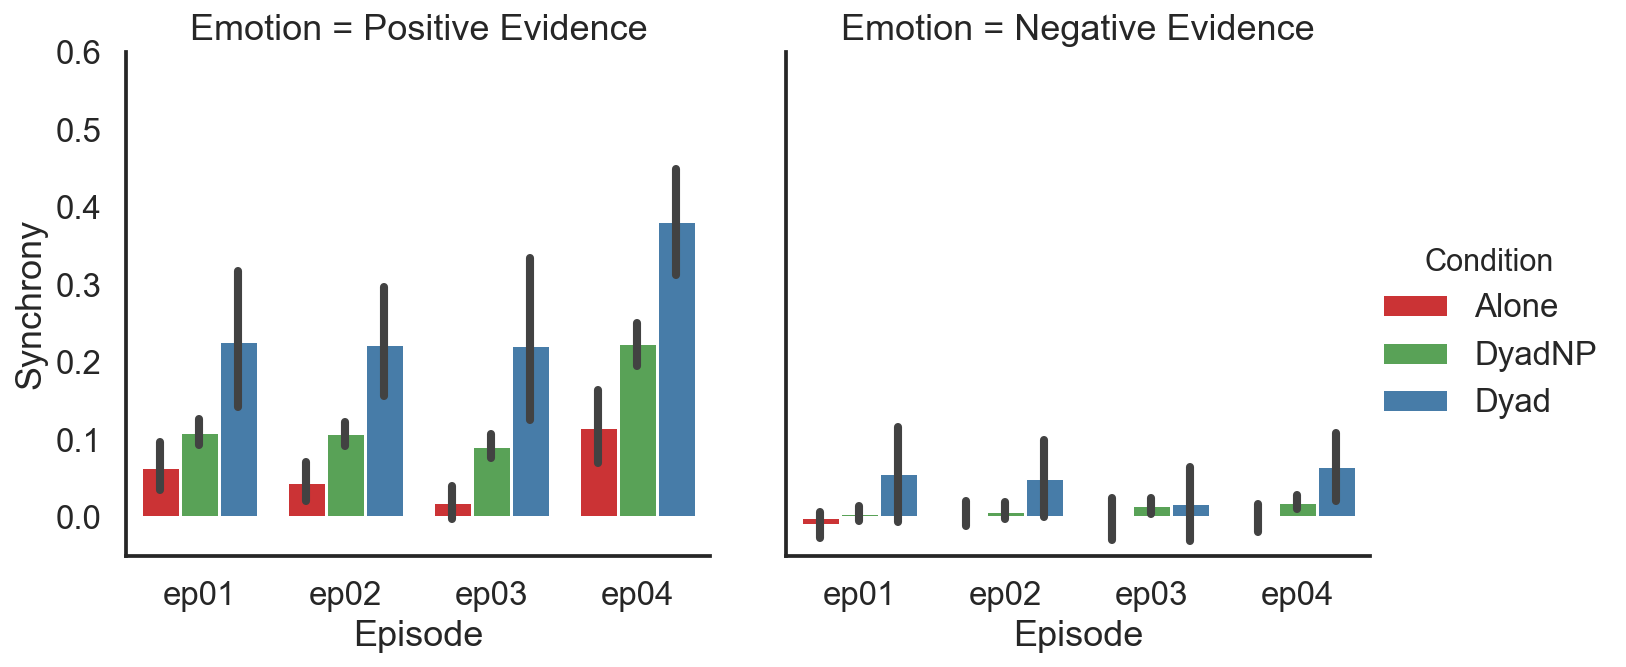

In [8]:
# Figure 1.
sns.factorplot(x='Episode',y='Synchrony',hue='Condition',col='Emotion',hue_order=['Alone','DyadNP','Dyad'],
               units='Sub1',
            data=df.query('(Emotion == "Positive Evidence") | (Emotion == "Negative Evidence")'),ci=95,kind='bar',
            palette=[solocolor,nonpaircolor,dyadcolor]
           )
plt.ylim([-.05,.6]);

In [10]:
# subjectwise bootstrap
from tqdm import tqdm
from scipy.spatial.distance import squareform
def subjectwise_bootstrap(a, condition):
    random_state=1
    from sklearn.utils import check_random_state
    MAX_INT = np.iinfo(np.int32).max
    n_samples = 5000
    random_state = check_random_state(random_state)
    seeds = random_state.randint(MAX_INT, size=n_samples)
    asyncrs = []
    for permute_ix in tqdm(range(n_samples)):
        data_row_id = range(a.shape[0])
        # matrix permutation, shuffle the groups
        ix = random_state.choice(data_row_id,
                           size=len(data_row_id),
                           replace=True) 
        shuffled = parse_triangle(a.iloc[ix,ix].replace({1:np.nan}),condition=condition)
        shuffled = shuffled[~np.isnan(shuffled)]
        asyncrs.append(np.mean(shuffled))
    asyncrs = np.array(asyncrs)
    avg = (1+np.sum(asyncrs<= 0.))/(1+n_samples)
    return avg, asyncrs

In [11]:
# Subjectwise bootstrapping against 0. Compare the bottom of the 95th, 99th, and 99.9 percentiles.
for evidence_type in ['Positive Evidence', 'Negative Evidence']:
    print(evidence_type)
    for epn in epns:
        a = emdict_solo[epn][evidence_type].corr()
        pa, ralone = subjectwise_bootstrap(a, condition='upper')
        a_alpha05 = np.percentile(ralone, q=2.5)
        a_alpha01 = np.percentile(ralone, q=.5)
        a_alpha001 = np.percentile(ralone, q=.05)
        d = emdict_dyad[epn][evidence_type].corr()
        pdyad, rdyad = subjectwise_bootstrap(d, condition='pairs')
        d_alpha05 = np.percentile(rdyad, q=2.5)
        d_alpha01 = np.percentile(rdyad, q=.5)
        d_alpha001 = np.percentile(rdyad, q=.05)
        print(f"{epn}: dyad:{np.mean(parse_triangle(d, condition='pairs')):.2f}, std:{np.std(parse_triangle(d, condition='pairs')):.2f} ,p:{d_alpha001:.5f}, {d_alpha01:.2f}, {d_alpha05:.2f}")
        print(f"{epn}: alone:{np.mean(parse_triangle(a, condition='upper')):.2f}, std:{np.std(parse_triangle(a, condition='upper')):.2f}, p:{a_alpha001:.5f}, {a_alpha01:.2f}, {a_alpha05:.2f}")

  2%|▏         | 111/5000 [00:00<00:04, 1105.49it/s]

Positive Evidence


  2%|▏         | 105/5000 [00:00<00:04, 1047.47it/s]

ep01: dyad:0.23, std:0.25 ,p:0.01461, 0.04, 0.06
ep01: alone:0.06, std:0.13, p:0.00239, 0.01, 0.02


  2%|▏         | 103/5000 [00:00<00:04, 1028.44it/s]

ep02: dyad:0.22, std:0.19 ,p:0.03073, 0.05, 0.06
ep02: alone:0.04, std:0.11, p:-0.00622, 0.00, 0.01


  2%|▏         | 105/5000 [00:00<00:04, 1044.77it/s]

ep03: dyad:0.22, std:0.27 ,p:0.01608, 0.03, 0.04
ep03: alone:0.02, std:0.12, p:-0.01637, -0.01, -0.00


  2%|▏         | 109/5000 [00:00<00:04, 1085.14it/s]

ep04: dyad:0.38, std:0.19 ,p:0.13155, 0.15, 0.17
ep04: alone:0.12, std:0.13, p:0.03102, 0.04, 0.06
Negative Evidence


  2%|▏         | 99/5000 [00:00<00:04, 987.87it/s]

ep01: dyad:0.06, std:0.17 ,p:-0.07706, -0.06, -0.04
ep01: alone:-0.01, std:0.10, p:-0.04994, -0.04, -0.03


  2%|▏         | 103/5000 [00:00<00:04, 1027.71it/s]

ep02: dyad:0.05, std:0.13 ,p:-0.06215, -0.05, -0.03
ep02: alone:0.00, std:0.08, p:-0.02700, -0.02, -0.01


  2%|▏         | 107/5000 [00:00<00:04, 1068.14it/s]

ep03: dyad:0.02, std:0.13 ,p:-0.05999, -0.04, -0.03
ep03: alone:-0.00, std:0.15, p:-0.04864, -0.04, -0.03


100%|██████████| 5000/5000 [00:04<00:00, 1060.60it/s]

ep04: dyad:0.07, std:0.12 ,p:-0.03839, -0.03, -0.02
ep04: alone:-0.00, std:0.10, p:-0.03327, -0.03, -0.02


Positive Evidence
ep01 Pair-alone Subject wise permutation (SWP) r: 0.16 pval:  0.0002
ep01 Nonpair-alone Subject wise permutation (SWP) r: 0.05 pval:  0.1394
ep01 Pairs-Nonpair Subject wise permutation (SWP) r: 0.12 pval:  0.0002


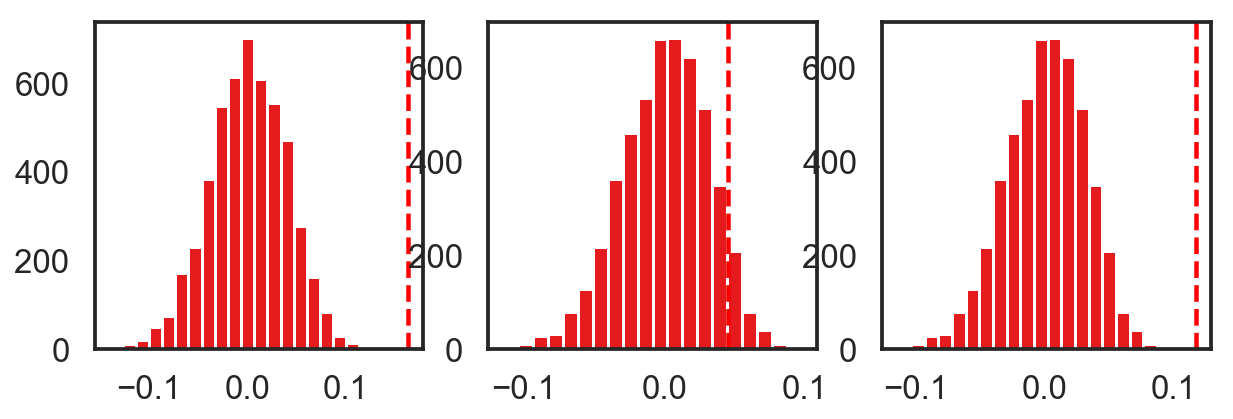

ep02 Pair-alone Subject wise permutation (SWP) r: 0.18 pval:  0.0002
ep02 Nonpair-alone Subject wise permutation (SWP) r: 0.06 pval:  0.0272
ep02 Pairs-Nonpair Subject wise permutation (SWP) r: 0.11 pval:  0.0002


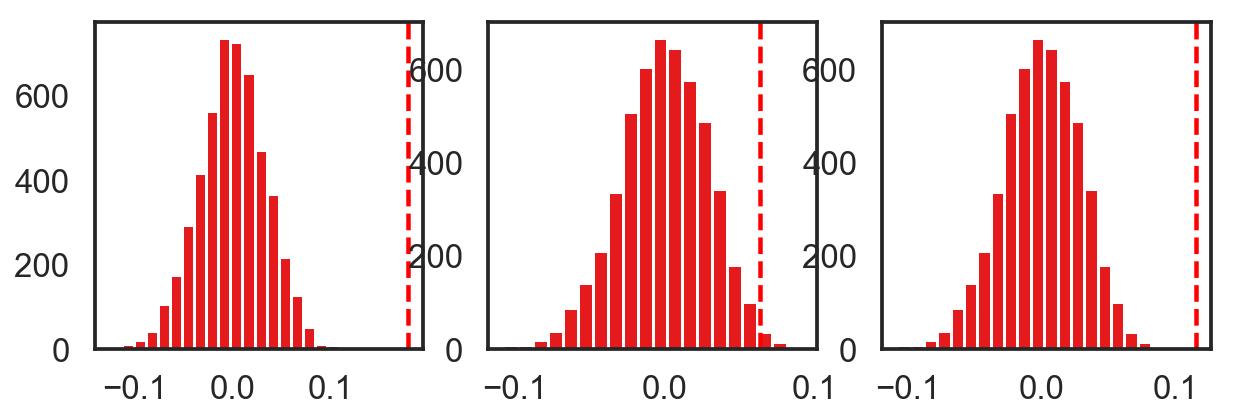

ep03 Pair-alone Subject wise permutation (SWP) r: 0.20 pval:  0.0002
ep03 Nonpair-alone Subject wise permutation (SWP) r: 0.07 pval:  0.01
ep03 Pairs-Nonpair Subject wise permutation (SWP) r: 0.13 pval:  0.0002


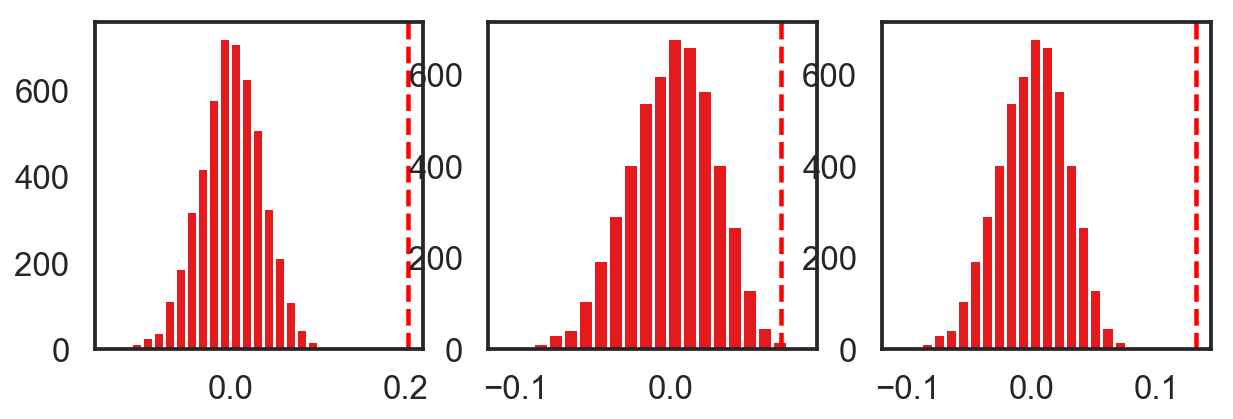

ep04 Pair-alone Subject wise permutation (SWP) r: 0.27 pval:  0.0002
ep04 Nonpair-alone Subject wise permutation (SWP) r: 0.11 pval:  0.0142
ep04 Pairs-Nonpair Subject wise permutation (SWP) r: 0.16 pval:  0.0002


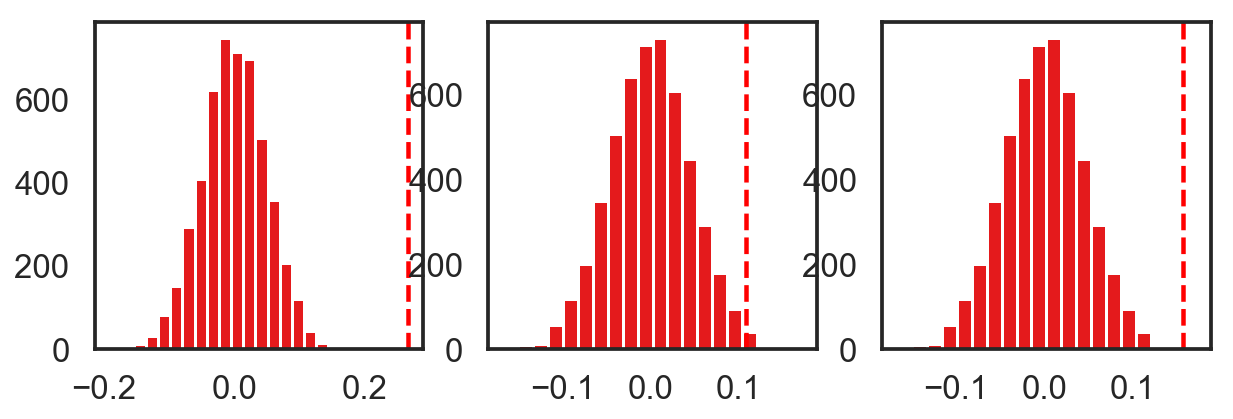

Negative Evidence
ep01 Pair-alone Subject wise permutation (SWP) r: 0.07 pval:  0.0088
ep01 Nonpair-alone Subject wise permutation (SWP) r: 0.02 pval:  0.158
ep01 Pairs-Nonpair Subject wise permutation (SWP) r: 0.05 pval:  0.033


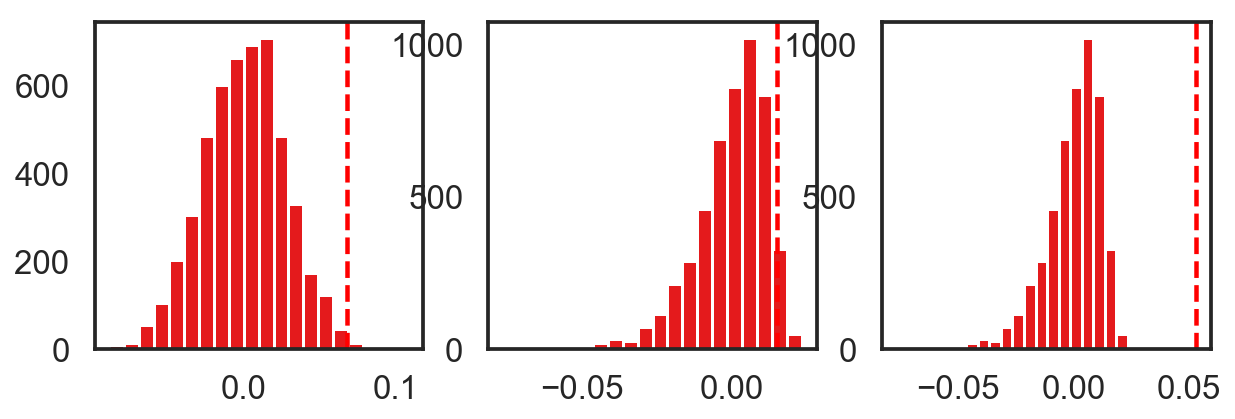

ep02 Pair-alone Subject wise permutation (SWP) r: 0.05 pval:  0.0432
ep02 Nonpair-alone Subject wise permutation (SWP) r: 0.00 pval:  0.7347
ep02 Pairs-Nonpair Subject wise permutation (SWP) r: 0.04 pval:  0.0372


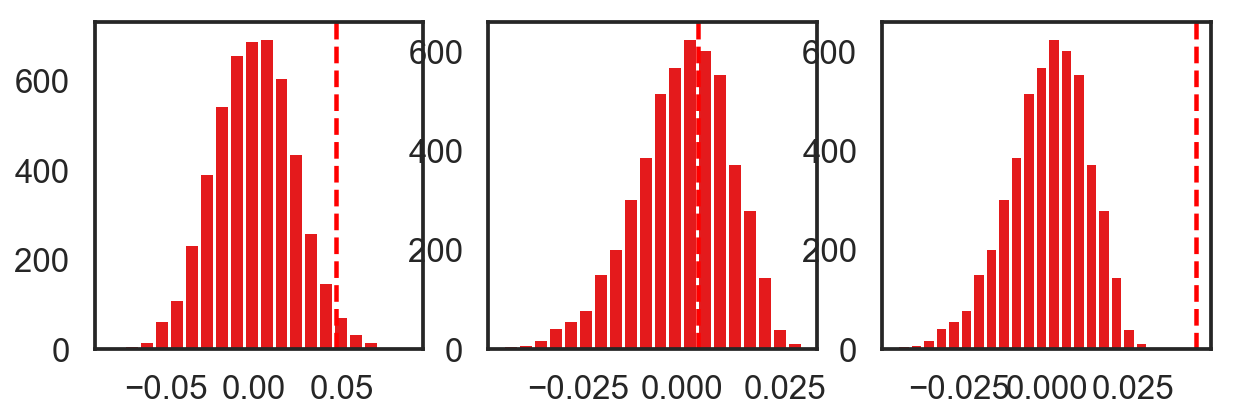

ep03 Pair-alone Subject wise permutation (SWP) r: 0.02 pval:  0.4315
ep03 Nonpair-alone Subject wise permutation (SWP) r: 0.02 pval:  0.1404
ep03 Pairs-Nonpair Subject wise permutation (SWP) r: 0.00 pval:  0.8898


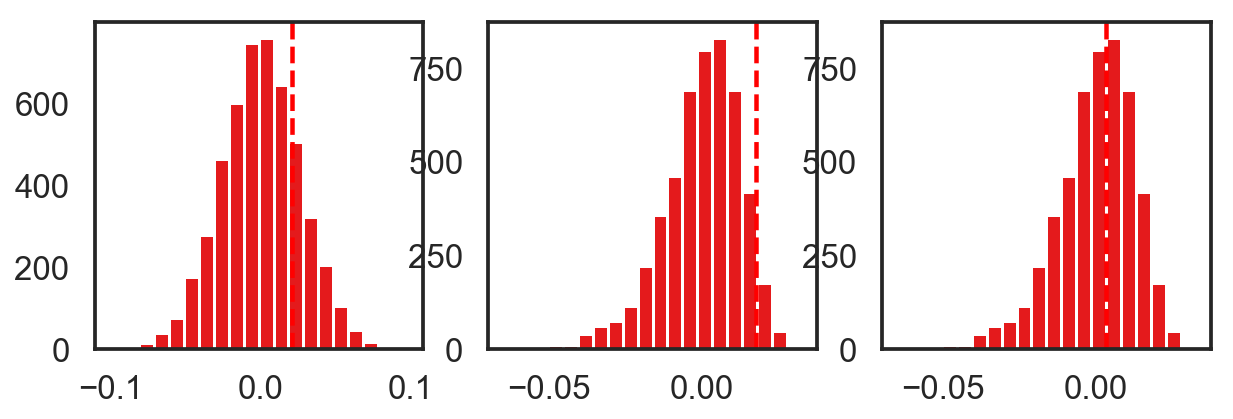

ep04 Pair-alone Subject wise permutation (SWP) r: 0.07 pval:  0.0016
ep04 Nonpair-alone Subject wise permutation (SWP) r: 0.02 pval:  0.0354
ep04 Pairs-Nonpair Subject wise permutation (SWP) r: 0.05 pval:  0.0128


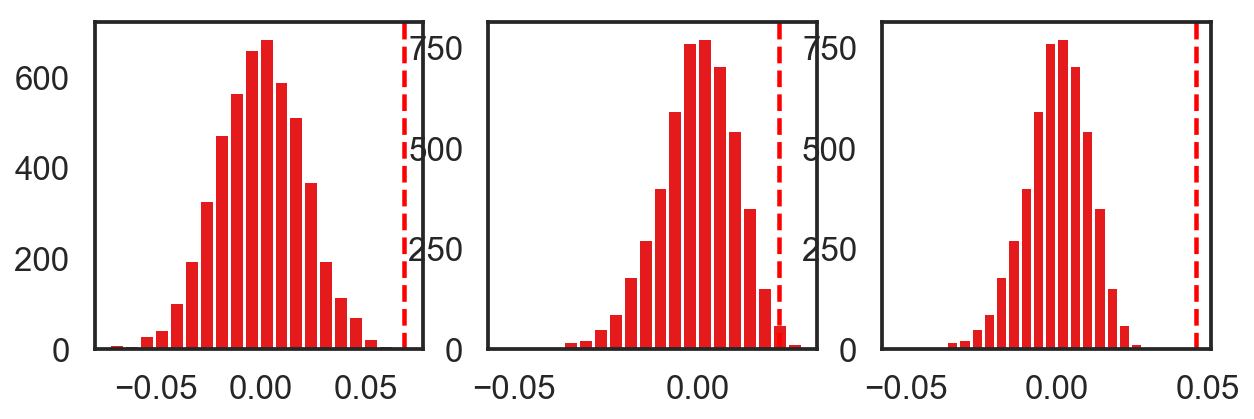

In [12]:
# Subject wise Permutation group difference of faical expression synchrony. Reassign across groups without replacement. 
random_state=1
from sklearn.utils import check_random_state
MAX_INT = np.iinfo(np.int32).max

for emotion in ['Positive Evidence','Negative Evidence']:
    print(emotion)
    for epi, epn in enumerate(['ep01','ep02','ep03','ep04']):
        # generate a combined group matrix of correlations
        fullm = pd.concat([emdict_solo[epn][emotion], emdict_dyad[epn][emotion]],axis=1).corr()
    #     fullm = fullm.apply(nlstats.fisher_r_to_z) # Fisher r to z
        data = fullm.copy()
        diffs = []
        n_samples=5000
        n_jobs=-1
        random_state = check_random_state(random_state)
        seeds = random_state.randint(MAX_INT, size=n_samples)
        data_row_id = range(data.shape[0])
        diffs_pairs_alone, diffs_nonpairs_alone, diffs_pairs_nonpairs =[],[],[]
        for i in range(n_samples):
            # matrix permutation, shuffle the groups
            ix = random_state.choice(data_row_id,
                               size=len(data_row_id),
                               replace=False) 
            new_dat = data.iloc[ix,ix]
            new_dyad = new_dat.iloc[21:,21:]
            new_alone = new_dat.iloc[:21,:21]

            pairs = parse_triangle(new_dyad,condition='pairs').mean()
            nonpairs = parse_triangle(new_dyad,condition='nonpairs').mean()
            alone = parse_triangle(new_alone).mean()

            diffs_pairs_alone.append(pairs-alone)
            diffs_nonpairs_alone.append(nonpairs-alone)
            diffs_pairs_nonpairs.append(pairs-nonpairs)

        f,ax = plt.subplots(1,3,figsize=(10,3))

        # pairs - alone
        stats_mean = parse_triangle(fullm.iloc[21:,21:],condition='pairs').mean() - parse_triangle(fullm.iloc[:21,:21]).mean()
        print(f'{epn} Pair-alone Subject wise permutation (SWP) r: {stats_mean:.2f} pval: ',
              np.round(nlstats._calc_pvalue(np.array(diffs_pairs_alone), stats_mean, tail = 2),4))
        ax[0].hist(diffs_pairs_alone,bins=20)
        ax[0].axvline(stats_mean,color='r',linestyle='--')
        # nonpairs-alone
        stats_mean = parse_triangle(fullm.iloc[21:,21:],condition='nonpairs').mean() - parse_triangle(fullm.iloc[:21,:21]).mean()
        print(f'{epn} Nonpair-alone Subject wise permutation (SWP) r: {stats_mean:.2f} pval: ',
              np.round(nlstats._calc_pvalue(np.array(diffs_nonpairs_alone),stats_mean, tail = 2),4))
        ax[1].hist(diffs_nonpairs_alone,bins=20)
        ax[1].axvline(stats_mean,color='r',linestyle='--')
        # pairs - nonpairs
        stats_mean = parse_triangle(fullm.iloc[21:,21:],condition='pairs').mean() - parse_triangle(fullm.iloc[21:,21:],condition='nonpairs').mean()
        print(f'{epn} Pairs-Nonpair Subject wise permutation (SWP) r: {stats_mean:.2f} pval: ',
              np.round(nlstats._calc_pvalue(np.array(diffs_pairs_nonpairs),stats_mean, tail = 2),4))
        ax[2].hist(diffs_nonpairs_alone,bins=20)
        ax[2].axvline(stats_mean,color='r',linestyle='--')    
        plt.show()

### Assess group difference using lmer


In [13]:
# prepare dataframe.
pos_df = df.query('Emotion=="Joy Evidence" and Condition!="DyadNP"') # Alone, Dyad, DyadNP
pos_df['Episode_c'] = pos_df['Episode'].apply(lambda x: int(x[-1])-2.5)
_pos_df = pos_df.copy()
_pos_df['Sub1'] = pos_df['Sub2']
_pos_df['Sub2'] = pos_df['Sub1']
pos_df = pd.concat([pos_df,_pos_df],axis=0).reset_index(drop=True)

/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [22]:
%%R -i pos_df

library(lmerTest)
pos_df$Sub1 <- as.factor(pos_df$Sub1)
pos_df$Sub2 <- as.factor(pos_df$Sub2)
pos_df$Condition <- as.factor(pos_df$Condition)
contrasts(pos_df$Condition)<-c(-.5,.5)
# Dyad - Alone
m <- lmer('Synchrony ~ Condition * Episode_c + (1 + Episode_c|Sub1) + (1 + Episode_c|Sub2)', data = pos_df, 
          control = lmerControl(optimizer ="Nelder_Mead"))
# Alone - DyadNP
# m <- lmer('Synchrony ~ Condition * Episode_c + (1+Episode_c|Sub1) + (1+Episode_c|Sub2)', data = pos_df, 
#           control = lmerControl(optimizer ="Nelder_Mead"))
# For Dyad - DyadNP
# m <- lmer('Synchrony ~ Condition + Episode_c + (1 + Condition|Sub1) + (1 + Condition|Sub2)', data = pos_df, 
#           control = lmerControl(optimizer ="Nelder_Mead"))
summary(m)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
"Synchrony ~ Condition * Episode_c + (1 +Episode_c|Sub1) + (1+Episode_c|Sub2)"
   Data: pos_df
Control: lmerControl(optimizer = "Nelder_Mead")

REML criterion at convergence: -2418.4

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-2.856 -0.642 -0.001  0.671  3.243 

Random effects:
 Groups   Name        Variance Std.Dev. Corr 
 Sub1     (Intercept) 0.020519 0.1432        
          Episode_c   0.000410 0.0202   -0.19
 Sub2     (Intercept) 0.001536 0.0392        
          Episode_c   0.000382 0.0196   0.24 
 Residual             0.013670 0.1169        
Number of obs: 1904, groups:  Sub1, 77; Sub2, 77

Fixed effects:
                     Estimate Std. Error       df t value      Pr(>|t|)    
(Intercept)           0.16244    0.01945 61.45738    8.35 0.00000000001 ***
Condition1            0.20258    0.03890 61.45738    5.21 0.00000234761 ***
Episode_c             0.02968    0.00518 69

In [23]:
tt = 5.21
n = 61.45/2
pval = stats.t.sf(np.abs(tt), n-1)*2 
print(pval, n)

1.320725083681525e-05 30.725


## Figure 1-c. Moment-to-moment synchrony difference between groups

In [25]:
def find_clustermasses(tstats,tcutoff=2,min_cluster_size=2):
    '''
    Find clustermasses with minimum cluster size min_cluster_size
    https://benediktehinger.de/blog/science/statistics-cluster-permutation-test/
    https://www.sciencedirect.com/science/article/pii/S0165027007001707#fig1
    Args:
        tstats: list of tstatistics
        tcutoff: cutoff for significance. 
        min_cluster_size: minimum cluster size. 
    Returns:
        clusterMasses: list of cluster masses
        clusterLocations: list of tuples (start,end) corresponding to the clusters 
    '''
    larger = abs(tstats) > tcutoff
    # smaller = tstats > tcutoff
    clusterMass = 0
    clusterMasses,clusterLocations = [],[]
    i=0
    while i < len(tstats)-min_cluster_size:
        size = min_cluster_size
        if np.all(larger[i:i+size]):
            while np.all(larger[i:i+size]) & (i+size<=len(tstats)):
                size+=1
            clusterBegin = i
            clusterEnd = i+size-1
            clusterMass = np.sum(tstats[i:i+size])
            clusterLocations.append((clusterBegin,clusterEnd))
            clusterMasses.append(clusterMass)
            i = i+size
        else:
            i+=1
    return clusterMasses, clusterLocations
def permute_clustermasses(dyad_dat,solo_dat,min_cluster_size,n_permute=1000, condition = 'intensity'):
    '''
    Permute clustermass
    Find clustermasses with minimum cluster size min_cluster_size
    https://benediktehinger.de/blog/science/statistics-cluster-permutation-test/
    https://www.sciencedirect.com/science/article/pii/S0165027007001707#fig1
    
    Args:
        data x
        data y 
        min_cluster_size: number of consecutive significance to be considered as cluster
        n_permute: number of permutations
        cond: 'intensity' or 'synchrony', if synchrony will calculate 30 second rolling window 
            correlation for each group after the shuffle. 
        
    Returns:
        permuted_masses 
        top : top 97.5% percentile
        low : bottom 97.5% percentile
    '''
    # permute between groups
    permuted_masses = []
    np.random.seed(1)
    for i in range(n_permute):
        combined_df = pd.concat([dyad_dat,solo_dat],axis=1)
        shuffled_idx = np.random.permutation(range(combined_df.shape[1]))
        new_solo = combined_df.iloc[:,shuffled_idx].iloc[:,:solo_dat.shape[1]]
        new_dyad = combined_df.iloc[:,shuffled_idx].iloc[:,solo_dat.shape[1]:]
        if condition=='synchrony':
            rs_pair, rs_solo = [],[]
            window_size = 30
            all_triangle_dyad = new_dyad.rolling(window=window_size,center=True).corr()
            all_triangle_solo = new_solo.rolling(window=window_size,center=True).corr()
            for ix in np.arange(0,solo_dat.shape[0]):
                rs_pair.append(parse_triangle(all_triangle_dyad.loc[ix], 'pairs'))
                rs_solo.append(parse_triangle(all_triangle_solo.loc[ix]))
            new_dyad,new_solo = pd.DataFrame(rs_pair), pd.DataFrame(rs_solo)
        # recalc t
        t, p = stats.ttest_ind(new_dyad.T.values, new_solo.T.values, equal_var =False, nan_policy='omit')
        masses,_ = find_clustermasses(t, min_cluster_size=min_cluster_size)
        permuted_masses.extend(masses)
    # compute two-tailed 5% cutoffs 
    top = np.percentile(permuted_masses,q=97.5)
    low = np.percentile(permuted_masses,q=2.5)
    return permuted_masses, top, low

def tstat_threshold(tstats,tcutoff,mode='greater'):
    '''
    Give a cutoff and will give you values that are greater or lower than the cutoff.
    Inputs:
        tstats
        tcutoff
        mode: 'greater' or 'lower'
    '''
    if mode=='greater': 
        bol = tstats>tcutoff
    elif mode=='lower':
        bol = tstats<tcutoff
    newbol = bol.copy()
    for i, _bol in enumerate(bol[1:]):
        if bol[i-1]==True:
            newbol[i] = True
    return newbol

# precompute moving-window correlations ( 1min )
emotion = 'Positive Evidence'
window_size = 30
demedian = False
epns = ['ep01','ep02','ep03','ep04']
seconds = []
rs_dyad, rs_solo, rs_pair, rs_nonpair ={}, {}, {}, {}
print(emotion)            
# get episode lengths
epn_lengths = []
for epn in epns: 
    epn_lengths.append(emdict_solo[epn][emotion].shape[0])
    
for epi, epn in enumerate(epns): 
    dyad_dat = emdict_dyad[epn][emotion]
    solo_dat = emdict_solo[epn][emotion]
    if demedian:
        all_triangle_dyad = dyad_dat-dyad_dat.median()
        all_triangle_solo = solo_dat-solo_dat.median()
        all_triangle_dyad = all_triangle_dyad.rolling(window=window_size,center=True).corr()
        all_triangle_solo = all_triangle_solo.rolling(window=window_size,center=True).corr()
    else:
        all_triangle_dyad = dyad_dat.rolling(window=window_size,center=True).corr()
        all_triangle_solo = solo_dat.rolling(window=window_size,center=True).corr()
    rs_dyad[epn],rs_solo[epn],rs_pair[epn],rs_nonpair[epn] = [],[],[],[]
    for i in np.arange(0,epn_lengths[epi]):
        rs_dyad[epn].append(parse_triangle(all_triangle_dyad.loc[i]))
        rs_pair[epn].append(parse_triangle(all_triangle_dyad.loc[i], 'pairs'))
        rs_nonpair[epn].append(parse_triangle(all_triangle_dyad.loc[i],'nonpairs'))
        rs_solo[epn].append(parse_triangle(all_triangle_solo.loc[i]))
        
# precompute clustermass comparisons
from scipy import stats
tstats = {'pairs_v_solos':{}, 'nonpairs_v_solos': {}, 'dyads_v_solos':{}}
pvals = {'pairs_v_solos':{}, 'nonpairs_v_solos': {}, 'dyads_v_solos':{}}
for epi, epn in enumerate(epns):
    tstats['pairs_v_solos'][epn],tstats['nonpairs_v_solos'][epn],tstats['dyads_v_solos'][epn]=[],[],[]
    pvals['pairs_v_solos'][epn],pvals['nonpairs_v_solos'][epn],pvals['dyads_v_solos'][epn]=[],[],[]
    for i in np.arange(0,emdict_dyad[epn][emotion].shape[0]):
        if (i < 15) or (i > emdict_dyad[epn][emotion].shape[0]-15):
            v0,v1,v2 = np.nan,np.nan,np.nan
            p0,p1,p2 = np.nan,np.nan,np.nan
        else:
            v0,p0 = stats.ttest_ind(
                nlstats.fisher_r_to_z(rs_pair[epn][i]), 
                nlstats.fisher_r_to_z(rs_solo[epn][i])
                    ,equal_var =False,nan_policy='omit')
            v1,p1 = stats.ttest_ind(
                nlstats.fisher_r_to_z(rs_nonpair[epn][i]), nlstats.fisher_r_to_z(rs_solo[epn][i])
                    ,equal_var =False,nan_policy='omit')
            v2,p2 = stats.ttest_ind(
                nlstats.fisher_r_to_z(rs_dyad[epn][i]), nlstats.fisher_r_to_z(rs_solo[epn][i])
                    ,equal_var =False,nan_policy='omit')
        tstats['pairs_v_solos'][epn].append(v0)
        tstats['nonpairs_v_solos'][epn].append(v1)
        tstats['dyads_v_solos'][epn].append(v2)
        pvals['pairs_v_solos'][epn].append(p0)
        pvals['nonpairs_v_solos'][epn].append(p1)
        pvals['dyads_v_solos'][epn].append(p2)

Positive Evidence


In [ ]:
# permute clustermass and save to file. Use pre computed file cause this takes a long time 4 hour / episode.
import json
permuted_masses_per_episode = {}
demedian=False
min_cluster_size=2
epns = ['ep01','ep02','ep03','ep04']
emotion='Positive Evidence'
for epn in epns: 
    dyad_dat = emdict_dyad[epn][emotion]
    solo_dat = emdict_solo[epn][emotion]
    if demedian: 
        dyad_dat = dyad_dat-dyad_dat.median()
        solo_dat = solo_dat-solo_dat.median()

    tstats_true = np.array(tstats['pairs_v_solos'][epn])
    true_clusterMasses,true_locations = find_clustermasses(tstats_true, min_cluster_size=min_cluster_size)
    permuted_masses, top, low = permute_clustermasses(dyad_dat, solo_dat, min_cluster_size, condition='synchrony')
    # save to json file
    with open('sync_'+epn+'.json','w') as fp:
        json.dump({'true_clusterMasses':true_clusterMasses,'true_locations':true_locations,'top':top,'low':low},fp)
    # also save to dict
    permuted_masses_per_episode[epn] = {'true_clusterMasses':true_clusterMasses,'permuted_masses':permuted_masses,'true_locations':true_locations,'top':top,'low':low}

### Figure 2C

/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/seaborn/algorithms.py:88: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/seaborn/timeseries.py:309: RuntimeWa

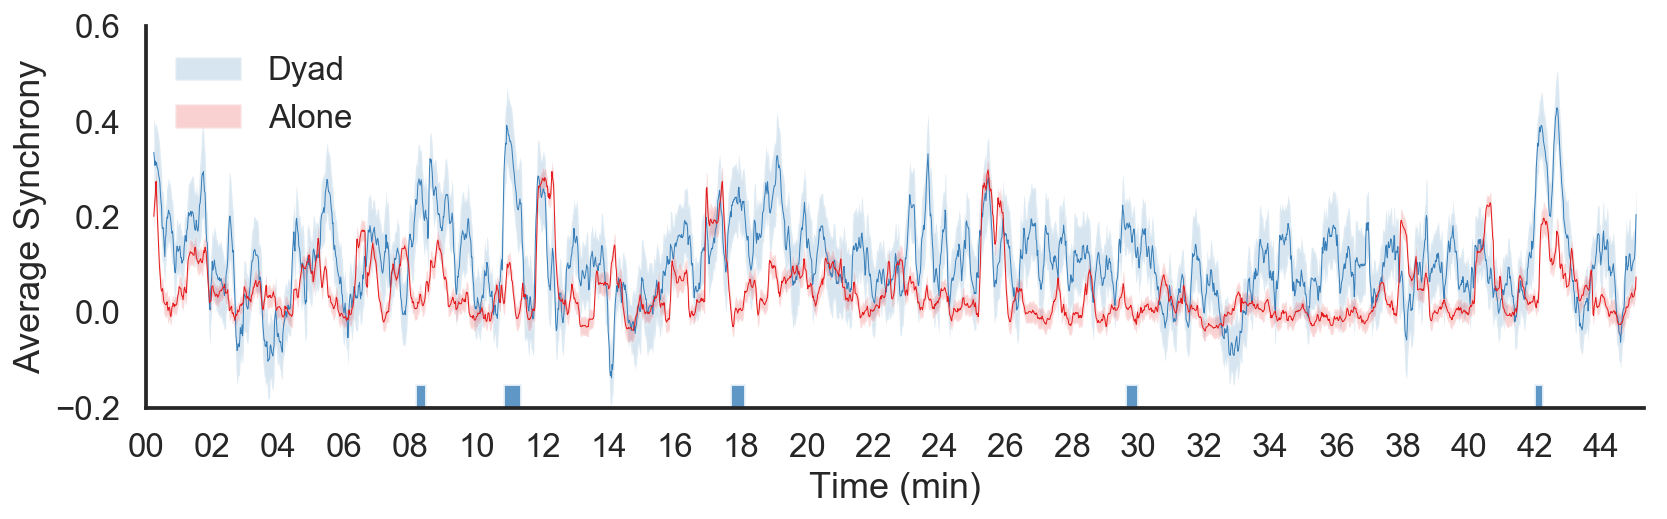

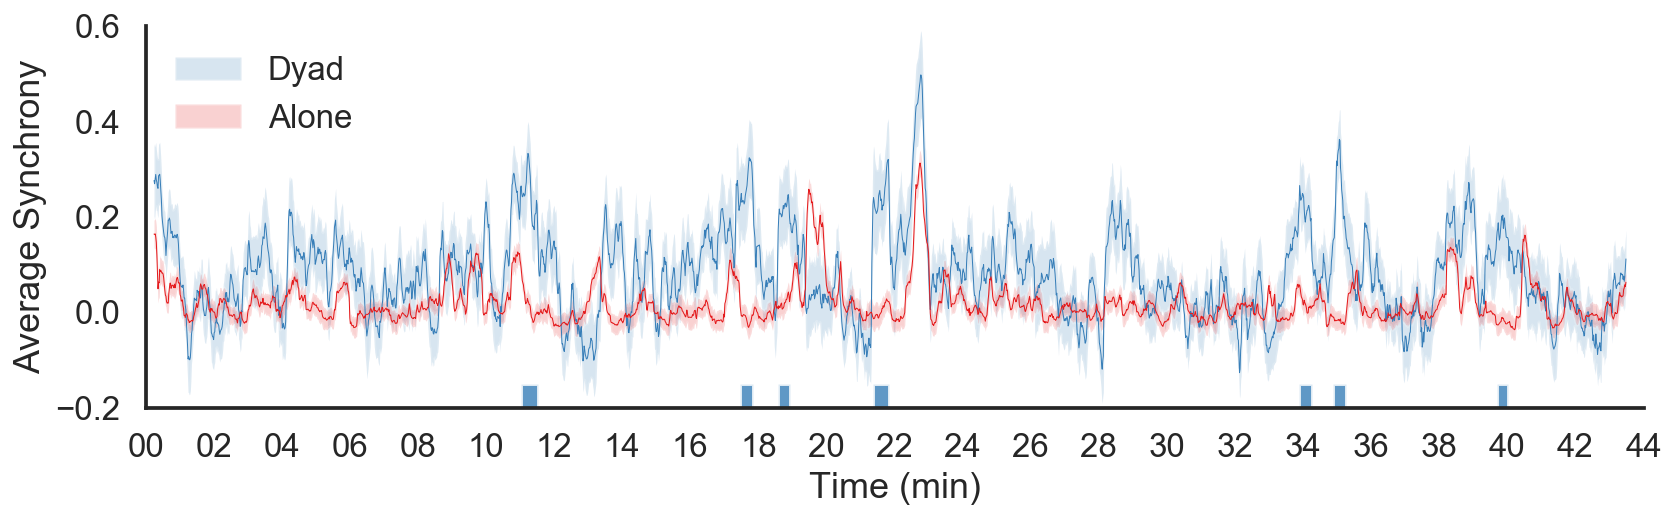

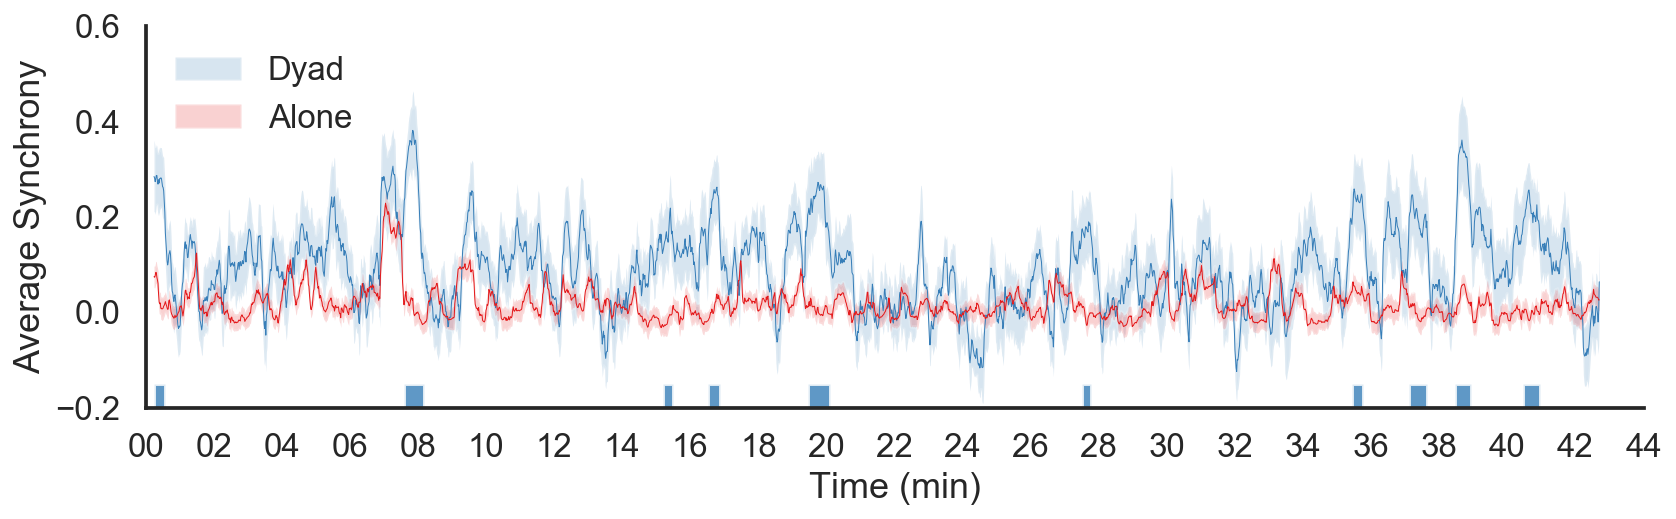

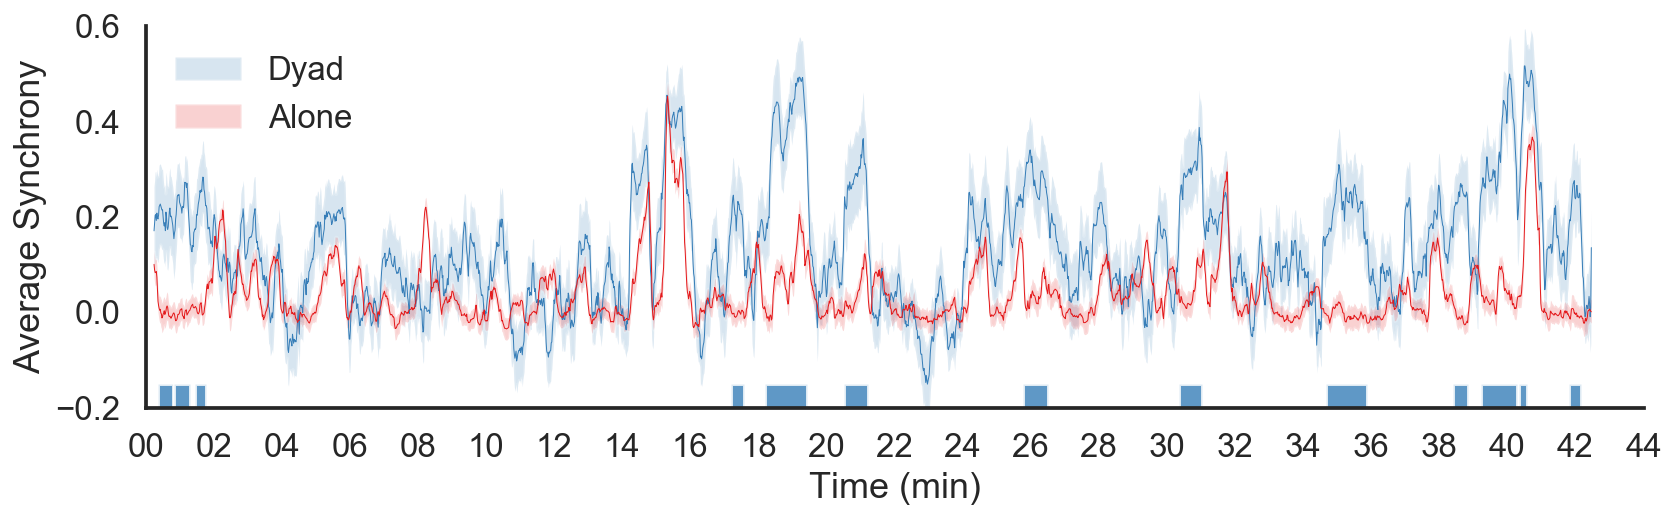

In [2315]:
# Load precomputed data
permuted_masses_per_episode = {}
# epns = ['ep01']
epns = ['ep01','ep02','ep03','ep04']
for epn in epns:
    with open('sync_'+epn+'.json','r') as fp:
        permuted_masses_per_episode[epn] = json.load(fp)
        
# pairs v solos
sns.set_style('white')
sns.set_context('talk')
nboot = 5000
ci = 68
linewidth=.5
tcutoff = 1.96  # p <.05
# tcutoff = 2.64 # p <.01
alpha=.80 # shading
plot_nonpair = False
seconds = []
# epns = ['ep01']
epns = ['ep01','ep02','ep03','ep04']
for epi, epn in enumerate(epns):
    f,ax = plt.subplots(figsize=(12,4))
    sns.tsplot(np.array(rs_pair[epn]).T,estimator=np.nanmean,ci=ci, n_boot=nboot,color=dyadcolor,ax=ax,linewidth=linewidth)
    sns.tsplot(np.array(rs_solo[epn]).T,estimator=np.nanmean,ci=ci, n_boot=nboot,color=solocolor,ax=ax,linewidth=linewidth)

    ax.set_xticks(np.arange(0,len(rs_solo[epn]),60*5))
    ax.set_xticklabels(rec_to_time(ax.get_xticks()))
    tstat = np.nan_to_num(tstats['pairs_v_solos'][epn])
#     ymin, ymax = -.1, .6
    ymin, ymax = -.2, .6
    fillmax = -.15
    
    episode_tstats = tstats['pairs_v_solos'][epn]
    true_locations = permuted_masses_per_episode[epn]['true_locations']
    true_clusterMasses = np.array(permuted_masses_per_episode[epn]['true_clusterMasses'])
    top = permuted_masses_per_episode[epn]['top']
    low = permuted_masses_per_episode[epn]['low']
    
    # plot dyad
    wheres = np.zeros_like(episode_tstats).astype('bool')
    for (start,end) in np.array(true_locations)[true_clusterMasses>top]:
        wheres[start:end] = True
    ax.fill_between(np.arange(0,len(episode_tstats),1),ymin,fillmax,
                   where=wheres,facecolor=dyadcolor,alpha=alpha)
    # plot alone
    wheres = np.zeros_like(episode_tstats).astype('bool')
    for (start,end) in np.array(true_locations)[true_clusterMasses<low]:
        wheres[start:end] = True
    ax.fill_between(np.arange(0,len(episode_tstats),1),ymin,fillmax,
                   where=wheres,facecolor=solocolor,alpha=alpha)
#     ax.set(title=epn.upper())
    ax.set(ylim = [ymin,ymax], xticklabels=rec_to_time(ax.get_xticks()))
    seconds.append([np.sum(tstat_threshold(tstat,-tcutoff,mode='lower')),
                    np.sum(tstat_threshold(tstat,tcutoff,mode='greater'))])
    ax.set(ylim=[ymin,ymax], #title='Episode '+str(epi+1)+': Synchrony Dyad vs Alone', 
               ylabel='Average Synchrony', xlabel = 'Time (min)')
    ax.set_xticks(np.arange(0,2718,120),minor=False)
    ax.set(xticklabels = [tick[:2] for tick in rec_to_time(ax.get_xticks(),TR=1)])
    if plot_nonpair:
        lables = ['Dyad_P','Alone','Dyad_NP']
    else:
        lables = ['Dyad','Alone']
    ax.legend(lables,loc = 2, frameon=False)
    plt.tight_layout()
    sns.despine()
#     plt.savefig('Figures/Filtered_'+epn+'_window_sync.pdf',dpi=300)
    plt.show()

In [1855]:
# Count the number of clusters for dyad higher. 
# Load precomputed data
# permuted_masses_per_episode = {}
# epns = ['ep01']
epns = ['ep01','ep02','ep03','ep04']
for epn in epns:
#     with open('sync_'+epn+'.json','r') as fp:
    with open('sync_'+epn+'.json','r') as fp:
        permuted_masses_per_episode[epn] = json.load(fp)
        
dyad_higher, solo_higher = [], []
dyad_higher_duration, solo_higher_duration = [], []
for epn in epns:
    true_locations = permuted_masses_per_episode[epn]['true_locations']
    true_clusterMasses = np.array(permuted_masses_per_episode[epn]['true_clusterMasses'])
    dyadhigher = np.array(true_clusterMasses)[true_clusterMasses > top]
    solohigher = np.array(true_clusterMasses)[true_clusterMasses < low]
    print(f"{epn}: DyadHigher:{len(dyadhigher)}, SoloHigher:{len(solohigher)}")
    dyad_higher.extend(dyadhigher)
    solo_higher.extend(solohigher)
    dyad_higher_duration.extend(list(map(lambda x: np.diff(x), np.array(true_locations)[true_clusterMasses>top])))        
    solo_higher_duration.extend(list(map(lambda x: np.diff(x), np.array(true_locations)[true_clusterMasses<low])))
    
# # Test if cluster sizes are greater in dyads than solo
# t,p = stats.ttest_ind(np.array(dyad_higher),abs(np.array(solo_higher)),equal_var=False)
# degress_of_freedom = len(np.array(dyad_higher))+len(abs(np.array(solo_higher)))-2
# print(f'Cluster size difference t({degress_of_freedom}):{t}, p:{p} ')

# t,p = stats.ttest_ind(np.array(dyad_higher_duration),abs(np.array(solo_higher_duration)),equal_var=False)
# degress_of_freedom = len(np.array(dyad_higher_duration))+len(abs(np.array(solo_higher_duration)))-2
# print(f'Duration difference t({degress_of_freedom}):{t}, p:{p} ')

ep01: DyadHigher:5, SoloHigher:0
ep02: DyadHigher:7, SoloHigher:0
ep03: DyadHigher:7, SoloHigher:0
ep04: DyadHigher:13, SoloHigher:0


ep01: DyadHigher:5, SoloHigher:0
Joy v Anger: 3.39 0.028
Joy v Disgust: 2.79 0.049
Joy v Fear: 4.27 0.013
Joy v Joy: nan nan
Joy v Sadness: 2.47 0.069
Joy v Surprise: 3.18 0.034


/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


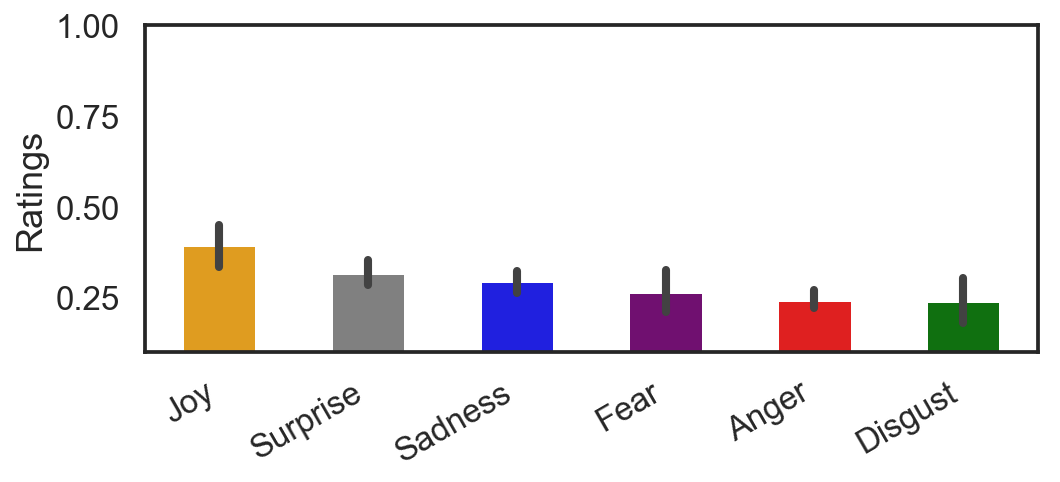

In [2276]:
mturk_clusters = pd.DataFrame()
for epn in ['ep01']:
    true_locations = permuted_masses_per_episode[epn]['true_locations']
    true_clusterMasses = np.array(permuted_masses_per_episode[epn]['true_clusterMasses'])
    dyadhigher = np.array(true_clusterMasses)[true_clusterMasses > top]
    solohigher = np.array(true_clusterMasses)[true_clusterMasses < low]
    print(f"{epn}: DyadHigher:{len(dyadhigher)}, SoloHigher:{len(solohigher)}")
    for (start,end) in np.array(true_locations)[true_clusterMasses > top]:
        mturk_clusters = pd.concat([mturk_clusters, dm.iloc[start:end,:].mean()],axis=1)
        
emotion_color ={}    
emotion_color['Joy'] = "Orange" # Orange
emotion_color['Sadness'] = "Blue"
emotion_color['Disgust'] = "Green"
emotion_color['Fear'] = "Purple"
emotion_color['Anger'] = "Red"
emotion_color['Surprise'] = "Grey"

emotions = ['Anger','Disgust','Fear','Joy','Sadness','Surprise']
f,ax=plt.subplots(figsize=(8,3))
ascending_index = mturk_clusters.T[emotions].mean().sort_values(ascending=False).index
ax = sns.barplot(data=mturk_clusters.T[emotions], order=ascending_index, palette = [emotion_color[emotion] for emotion in ascending_index])
# Change Width of Bars
newwidth = .5
for bar in ax.patches:
    x = bar.get_x()
    width= bar.get_width()
    centre = x + width/2.
    bar.set_x(centre - newwidth/2.)
    bar.set_width(newwidth)
ax.set_xticklabels(ascending_index, rotation=30,ha='right');
ax.set(ylim=[.1,1.], ylabel='Ratings')

for emotion in emotions:
    t,p = stats.ttest_1samp(mturk_clusters.T['Joy'].values-mturk_clusters.T[emotion].values,0)
    print(f"Joy v {emotion}: {t:.2f} {p:.3f}")
    
# f,ax=plt.subplots(figsize=(10,3))
# ascending_index = mturk_clusters.T.mean().sort_values(ascending=False).index
# sns.barplot(data=mturk_clusters.T, order=ascending_index)
# ax.set_xticklabels(ascending_index, rotation=30,ha='right');

In [2311]:
mturk_df_r = (100*mturk_clusters).T[['Anger', 'Disgust', 'Fear', 'Sadness', 'Surprise', 'Joy']].melt(var_name = 'Emotion', value_name = 'Rating')

In [2312]:
%%R -i mturk_df_r
mturk_df_r$Emotion <- as.factor(mturk_df_r$Emotion)
my.helmert = matrix(c(-1/6,-1/6,-1/6,5/6,-1/6,-1/6,-1/5,-1/5,-1/5,0,-1/5,4/5,-1/4,-1/4,-1/4,0,3/4,0,-1/3,-1/3,1/3,0,0,0,1/2,-1/2,0,0,0,0), ncol = 5)
contrasts(mturk_df_r$Emotion) <- my.helmert
print(contrasts(mturk_df_r$Emotion))
summary(lm('Rating ~ Emotion', data=mturk_df_r))

             [,1] [,2]  [,3]     [,4] [,5]
Anger    -0.16667 -0.2 -0.25 -0.33333  0.5
Disgust  -0.16667 -0.2 -0.25 -0.33333 -0.5
Fear     -0.16667 -0.2 -0.25  0.33333  0.0
Joy       0.83333  0.0  0.00  0.00000  0.0
Sadness  -0.16667 -0.2  0.75  0.00000  0.0
Surprise -0.16667  0.8  0.00  0.00000  0.0

Call:
lm(formula = "Rating ~ Emotion", data = mturk_df_r)

Residuals:
   Min     1Q Median     3Q    Max 
-9.971 -2.398 -0.318  2.731 11.397 

Coefficients:
            Estimate Std. Error t value             Pr(>|t|)    
(Intercept)   29.387      1.136   25.86 < 0.0000000000000002 ***
Emotion1      12.140      2.976    4.08              0.00043 ***
Emotion2       5.230      3.047    1.72              0.09896 .  
Emotion3       4.091      3.166    1.29              0.20869    
Emotion4       3.703      4.961    0.75              0.46267    
Emotion5       0.411      3.819    0.11              0.91520    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard 

ep01: DyadHigher:5, SoloHigher:0
Joy v Anger: 11.63 0.000
Joy v Disgust: 12.39 0.000
Joy v Fear: 18.79 0.000
Joy v Joy: nan nan
Joy v Sadness: 10.19 0.000
Joy v Surprise: 11.41 0.000


/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


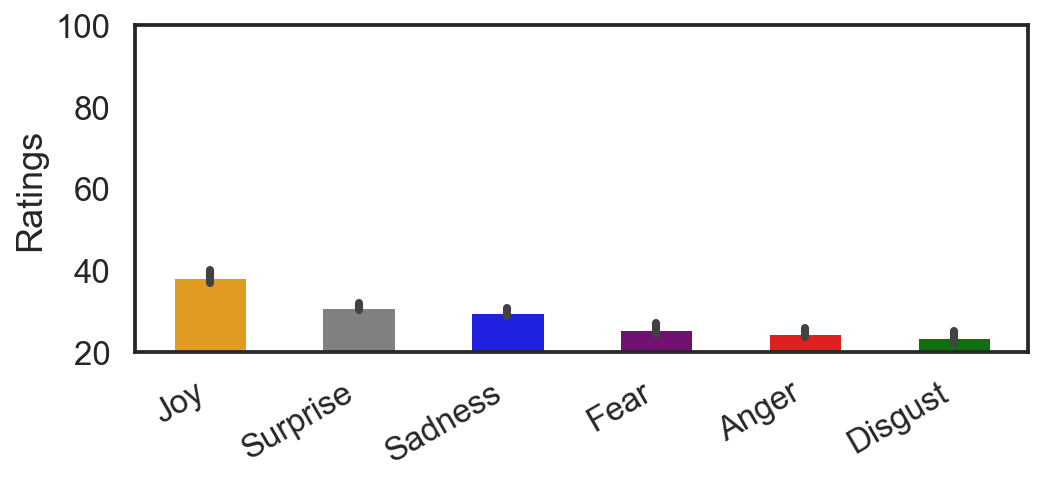

In [2275]:
# Grab all seconds
mturk_clusters = pd.DataFrame()
for epn in ['ep01']:
    true_locations = permuted_masses_per_episode[epn]['true_locations']
    true_clusterMasses = np.array(permuted_masses_per_episode[epn]['true_clusterMasses'])
    dyadhigher = np.array(true_clusterMasses)[true_clusterMasses > top]
    solohigher = np.array(true_clusterMasses)[true_clusterMasses < low]
    print(f"{epn}: DyadHigher:{len(dyadhigher)}, SoloHigher:{len(solohigher)}")
    for (start,end) in np.array(true_locations)[true_clusterMasses > top]:
        mturk_clusters = pd.concat([mturk_clusters, dm.iloc[start:end,:]],axis=0)
        
emotion_color ={}    
emotion_color['Joy'] = "Orange" # Orange
emotion_color['Sadness'] = "Blue"
emotion_color['Disgust'] = "Green"
emotion_color['Fear'] = "Purple"
emotion_color['Anger'] = "Red"
emotion_color['Surprise'] = "Grey"

emotions = ['Anger','Disgust','Fear','Joy','Sadness','Surprise']
f,ax=plt.subplots(figsize=(8,3))
ascending_index = mturk_clusters[emotions].mean().sort_values(ascending=False).index
ax = sns.barplot(data=100*mturk_clusters[emotions], order=ascending_index, palette = [emotion_color[emotion] for emotion in ascending_index])
# Change Width of Bars
newwidth = .5
for bar in ax.patches:
    x = bar.get_x()
    width= bar.get_width()
    centre = x + width/2.
    bar.set_x(centre - newwidth/2.)
    bar.set_width(newwidth)
ax.set_xticklabels(ascending_index, rotation=30,ha='right');
ax.set(ylim=[20,100], ylabel='Ratings')

for emotion in emotions:
    t,p = stats.ttest_1samp(mturk_clusters['Joy'].values-mturk_clusters[emotion].values,0)
    print(f"Joy v {emotion}: {t:.2f} {p:.3f}")
    
# f,ax=plt.subplots(figsize=(10,3))
# ascending_index = mturk_clusters.mean().sort_values(ascending=False).index
# sns.barplot(data=mturk_clusters, order=ascending_index)
# ax.set_xticklabels(ascending_index, rotation=30,ha='right');

## Figure 2C. mTurk emotion ratings predicting positive synchrony


/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)
/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


CI [0.07761303 0.39445325]
CI [0.03608043 0.24073546]
CI [-0.06249523  0.23822167]
CI [-0.12643503  0.1685252 ]
CI [-0.22565833  0.04310689]
CI [-0.19589446  0.11943483]
Joy         0.229603
Disgust     0.136898
Surprise    0.079458
Anger       0.022440
Sadness    -0.084173
Fear       -0.038028
dtype: float64
CI [-0.11437187  0.17538636]
CI [-0.08791123  0.20252441]
CI [0.03920394 0.24467657]
CI [-0.22169727  0.14841294]
CI [-0.34803345 -0.04730885]
CI [-0.18578168  0.10586591]
CI [-0.09274     0.21932285]
CI [-0.23736461  0.06878125]
CI [-0.33473605  0.10744087]
CI [0.08077645 0.40620681]
CI [-0.11124065  0.14468022]
CI [-0.09598372  0.19626105]
CI [-0.21559567  0.04093938]
CI [-0.16855664  0.15005658]
CI [-0.23295443 -0.00840429]
CI [-0.0699698   0.24380412]


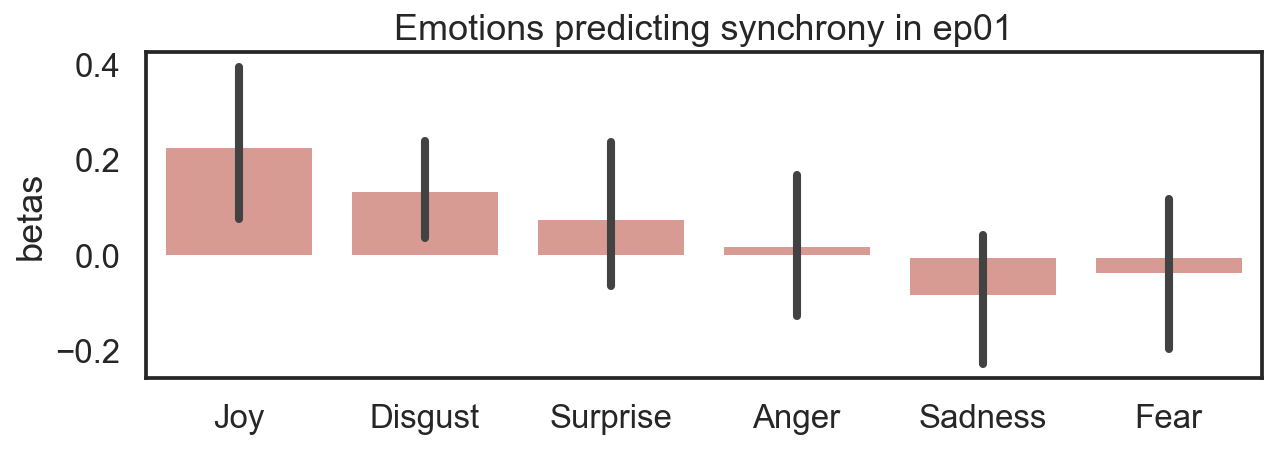

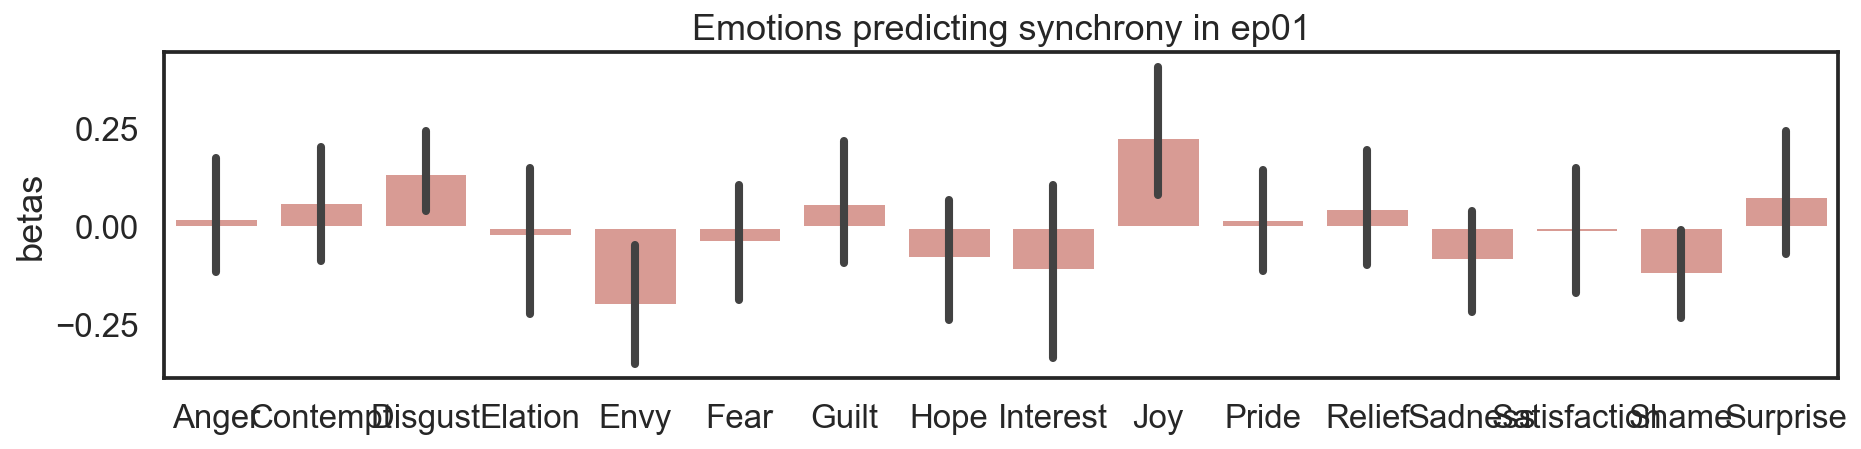

In [26]:
# Load emotion rating data from mTurk 
df = pd.read_csv('../../Data/mTurkRatings/mTurkRatings_long.csv',names=['rating','time','emotion','subID'])
df = df.replace({-1:np.nan})
df['dmrating'] = df.groupby('subID').transform(lambda x: x-x.mean())['rating']
df_short = pd.pivot_table(df,values =['rating'],index=['time'],columns=['emotion','subID'])
df_short = df_short.replace({-1:np.nan})
window = 30
emotions = ['Anger', 'Contempt', 'Disgust', 'Elation', 'Envy', 'Fear', 'Guilt',
       'Hope', 'Interest', 'Joy', 'Pride', 'Relief', 'Sadness', 'Satisfaction',
       'Shame', 'Surprise']
# emotions = ['Anger','Disgust','Fear','Joy','Sadness','Surprise']
dm = pd.DataFrame(index=range(0,2718))
for ix, emotion in enumerate(emotions):
    meandf = df_short.loc[:,'rating'][emotion].mean(axis=1)
    # set to zero indexing 
    meandf.index = meandf.index-1
    dm[emotion] = meandf/100
dm = dm.interpolate(method='linear',axis=0).rolling(window=window,center=True).mean()

from sklearn.linear_model import LinearRegression
epn = 'ep01'
Y = pd.DataFrame(rs_pair[epn])
coefs = []
noDyads = int(dyad_dat.shape[1]/2)
for pairix in range(noDyads):
    y = Y.iloc[:,pairix]
    X = dm.copy()
    notna = ~(y.isna() | X.isna().any(axis=1))
    lm = LinearRegression()
    lm.fit(X[notna],y[notna])
    coefs.append(lm.coef_)

f,ax = plt.subplots(figsize=(10,3))
sns.barplot(data = pd.DataFrame(coefs,columns=dm.columns)[['Joy','Disgust','Surprise','Anger','Sadness','Fear']],ci=95,color='salmon',saturation=.5)
ax.set(title=f'Emotions predicting synchrony in {epn}',ylabel='betas')
[print('CI',line.get_data()[1]) for line in ax.lines];
f,ax = plt.subplots(figsize=(15,3))
sns.barplot(data = pd.DataFrame(coefs,columns=dm.columns),ci=95,color='salmon',saturation=.5)
ax.set(title=f'Emotions predicting synchrony in {epn}',ylabel='betas')
print(pd.DataFrame(coefs,columns=dm.columns)[['Joy','Disgust','Surprise','Anger','Sadness','Fear']].mean())
[print('CI',line.get_data()[1]) for line in ax.lines];

In [9]:
emotions = ['Anger','Disgust','Fear','Joy','Sadness','Surprise']
dm = pd.DataFrame(index=range(0,2718))
for ix, emotion in enumerate(emotions):
    meandf = df_short.loc[:,'rating'][emotion].mean(axis=1)
    # set to zero indexing 
    meandf.index = meandf.index-1
    dm[emotion] = meandf/100
    print(emotion, dm[emotion].notna().sum())
dm = dm.interpolate(method='linear',axis=0).rolling(window=window,center=False).mean()

Anger 543
Disgust 558
Fear 664
Joy 888
Sadness 765
Surprise 918


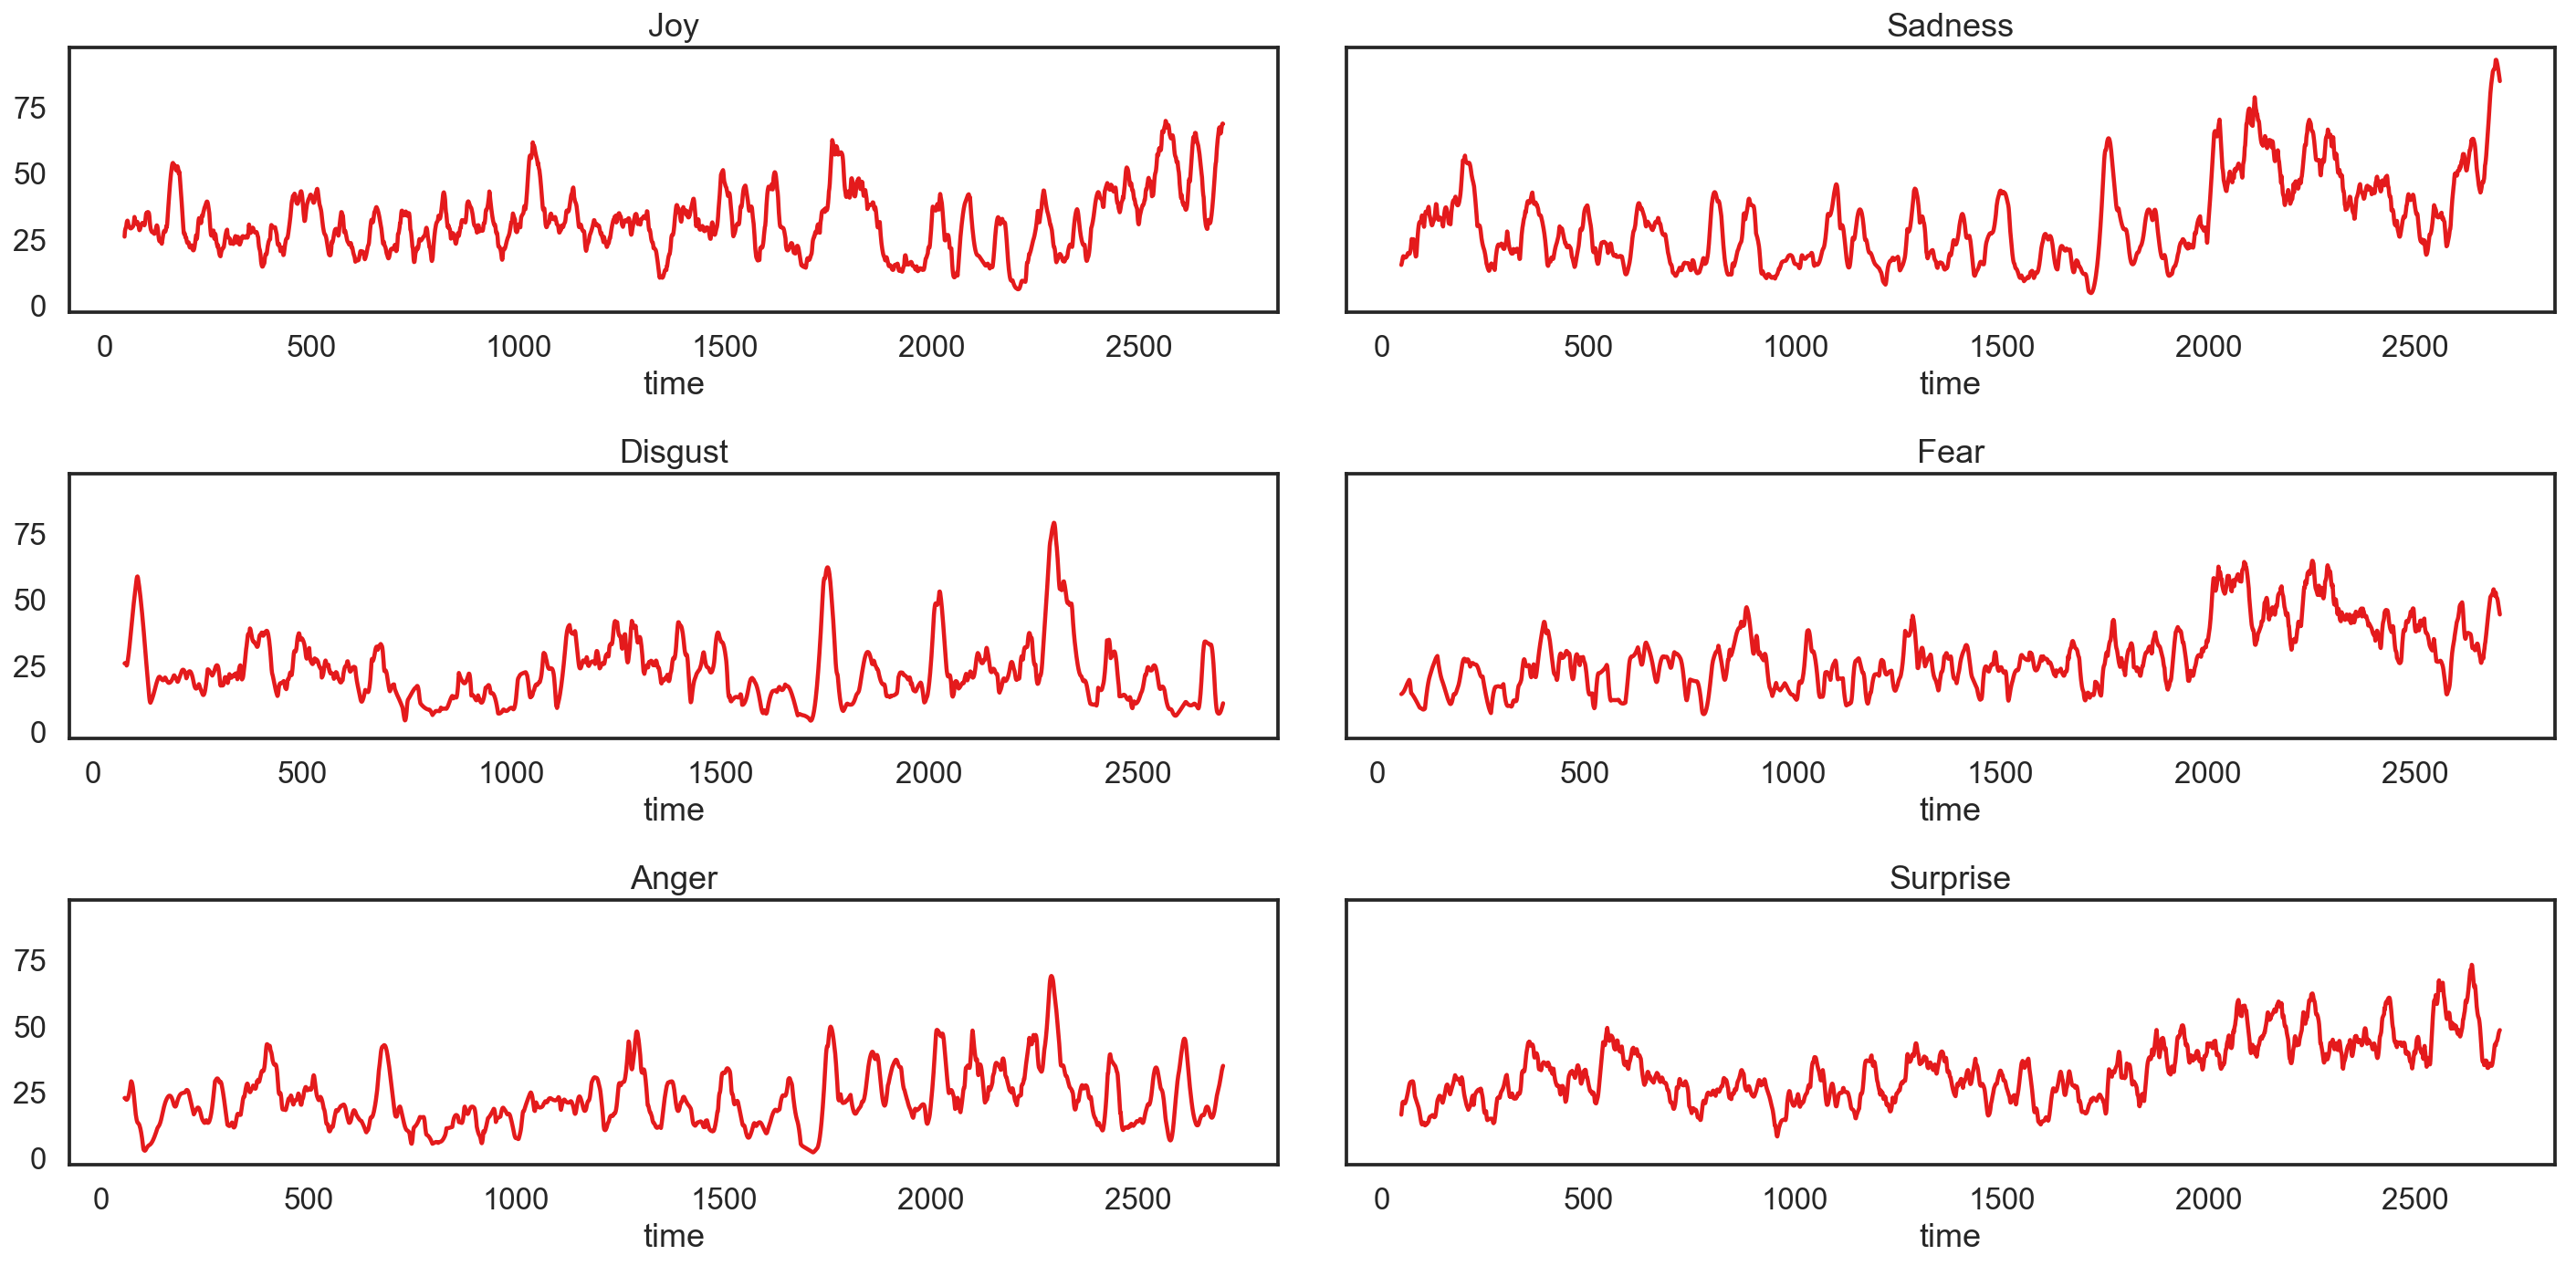

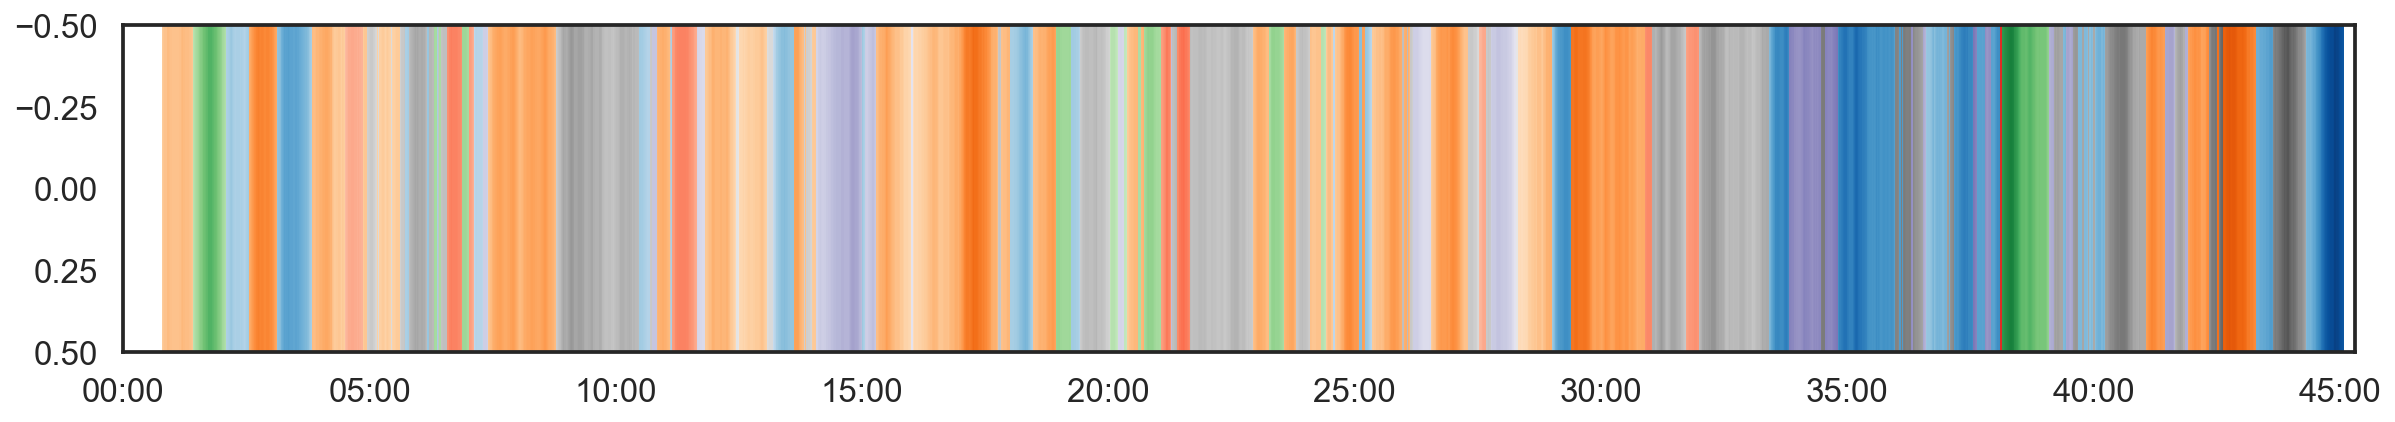

In [220]:
window = 30
# emotions = ['Anger', 'Contempt', 'Disgust', 'Elation', 'Envy', 'Fear', 'Guilt',
#        'Hope', 'Interest', 'Joy', 'Pride', 'Relief', 'Sadness', 'Satisfaction',
#        'Shame', 'Surprise']
emotions = ['Joy','Sadness','Disgust','Fear','Anger','Surprise']
df_turkratings = pd.DataFrame()

f,axes = plt.subplots(3,2,figsize=(20,10),sharey=True)
axes = axes.flatten()
for ix, emotion in enumerate(emotions):
    meandf = df_short.loc[:,'rating'][emotion].mean(axis=1)
    meandf = meandf.reindex(np.arange(0,1+max(meandf.index)))
    meandf = meandf.interpolate(method='linear',axis=0).rolling(window=window,center=True).mean()
    meandf.plot(ax=axes[ix],label=emotion)
    df_turkratings[emotion] = meandf
    axes[ix].set(title=emotion)
plt.tight_layout()
plt.show()
list_max_emotion = []
list_max_value = []
for t in range(df_turkratings.shape[0]):
    try: 
        list_max_emotion.append(df_turkratings.iloc[t,:].idxmax())
        list_max_value.append(df_turkratings.iloc[t,:].max())
    except:
        list_max_emotion.append(None)
        list_max_value.append(None)
_df = pd.DataFrame({'Rating':list_max_value, 'Emotion':list_max_emotion})
emotionkey = {}
for key in emotions:
    emotionkey[key] = np.argwhere(np.array(emotions)==key)[0][0] 
_df['EmotionNum'] = _df.replace(emotionkey)['Emotion']

def color_alpha_adder(colormap):
    '''
    Adds alpha to colormap where first alpha is 0
    '''
    newcol = []
    for coli, col in enumerate(colormap):
        if coli==0:
            newcol.append(np.append(col,[0]))
        else:
            newcol.append(np.append(col,[1]))
    newcol = np.array(newcol)
    return newcol
emotion_color ={}    
emotion_color['Joy'] = color_alpha_adder(np.array(sns.color_palette("Oranges",n_colors=100))) # Orange
emotion_color['Sadness'] = color_alpha_adder(np.array(sns.color_palette("Blues",n_colors=100))) # blue
emotion_color['Disgust'] = color_alpha_adder(np.array(sns.color_palette("Greens",n_colors=100))) #green
emotion_color['Fear'] = color_alpha_adder(np.array(sns.color_palette("Purples",n_colors=100))) # purple
emotion_color['Anger'] = color_alpha_adder(np.array(sns.color_palette("Reds",n_colors=100))) # red
emotion_color['Surprise'] = color_alpha_adder(np.array(sns.color_palette("Greys",n_colors=100))) # Grey

f,ax = plt.subplots(figsize=(20,3))
for emotion in emotions:
    plt.imshow(emotion_color[emotion][_df.where(_df.Emotion==emotion).Rating.fillna(0).astype(int).values[np.newaxis,:]], aspect='auto',
              label=emotion)
ax. set_xticks(range(0,2719,300))
ax.set_xticklabels(rec_to_time(range(0,2719,300) ,TR=1))
plt.show()

In [13]:
'''
Snippet to calculate Pearson correlation with emotion
With Positive synchrony
Joy ()
Sadness (-0.12651703451967522, 5.91235756990427e-11)
With Negative synchrony
Joy..
'''
y = pd.Series(np.nanmean(rs_pair['ep01'],axis=1))
X = dm.Joy
notna = ~(y.isna() | X.isna())
print(stats.pearsonr(X[notna],y[notna]))

y = pd.Series(np.nanmean(rs_solo['ep01'],axis=1))
X = dm.Joy
notna = ~(y.isna() | X.isna())
print(stats.pearsonr(X[notna],y[notna]))

(0.24157390114176164, 1.373019177948745e-36)
(0.2229049061738034, 2.863680674090905e-31)


/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


# Connection predictions with emotion synchrony
## Figure 3A and 3B. Positive & negative synchrony predicting connection ratings

ep01 rho :  0.37937523662479594 p :  0.04647169638832713
ep02 rho :  0.5770945301431022 p :  0.0013039904389288341


/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


ep03 rho :  0.7182587332208666 p :  1.677403275383703e-05
ep04 rho :  0.6718075865531576 p :  9.054683457558923e-05


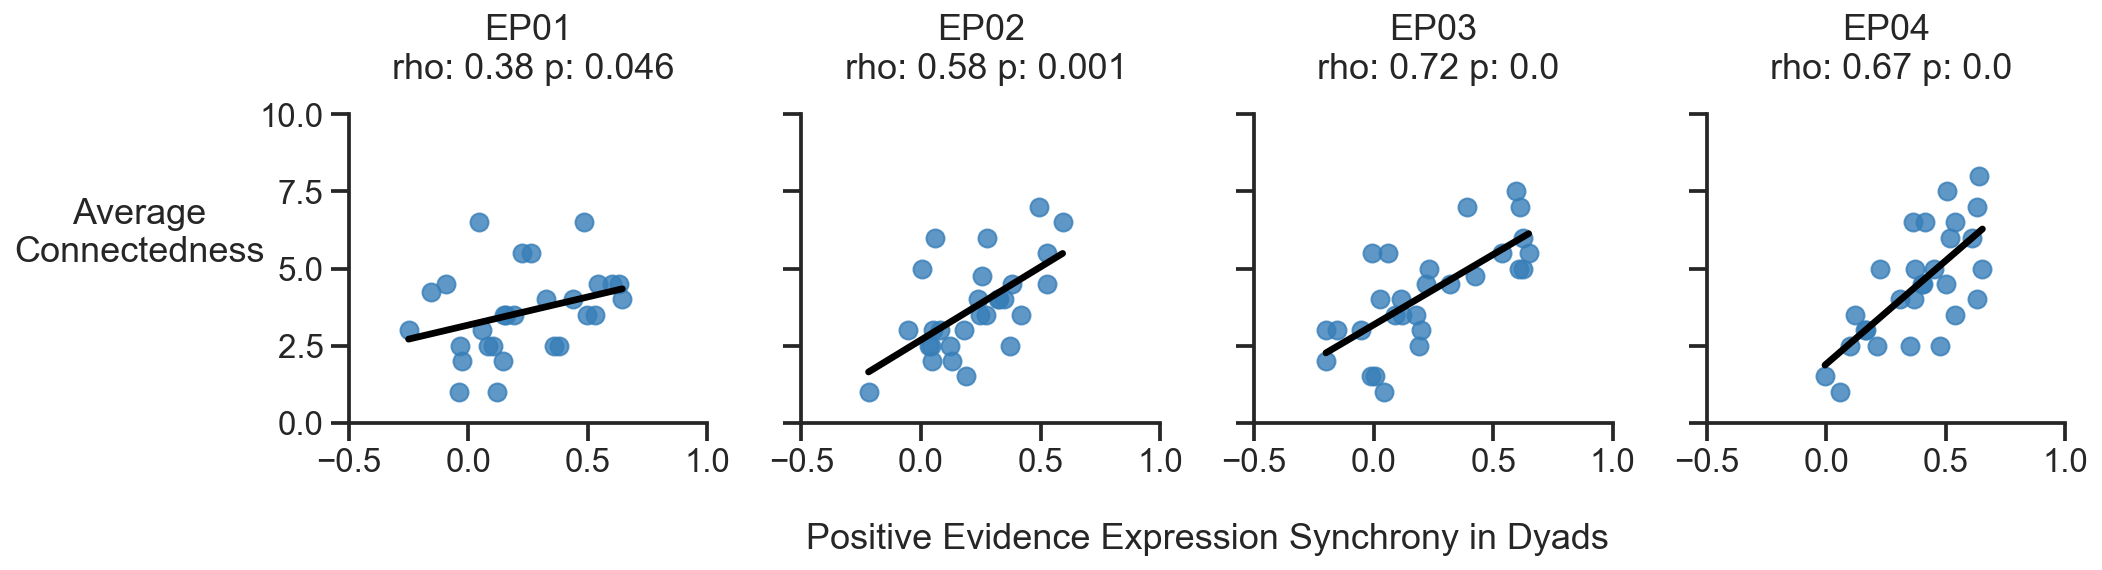

ep01 rho :  0.08415232521495472 p :  0.6702922164186618
ep02 rho :  -0.023655924495856434 p :  0.9048912754286917
ep03 rho :  0.22869929813997744 p :  0.2417664247457743
ep04 rho :  0.395164757215263 p :  0.03741125579354444


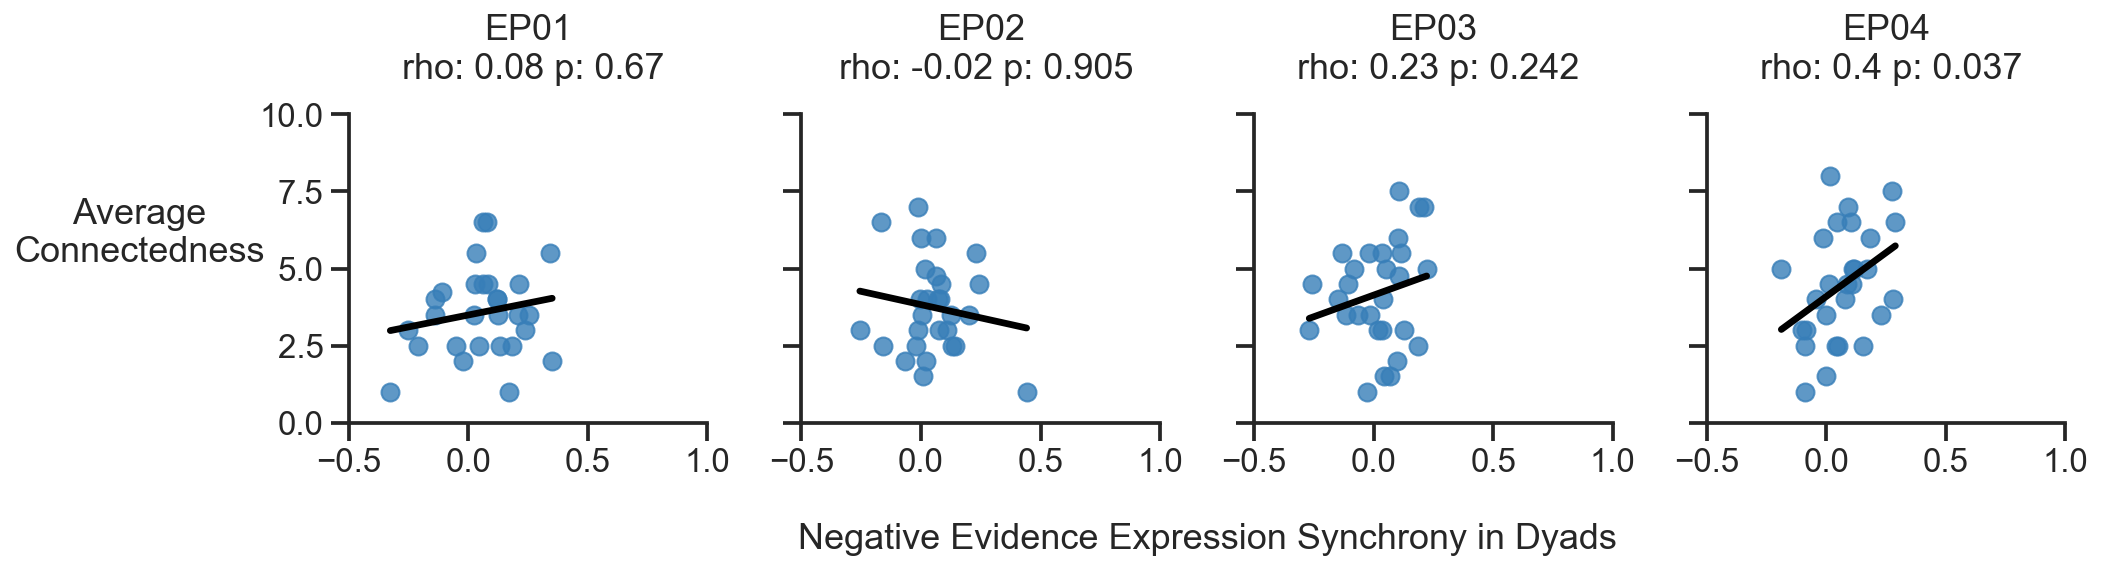

In [10]:
# Connectedness highly correlated with Synchrony.  
exclude_friends = False
sns.set_style("ticks")
sns.set_context('talk')
for emotion in ['Positive Evidence', 'Negative Evidence']:
    epns = ['ep01','ep02','ep03','ep04']
    dyad_expressivity, dyadpair_expressivity = [],[]
    f,ax = plt.subplots(1,len(epns),figsize=(15,5),sharex=True,sharey=True)
    ax[0].set_ylim([0,10])
    ax[0].set_xlim([-.5,1])
    rdf = pd.DataFrame()
    for i, epn in enumerate(epns):
        joydf = emdict_dyad[epn][emotion]
        dyadcorr = nlstats.fisher_r_to_z(np.diag(joydf.corr(),k=1)[range(0,noDyads*2,2)])
        dyadcorr = np.diag(joydf.corr(),k=1)[range(0,noDyads*2,2)]
        dyadconn = connection[epn]
        dyads_friends_bool = ~connection['ep01'].index.isin(dyads_friends)
        if exclude_friends:
            # Results still hold without friends.
            dyadcorr = dyadcorr[dyads_friends_bool]
            dyadconn = dyadconn[dyads_friends_bool]
        r, p = stats.spearmanr(dyadconn, dyadcorr)
        print(epn, 'rho : ',r,'p : ',p)
        ax[i].set_title(epn.upper()+'\n rho: '+ str(np.round(r,2))  +' p: ' + str(np.round(p,3)),y=1.08)
        sns.regplot(y = dyadconn.values,x = dyadcorr,ax=ax[i],color='k',ci=False,truncate=True,scatter_kws={'color':colors[1]})
        rdf = pd.concat([rdf, pd.DataFrame({'dyadID':dyadconn.index.values, 'Episode': np.repeat(epn,len(dyadconn)),
                                            'Session': np.repeat(i-1.5,len(dyadconn)),'Connection': dyadconn.values,
                                            'Synchrony':dyadcorr})])

    ax[0].set_ylabel('Average\nConnectedness',rotation=0,labelpad=60)
    # for common label
    f.add_subplot(111, frameon=False)
    # plt.tick_params(which='both',labelcolor='none', top='off', bottom='off', left='off', right='off')
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.grid(False)
    plt.xlabel(f'{emotion} Expression Synchrony in Dyads',rotation=0,labelpad=50)
    sns.despine()
    plt.tight_layout()
    # f.savefig('Figures/Synchrony_corr_connectedness.pdf',dpi=300)
    plt.show()

## Figure 2-b. Ridge regression predicting connectedness with synchrony of 6 emotions

0it [00:00, ?it/s]/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
28it [00:00, 919.48it/s]
/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


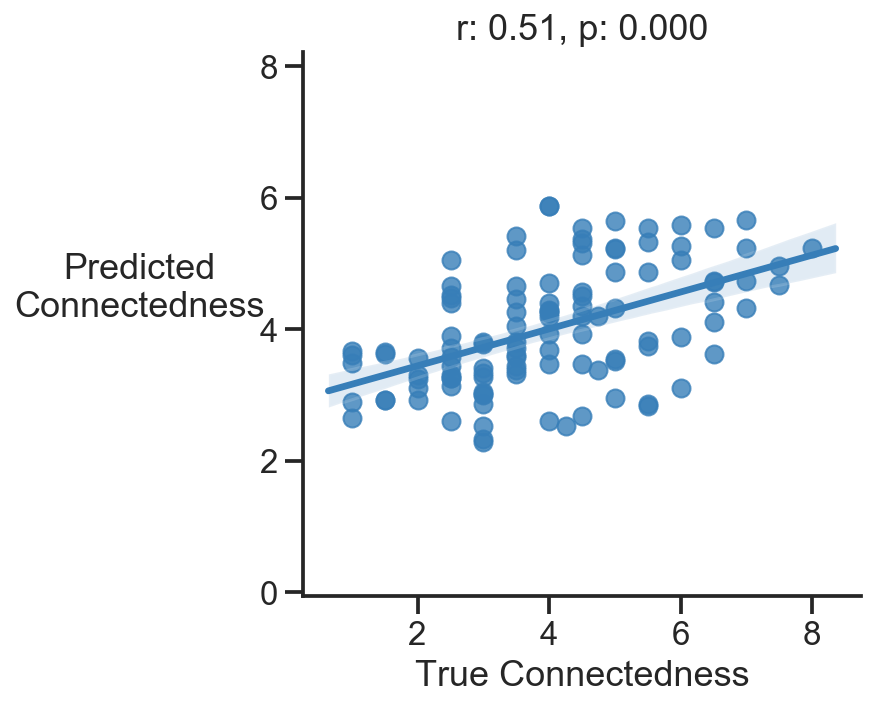

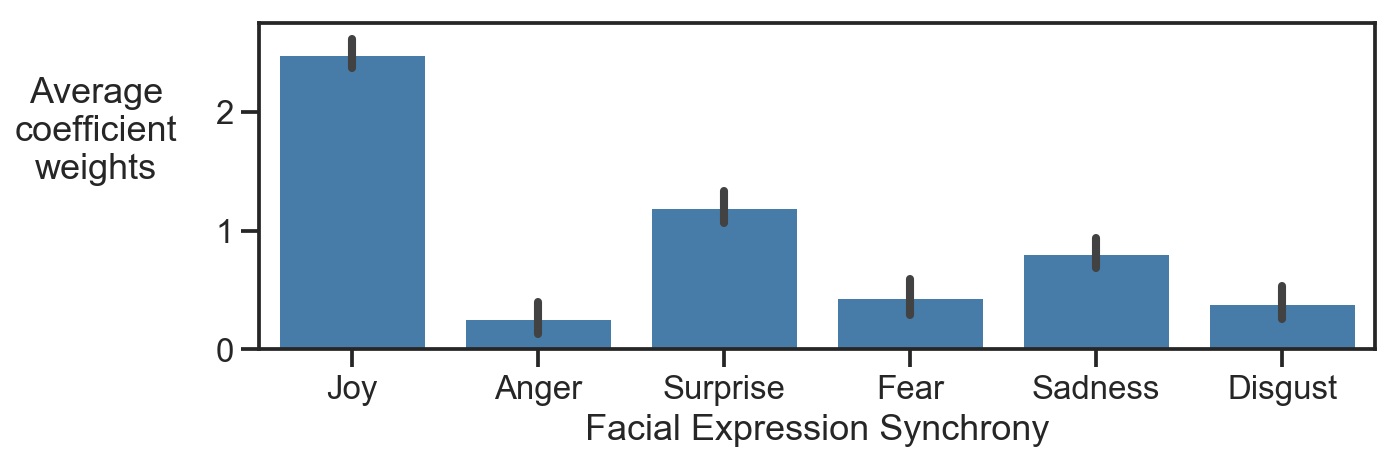

In [7]:
# prepare dataframe. 
import pandas as pd
ztransform = False
audf = pd.DataFrame()
emlist = emdict_dyad['ep01'].keys()
for au in emlist:
    _audf = []
    for i, epn in enumerate(['ep01','ep02','ep03','ep04']):
        # grab diagonal of all AU correlations. 
        _audf.extend(parse_triangle(emdict_dyad[epn][au].corr(),condition='pairs'))
    audf[au] =_audf
mean_synchrony_all_aus = pd.DataFrame(audf.mean(axis=1),columns=['mean_sync_all_aus'])

# Use R for Group random effect analysis 
allconns, allenjoy, allenjoy_diff, allcorrs,dyadIDs  = [],[],[],[],[]
groups = list(np.arange(0,noDyads)) * 4
epns = np.repeat(['ep01','ep02','ep03','ep04'],noDyads )
for i, epn in enumerate(['ep01','ep02','ep03','ep04']):
    allconns.extend(connection[epn])
    allenjoy.extend(enjoy[epn])
    allenjoy_diff.extend(enjoy_diff[epn])
    dyadIDs.extend(['s'+str(i).zfill(3) for i in connection[epn].index])
r_df = pd.DataFrame({'mean_Connection': allconns, 
                     'mean_Enjoy': allenjoy, 'diff_Enjoy':allenjoy_diff ,
                     'Groups':groups, 'Episode': epns, 'dyadID':dyadIDs })
if ztransform:
    r_df = pd.concat([r_df, audf, nlstats.fisher_r_to_z(mean_synchrony_all_aus)],axis=1)
else:
    r_df = pd.concat([r_df, audf, mean_synchrony_all_aus],axis=1)
r_df.columns = [col.replace(' Evidence','') for col in r_df.columns]
r_df = pd.concat([r_df,pd.get_dummies(r_df.Episode).astype('bool')],axis=1)

from sklearn.linear_model import RidgeCV
from sklearn.model_selection import LeaveOneGroupOut, LeavePGroupsOut, GroupKFold
# features = ['Joy']
features = ['Joy', 'Anger', 'Surprise', 'Fear', 'Sadness', 'Disgust']
X = r_df[features].as_matrix()
y = r_df[['mean_Connection']].values.ravel()
groups = r_df['dyadID'].values.ravel()
# logo = LeaveOneGroupOut()
logo = LeavePGroupsOut(n_groups=1)
# logo = GroupKFold(n_splits=10)

true_ys = []
predicted_ys=[]
coefs = []
eachrs = []
for train_ix, test_ix in tqdm(logo.split(X,y,groups)):
    X_train, X_test = X[train_ix], X[test_ix]
    y_train, y_test = y[train_ix], y[test_ix]
    clf = RidgeCV(alphas=[.1, 1., 10.], fit_intercept=True, normalize=False)
    clf.fit(X_train,y_train)
    coefs.append(clf.coef_)
    predicted_ys.extend(clf.predict(X_test))
    true_ys.extend(y_test)
    r1, p1 = stats.pearsonr(clf.predict(X_test),y_test)
    eachrs.append(r1)
r, p = stats.pearsonr(predicted_ys,true_ys)

_df  = pd.DataFrame({'pred':predicted_ys,'true':true_ys, #'group':np.sort(groups)
                    })
ax = sns.regplot(x='true',y='pred',data=_df,line_kws={'color':dyadcolor},scatter_kws={'color':dyadcolor})
ax.set_ylabel('Predicted\nConnectedness',rotation=0,labelpad=60)
ax.set(xlabel='True Connectedness', title=f'r: {r:.2f}, p: {p:.3f}')
sns.despine();
plt.axis('equal');

f,ax = plt.subplots(figsize=(10,3))
_df = pd.DataFrame(coefs, columns=features)
sns.barplot(x='variable',y='value',data=_df.melt(),color=dyadcolor, ci='sd')
# sns.stripplot(x='variable',y='value',data=_df.melt(), color='k',alpha=1, s=3)

ax.set_xticklabels(features,rotation=0)
ax.set_ylabel('Average\ncoefficient\nweights',rotation=0,labelpad=60)
ax.set_xlabel('Facial Expression Synchrony');
# ax.set(ylim=[-.1,3.5])

#  Test if coefficient is different from zero
# print('Testing if coefficients are significant from 0',stats.ttest_1samp(coefs,0))

# SRM analyses
## Figure 3-a. Spatial similarity comparison between groups for feature 0 & 1. 

In [27]:
fex_dir = os.path.join('../../Data/FEX/downsampled_na_1/')
fex_list = np.sort(glob.glob(os.path.join(fex_dir,'*dyad*')))

rating_file = os.path.join('../../Data/Ratings/FilteredData/20171101char_combined.csv')
beh_dat = pd.read_csv(rating_file)

alone_sublist = [ 's022', 's023', 's024', 's025',
       's026', 's027', 's028', 's029', 's030', 's031', 's032', 's033', 's034',
       's035', 's036', 's037', 's038', 's039', 's040', 's041','s042']

# Retrieve rating data.
dyad_file = os.path.join('../../Data/Ratings/FilteredData/20171029_fnldyad_chartrans_dat.csv')

all_dyads = set(np.arange(71,103,1))
# 82, 86 excluded b/c more than 10% missing values. 90, 91 excluded b/c didn't return for second half.
dyads_to_exclude = set([90, 91, 82, 86]) 
dyads = list(all_dyads-dyads_to_exclude)
noDyads = len(dyads)
connection,connection_diff, enjoy,enjoy_diff,dyads_dat = load_dyad_df(dyad_file, dyads = dyads)

# names for dyads to retrieve beh rating data.
alldyads= ['s'+str(_dyad).zfill(3)+'_1' for _dyad in dyads]
alldyads.extend(['s'+str(_dyad).zfill(3)+'_2' for _dyad in dyads])
alldyads =np.sort(alldyads)

# set color pallette
colors = sns.color_palette('Set1')

In [28]:
aulist = [u'AU1 Evidence', u'AU10 Evidence', u'AU12 Evidence', u'AU14 Evidence',
       u'AU15 Evidence', u'AU17 Evidence', u'AU18 Evidence', u'AU2 Evidence',
       u'AU20 Evidence', u'AU23 Evidence', u'AU24 Evidence', u'AU25 Evidence',
       u'AU26 Evidence', u'AU28 Evidence', u'AU4 Evidence', u'AU43 Evidence',
       u'AU5 Evidence', u'AU6 Evidence', u'AU7 Evidence', u'AU9 Evidence']
aulist = natsort.natsorted(aulist) 
aulist.extend([u'Joy Evidence', u'Disgust Evidence', u'Surprise Evidence', 
               u'Anger Evidence', u'Sadness Evidence', u'Fear Evidence',
               u'Positive Evidence', u'Negative Evidence'])
audict_dyad = dict.fromkeys(aulist)
nulls = pd.DataFrame()
fex_list = np.sort(glob.glob(os.path.join(fex_dir,'*dyad*')))
epns = ['ep01','ep02','ep03','ep04']
for i, epn in enumerate(epns):
    print(epn, fex_list[i])
    df = pd.read_json(fex_list[i],orient='values')
    # save for each au
    audict_dyad[epn] = {}
    for au in aulist:
        audict_dyad[epn][au] = df[[au]].apply(lambda x: pd.Series(x[au]),axis=1)
    # Calculate missing data percentage for each subject. 
    nulls = pd.concat([nulls, pd.DataFrame(audict_dyad[epn][au].isnull().sum()/audict_dyad[epn][au].shape[0]).T])
nulls.index = epns

#remove dyads that have lost face. 
for i, epn in enumerate(epns):
    for au in aulist:
        for dy_excl in list(dyads_to_exclude):
            try:
                audict_dyad[epn][au] = audict_dyad[epn][au].drop('s' +str(dy_excl).zfill(3)+'_1',axis=1)
                audict_dyad[epn][au] = audict_dyad[epn][au].drop('s' +str(dy_excl).zfill(3)+'_2',axis=1)
            except:
                pass
#                 print('check dyad ' + str(dy_excl) + ' is in data. ')        

audict_solo = dict.fromkeys(aulist)
nulls = pd.DataFrame()
fex_list = np.sort(glob.glob(os.path.join(fex_dir,'*ctrl*')))
epns = ['ep01','ep02','ep03','ep04']
for i, epn in enumerate(epns):
    print(epn, fex_list[i])
    df = pd.read_json(fex_list[i],orient='values')
    # save for each au
    audict_solo[epn] = {}
    for au in aulist:
        audict_solo[epn][au] = df[[au]].apply(lambda x: pd.Series(x[au]),axis=1)
    nulls = pd.concat([nulls, pd.DataFrame(audict_solo[epn][au].isnull().sum()/audict_solo[epn][au].shape[0]).T])
nulls.index = epns

# Create Dict with standardized features for each column of each subject for each group. 
# Note that to do out of sample prediction, standardized need to be split too.
# Creates au_standardized_solo, au_standardized_dyad, and au_standardized_allsubs
epns = ['ep01','ep02','ep03','ep04']
au_standardized_solo={}
au_standardized_dyad={}
au_standardized_allsubs = {}
_onecolforcolname = aulist[0]
for epn in epns: 
    one_sub = pd.DataFrame()
    all_subs_solo = []
    cols = []
    for sub in audict_solo[epn][_onecolforcolname].columns:
        one_sub = pd.DataFrame()
        for key in audict_solo[epn].keys():
            cols.append(key)
            one_sub = pd.concat([one_sub, audict_solo[epn][key][sub]],axis=1)      
        one_sub = (one_sub - one_sub.mean())/one_sub.std()
#         all_subs_solo.append(one_sub.fillna(0).as_matrix().T)
        # linear interpolate 
        all_subs_solo.append(one_sub.interpolate(method='linear', axis=0, limit_direction='both').as_matrix().T)
    au_standardized_solo[epn] = all_subs_solo
        
    one_sub = pd.DataFrame()
    all_subs_dyad = []
    cols = []
    for sub in audict_dyad[epn][_onecolforcolname].columns:
        one_sub = pd.DataFrame()
        for key in audict_dyad[epn].keys():
            cols.append(key)
            one_sub = pd.concat([one_sub, audict_dyad[epn][key][sub]],axis=1)
        one_sub = (one_sub - one_sub.mean())/one_sub.std()
#         all_subs_dyad.append(one_sub.fillna(0).as_matrix().T)
        all_subs_dyad.append(one_sub.interpolate(method='linear', axis=0, limit_direction='both').as_matrix().T)
    all_subs = np.concatenate([all_subs_solo, all_subs_dyad])
    au_standardized_dyad[epn] = all_subs_dyad
    
    au_standardized_allsubs[epn] = np.concatenate([all_subs_solo, all_subs_dyad])

ep01 ../../Data/FEX/downsampled_na_1/group_dyad_facet_ep01_1hz_downsample.json
ep02 ../../Data/FEX/downsampled_na_1/group_dyad_facet_ep02_1hz_downsample.json
ep03 ../../Data/FEX/downsampled_na_1/group_dyad_facet_ep03_1hz_downsample.json
ep04 ../../Data/FEX/downsampled_na_1/group_dyad_facet_ep04_1hz_downsample.json
ep01 ../../Data/FEX/downsampled_na_1/group_ctrl_facet_ep01_1hz_downsample.json
ep02 ../../Data/FEX/downsampled_na_1/group_ctrl_facet_ep02_1hz_downsample.json
ep03 ../../Data/FEX/downsampled_na_1/group_ctrl_facet_ep03_1hz_downsample.json
ep04 ../../Data/FEX/downsampled_na_1/group_ctrl_facet_ep04_1hz_downsample.json


In [135]:
# combine all 4 episodes print out temporal isc for each shared response
features = 2
n_iter = 20
seed = 100
# indexing just the 20 AUs
srm_data = np.concatenate([au_standardized_allsubs[epn][:,:20,:] for epn in epns],axis=2) 
srm_both = brainiak.funcalign.srm.SRM(n_iter=n_iter, features=features, rand_seed=seed)
srm_both.fit(srm_data)

t_srm = srm_both.transform(srm_data)
for feature_i in range(features):
    sub_t_srm = np.array([sub_srm[feature_i] for sub_srm in t_srm])
    corr_t_srm = pd.DataFrame(sub_t_srm).T.corr()
    alone_t_srm = parse_triangle(corr_t_srm.iloc[:21,:21],condition='upper')
    dyad_t_srm = parse_triangle(corr_t_srm.iloc[21:,21:],condition='pairs')
    ## Use Mantel test for comparison.
    print(f'Feature {feature_i}: Alone {np.mean(alone_t_srm):.2f}', f'dyad {np.mean(dyad_t_srm):.2f}')
    t, p = stats.ttest_ind(dyad_t_srm, alone_t_srm)
    print(f"Feature {feature_i}: Dyad v Alone difference in t-ISC feature {feature_i}: t: {t:.2f}, p: {p:.3f}",)

Feature 0: Alone 0.12 dyad 0.33
Feature 0: Dyad v Alone difference in t-ISC feature 0: t: 11.11, p: 0.000
Feature 1: Alone 0.23 dyad 0.24
Feature 1: Dyad v Alone difference in t-ISC feature 1: t: 0.40, p: 0.692


In [136]:
# USE MANTEL TEST FOR SIGNIFICANCE TESTING.
random_state=1
from sklearn.utils import check_random_state
MAX_INT = np.iinfo(np.int32).max
n_samples=5000
n_jobs=-1
# combine all 4 episodes print out temporal isc for each shared response
features = 2
n_iter = 20
seed = 100
# indexing just the 20 AUs
srm_data = np.concatenate([au_standardized_allsubs[epn][:,:20,:] for epn in epns],axis=2) 
srm_both = brainiak.funcalign.srm.SRM(n_iter=n_iter, features=features,rand_seed=seed)
srm_both.fit(srm_data)

t_srm = srm_both.transform(srm_data)
for feature_i in range(features):
    sub_t_srm = np.array([sub_srm[feature_i] for sub_srm in t_srm])
    corr_t_srm = pd.DataFrame(sub_t_srm).T.corr()
    alone_t_srm = parse_triangle(corr_t_srm.iloc[:21,:21],condition='upper')
    dyad_t_srm = parse_triangle(corr_t_srm.iloc[21:,21:],condition='pairs')
    # r_diff to compare against distribution.
    r_diff = np.mean(dyad_t_srm)-np.mean(alone_t_srm) 
    
    random_state = check_random_state(random_state)
    seeds = random_state.randint(MAX_INT, size=n_samples)
    data_row_id = range(corr_t_srm.shape[0])
    diffs_pairs_alone, diffs_nonpairs_alone, diffs_pairs_nonpairs =[],[],[]
    for i in range(n_samples):
        # matrix permutation, shuffle the groups
        ix = random_state.choice(data_row_id,
                           size=len(corr_t_srm),
                           replace=False) 
        new_dat = corr_t_srm.iloc[ix,ix]
        new_dyad = new_dat.iloc[21:,21:]
        new_alone = new_dat.iloc[:21,:21]
        
        diffs_pairs_alone.append(np.mean(parse_triangle(new_dyad))-np.mean(parse_triangle(new_alone)) )
                              
    ## Use Mantel test for comparison.
    mantel_p = nlstats._calc_pvalue(np.array(diffs_pairs_alone), r_diff, tail=2)
    print(f'Feature {feature_i}: Alone {np.mean(alone_t_srm):.2f}', f'dyad {np.mean(dyad_t_srm):.2f}',f"Mantel p: {mantel_p:.3f}")
    t, p = stats.ttest_ind(dyad_t_srm, alone_t_srm)
    print(f"Feature {feature_i}: Dyad v Alone difference in t-ISC feature {feature_i}: t: {t:.2f}, p: {p:.3f}",)

Feature 0: Alone 0.12 dyad 0.33 Mantel p: 0.000
Feature 0: Dyad v Alone difference in t-ISC feature 0: t: 11.11, p: 0.000
Feature 1: Alone 0.23 dyad 0.24 Mantel p: 0.790
Feature 1: Dyad v Alone difference in t-ISC feature 1: t: 0.40, p: 0.692


In [137]:
# Calculate mean synchrony across all 4 episodes.
for emotion in ['Positive Evidence', 'Negative Evidence']:
    dyad_em_df = pd.DataFrame()
    solo_em_df = pd.DataFrame()
    for epn in epns:
        dyad_em_df = pd.concat([dyad_em_df, audict_dyad[epn][emotion]])
        solo_em_df = pd.concat([solo_em_df, audict_solo[epn][emotion]])
    print(f'Alone {emotion}: {np.mean(parse_triangle(solo_em_df.corr(),condition="upper")):.2f}')
    print(f'Dyad {emotion} : {np.mean(parse_triangle(dyad_em_df.corr(),condition="pairs")):.2f}')

Alone Positive Evidence: 0.07
Dyad Positive Evidence : 0.23
Alone Negative Evidence: 0.01
Dyad Negative Evidence : 0.04


## Fit SRM for each episode for episode level prediction.

/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


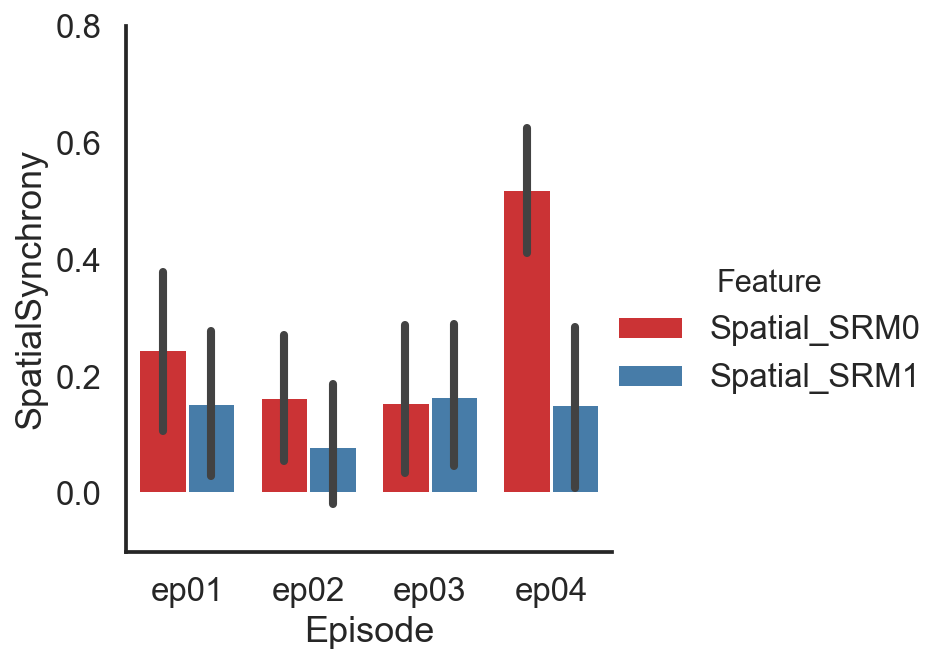

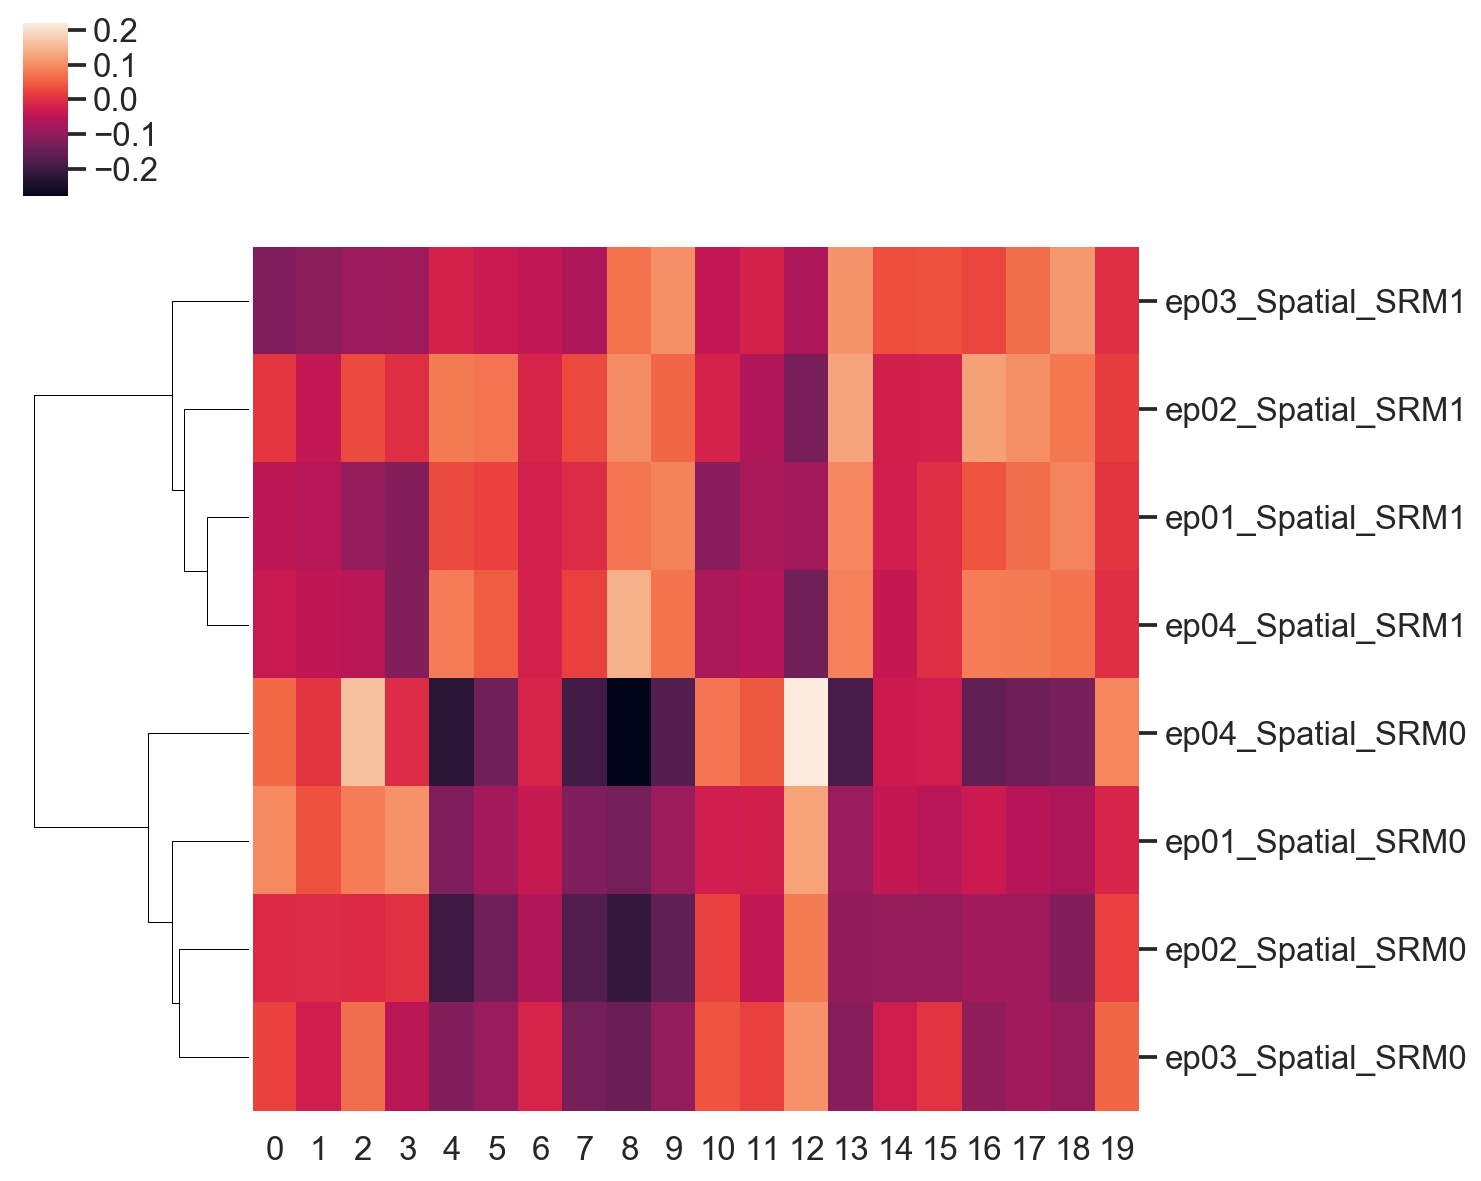

In [171]:
# Fit SRM for each episode
features = 2
n_iter = 20
seed = 100
exclude_friends = False
emotions = ['Positive Evidence','Negative Evidence']
emotions = ['Anger','Disgust','Fear','Joy','Sadness','Surprise']

wsimdf = pd.DataFrame()
wsimdf_avg = pd.DataFrame()

tsimdf = pd.DataFrame()
srms_per_episode = {}
epns = [f'ep0{i}' for i in np.arange(1,5,1)]
for epn in epns:
    srm_data  = au_standardized_allsubs[epn][:,:20,:] # Just use 20 aus
    srm_both = brainiak.funcalign.srm.SRM(n_iter=n_iter, features=features,rand_seed=seed)
    srm_both.fit(srm_data)
    srms_per_episode[epn]=srm_both
    t_srm = np.array(srm_both.transform(srm_data))
    _wsimdf = pd.DataFrame()
    for feature_i in range(features):
        wsims = parse_triangle(pd.DataFrame([w[:,feature_i] for w in srm_both.w_]).T.corr().iloc[21:, 21:],condition='pairs')
        _wsimdf = pd.concat([_wsimdf ,pd.DataFrame({f'Spatial_SRM{feature_i}': wsims})], axis=1)
    _wsimdf['Episode'] = epn
    # concat spatial
    wsimdf = pd.concat([wsimdf, _wsimdf],axis=0)
    wsimdf_avg = pd.concat([wsimdf_avg, pd.DataFrame(np.mean(srm_both.w_,axis=0) , columns=[f'{epn}_Spatial_SRM0',f'{epn}_Spatial_SRM1'])], axis=1)
    # concat temporal
    tsimdf = pd.concat([tsimdf, pd.DataFrame({f'Temporal_SRM0': parse_triangle(np.corrcoef(t_srm[:,0,:])[21:, 21:], condition='pairs'),
                        f'Temporal_SRM1': parse_triangle(np.corrcoef(t_srm[:,1,:])[21:, 21:], condition='pairs'),
                        'Episode':epn, })])
wsimdf_long = wsimdf.melt(var_name='Feature',value_name='SpatialSynchrony',id_vars=['Episode'])
sns.catplot(x='Episode',y='SpatialSynchrony',hue='Feature',data=wsimdf_long,kind='bar',ci=95)
plt.ylim([-.1,.8])
# show that each average spatial weights of each SRM is well matched acrossed episodes 
# This allows us to consider SRM0s to be same and SRM1s to be the same. 
sns.clustermap(wsimdf_avg.T,col_cluster=False)

In [172]:
_dyad_list = np.tile(np.sort(np.unique([int(dyad.split('_')[0].split('s')[1] )for dyad in audict_dyad[epn][_onecolforcolname].columns])),4)

In [174]:
from scipy.signal import detrend
from statsmodels.tsa.tsatools import detrend

### Figure 4A

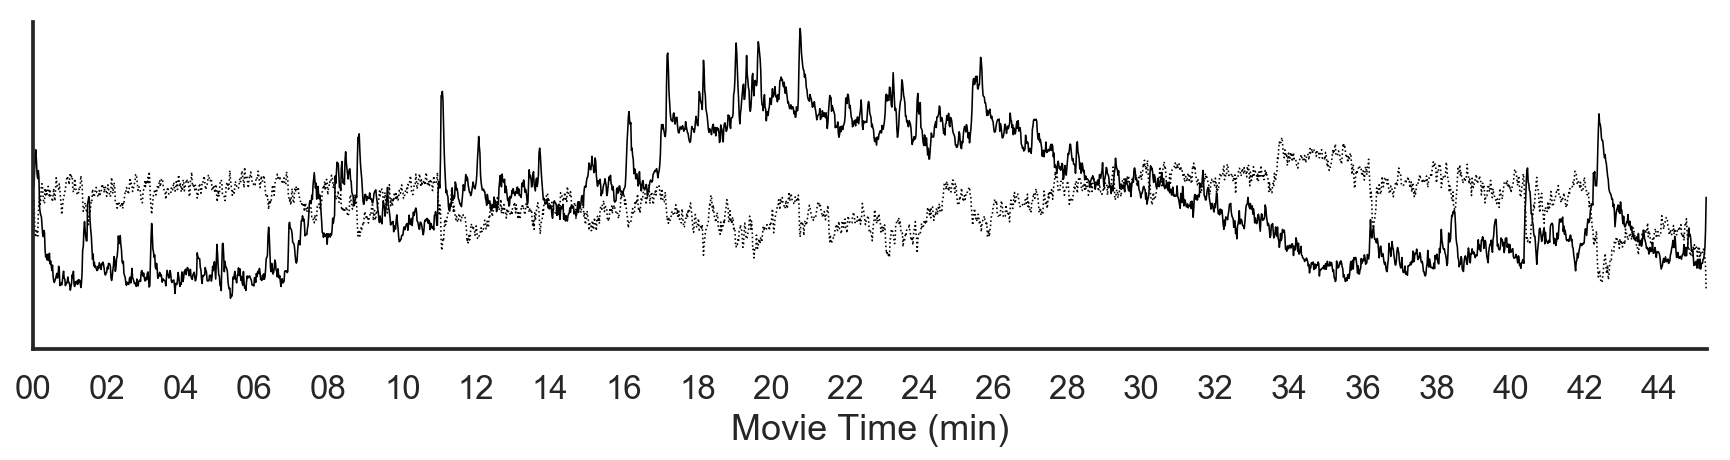

In [176]:
f,ax = plt.subplots(figsize=(15,3))
for srm_no in srm_no_dict.keys():
    emotion_to_plot = srm_no_dict[srm_no]['emotion_to_plot']
    color = srm_no_dict[srm_no]['color']
    label = srm_no_dict[srm_no]['label']
    _srmdf = pd.DataFrame(-srms_per_episode['ep01'].s_[srm_no,:], columns=['SRM'])
    # detrend
    _srm = detrend(_srmdf, order=order)
        
    # scale
    _tempdf = pd.concat([dm, _srm/_srm.std()],axis=1)

    ax.plot(_srm, color='k', linewidth=.8, linestyle=srm_no_dict[srm_no]['linestyle'])
    ax.plot([0,0],[0,0],alpha=1,color=color)
    ax.set_yticklabels([])
    ax.set_xlabel('Movie Time (min)')
    ax.set_yticks([], [])
    ax.set(xlim=[0,2718])

    #     plt.legend([label,emotion_to_plot], ncol=1,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set_yticks([], [])
    ax.set(xlim=[0,2718])
    #     _tempdf[[emotion_to_plot]].plot(ax=ax2, color=color, alpha=1, linewidth=.5)
    #     ax2.get_legend().remove()
    ax.set_yticklabels([])
    ax.set_xticks(range(0,2718,120))
    ax.set(title = '', xlim=[0,2718], xticklabels = [tick[:2] for tick in rec_to_time(ax.get_xticks(),TR=1)], ylim=[-2.5,3])
    sns.despine()

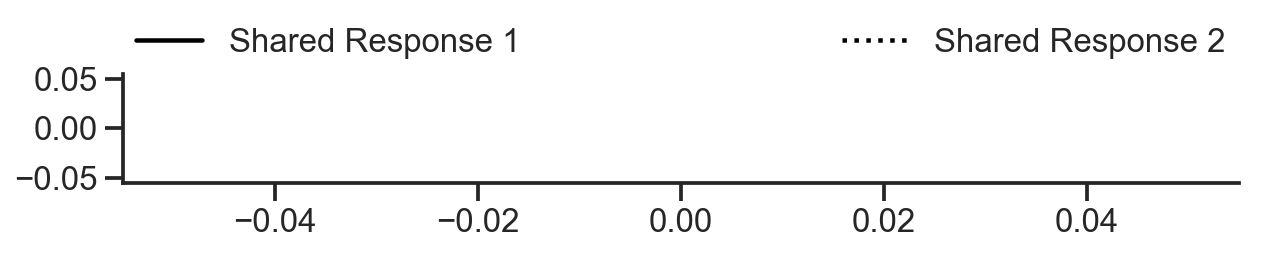

In [222]:
f,ax = plt.subplots(figsize=(10,1))
plt.plot([0,0],[0,0], linestyle='-', label='Shared Response 1', color='k')
plt.plot([0,0],[0,0], linestyle='dotted', label='Shared Response 2',color='k')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0., frameon=False)
sns.despine()

In [70]:
for epn in epns: 
    _wsimdf = wsimdf.query('Episode==@epn')
    print(f'Pos {epn} SRM0-connection',stats.spearmanr(_wsimdf.Spatial_SRM0.values, r_df.query("Episode==@epn").mean_Connection.values))
print()
for epn in epns: 
    _wsimdf = wsimdf.query('Episode==@epn')
    print(f'Neg {epn} SRM1-connection',stats.spearmanr(_wsimdf.Spatial_SRM1.values, r_df.query("Episode==@epn").mean_Connection.values))

Pos ep01 SRM0-connection SpearmanrResult(correlation=0.1856869339989001, pvalue=0.3441342084390143)
Pos ep02 SRM0-connection SpearmanrResult(correlation=-0.3086272940040804, pvalue=0.11005761700324336)
Pos ep03 SRM0-connection SpearmanrResult(correlation=0.2152302288985605, pvalue=0.2713667461449603)
Pos ep04 SRM0-connection SpearmanrResult(correlation=-0.2403437702199999, pvalue=0.21796686636048537)

Neg ep01 SRM1-connection SpearmanrResult(correlation=0.3217102006578269, pvalue=0.09503123620424873)
Neg ep02 SRM1-connection SpearmanrResult(correlation=0.0618905001345081, pvalue=0.754385028238824)
Neg ep03 SRM1-connection SpearmanrResult(correlation=-0.15255782508135515, pvalue=0.4383346928083778)
Neg ep04 SRM1-connection SpearmanrResult(correlation=0.1407963505178947, pvalue=0.4748383543859124)


# Figure 4C

/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexes/api.py:87: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  result = result.union(other)


ep01 rho :  0.39786115724578597 p :  0.036016163812628905 permuted_p 0.036392721455708855


/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


ep02 rho :  0.3578646252222002 p :  0.06151560481667059 permuted_p 0.0611877624475105
ep03 rho :  0.47279181827014566 p :  0.011061558022132661 permuted_p 0.014197160567886422
ep04 rho :  0.20624465407894726 p :  0.29235886267793404 permuted_p 0.2907418516296741


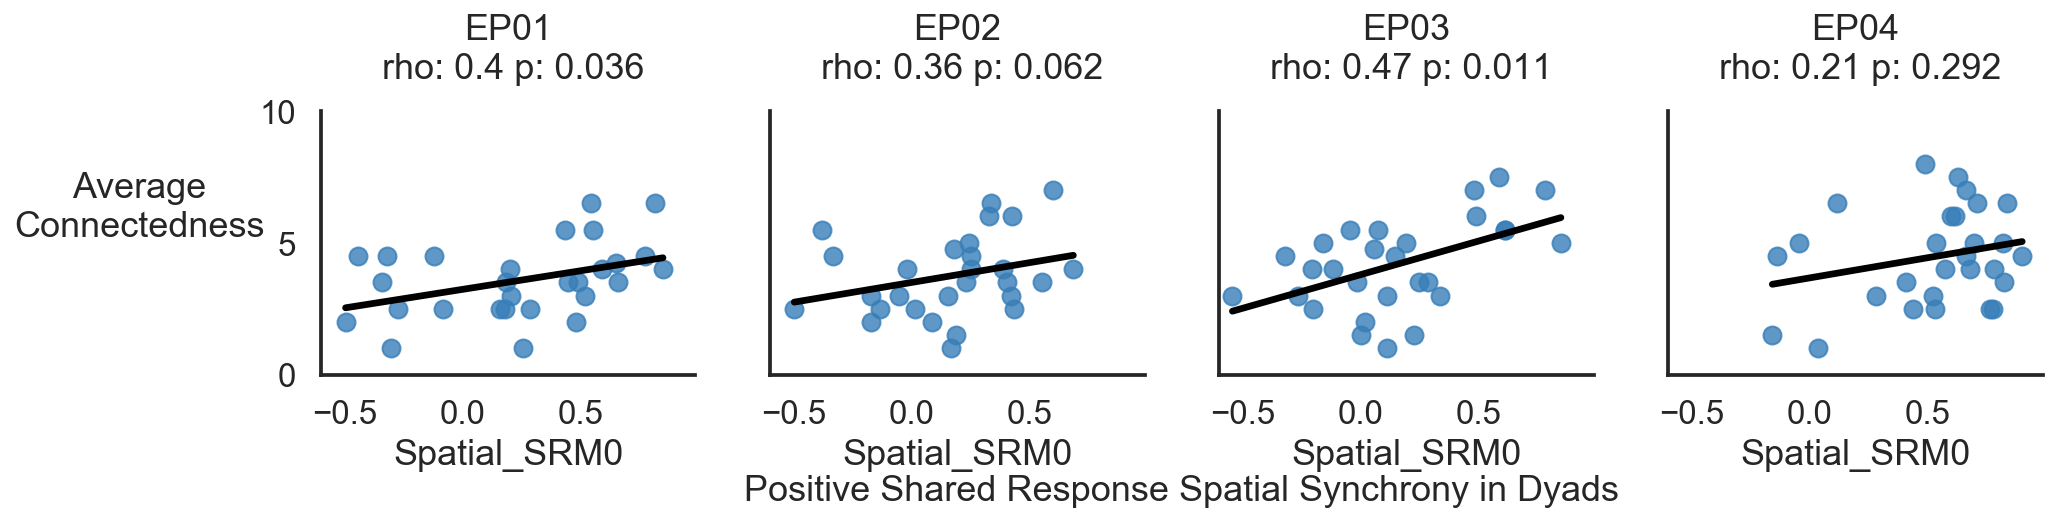

ep01 rho :  -0.08856687342295234 p :  0.6540323181933605 permuted_p 0.651869626074785
ep02 rho :  0.2621406516808277 p :  0.17779285548210869 permuted_p 0.17456508698260348
ep03 rho :  0.08521247887427043 p :  0.6663737770167031 permuted_p 0.6522695460907818
ep04 rho :  0.20349472535789462 p :  0.29898276357854925 permuted_p 0.29254149170165966


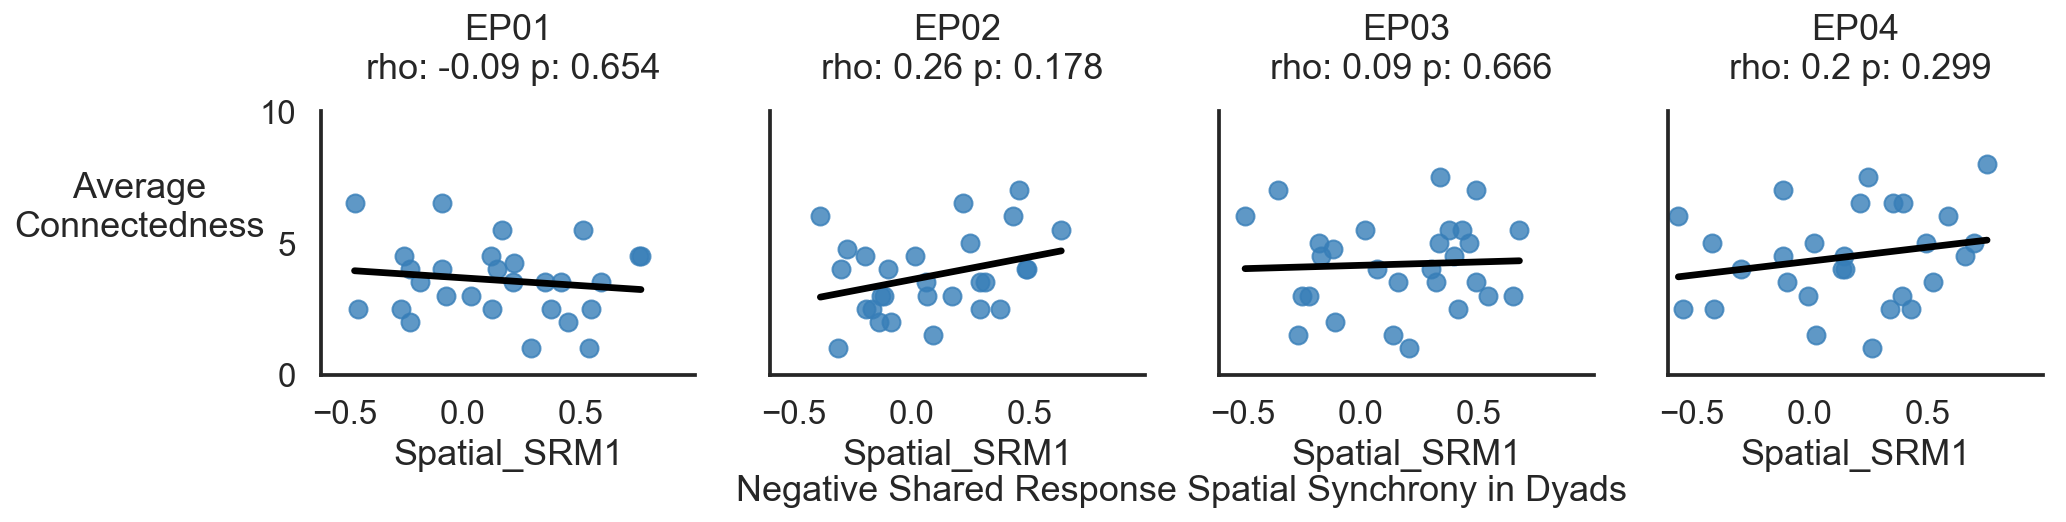

In [51]:
combined_r_df = load_combined_r_df()
_df = pd.concat([wsimdf,combined_r_df.mean_Connection])
sns.set_style('white')
exclude_friends=False
for spatial_srm, title in zip(['Spatial_SRM0', 'Spatial_SRM1'],['Positive', 'Negative']):
    f,ax = plt.subplots(1,len(epns),figsize=(15,5),sharex=True,sharey=True)
    ax[0].set_ylim([0,10])
    ax[0].set_xlim([-.6,.99])
    rdf = pd.DataFrame()
    epns=['ep01','ep02','ep03','ep04']
    for i, epn in enumerate(epns):
        dyadcorr = _df.query('Episode==@epn')[spatial_srm]
        dyadconn = connection[epn].values
        dyads_friends_bool = ~connection['ep01'].index.isin(dyads_friends)
        if exclude_friends:
            # Results similar for both episode 1&2
            dyadcorr = dyadcorr[dyads_friends_bool]
            dyadconn = dyadconn[dyads_friends_bool]
        r, p = stats.spearmanr(dyadconn, dyadcorr)
        rs = []
        permuteidx = range(len(dyadcorr))
        rs = [stats.spearmanr(dyadcorr.values[np.random.permutation(permuteidx)], dyadconn)[0] for permute_i in range(5000)]
        permuted_p = nlstats._calc_pvalue(rs, r, tail=2)

        print(epn, 'rho : ',r,'p : ',p, 'permuted_p', permuted_p)
        ax[i].set_title(epn.upper()+'\n rho: '+ str(np.round(r,2))  +' p: ' + str(np.round(p,3)),y=1.08)
        sns.regplot(y = dyadconn,x = dyadcorr,ax=ax[i],color='k',ci=False,truncate=True,scatter_kws={'color':colors[1]})

    ax[0].set_ylabel('Average\nConnectedness',rotation=0,labelpad=60)
    # for common label
    f.add_subplot(111, frameon=False)
    # plt.tick_params(which='both',labelcolor='none', top='off', bottom='off', left='off', right='off')
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.grid(False)
    plt.xlabel(f'{title} Shared Response Spatial Synchrony in Dyads',rotation=0,labelpad=50)
    sns.despine()
    plt.tight_layout()
    # f.savefig('Figures/Synchrony_corr_connectedness.pdf',dpi=300)
    plt.show()

In [48]:
wsimdf.to_csv('SpatialSimilarityForEachEpisode.csv', index=False)
tsimdf.to_csv('TemporalSimilarityForEachEpisode.csv', index=False)

In [198]:
srm_both_ws = []
for epn in epns:
    print(epn)
    srm_data  = au_standardized_allsubs[epn][:,:20,:] # Just use 20 aus
    srm_both = brainiak.funcalign.srm.SRM(n_iter=n_iter, features=features,rand_seed=seed)
    srm_both.fit(srm_data)
    srm_both_ws.append(srm_both.w_)
    spatialsimilarities0 = parse_triangle(np.corrcoef(np.array(srm_both.w_)[:,:,0]), condition='pairs')
    print(f'{epn} Spatial SRM0 Similarity Significance', stats.ttest_1samp(spatialsimilarities0,0))
    spatialsimilarities1 = parse_triangle(np.corrcoef(np.array(srm_both.w_)[:,:,1]), condition='pairs')
    print(f'{epn} Spatial SRM1 Similarity Significance', stats.ttest_1samp(spatialsimilarities1,0))
    print('Difference Between SRMs ', stats.ttest_1samp(spatialsimilarities0-spatialsimilarities1,0))

ep01
ep01 Spatial SRM0 Similarity Significance Ttest_1sampResult(statistic=2.2754290132114887, pvalue=0.028765422832704283)
ep01 Spatial SRM1 Similarity Significance Ttest_1sampResult(statistic=1.8019863148464474, pvalue=0.07969976102401174)
Difference Between SRMs  Ttest_1sampResult(statistic=-0.06980444550737135, pvalue=0.944725224703703)
ep02
ep02 Spatial SRM0 Similarity Significance Ttest_1sampResult(statistic=1.3255190259183938, pvalue=0.19312566482210644)
ep02 Spatial SRM1 Similarity Significance Ttest_1sampResult(statistic=1.127174963494547, pvalue=0.2669255976133789)
Difference Between SRMs  Ttest_1sampResult(statistic=0.21689990148332003, pvalue=0.8294779229602199)
ep03
ep03 Spatial SRM0 Similarity Significance Ttest_1sampResult(statistic=1.2798877562118682, pvalue=0.20855164791329717)
ep03 Spatial SRM1 Similarity Significance Ttest_1sampResult(statistic=1.6440391547186626, pvalue=0.1086398275494612)
Difference Between SRMs  Ttest_1sampResult(statistic=-0.0024847663035954164, 

/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


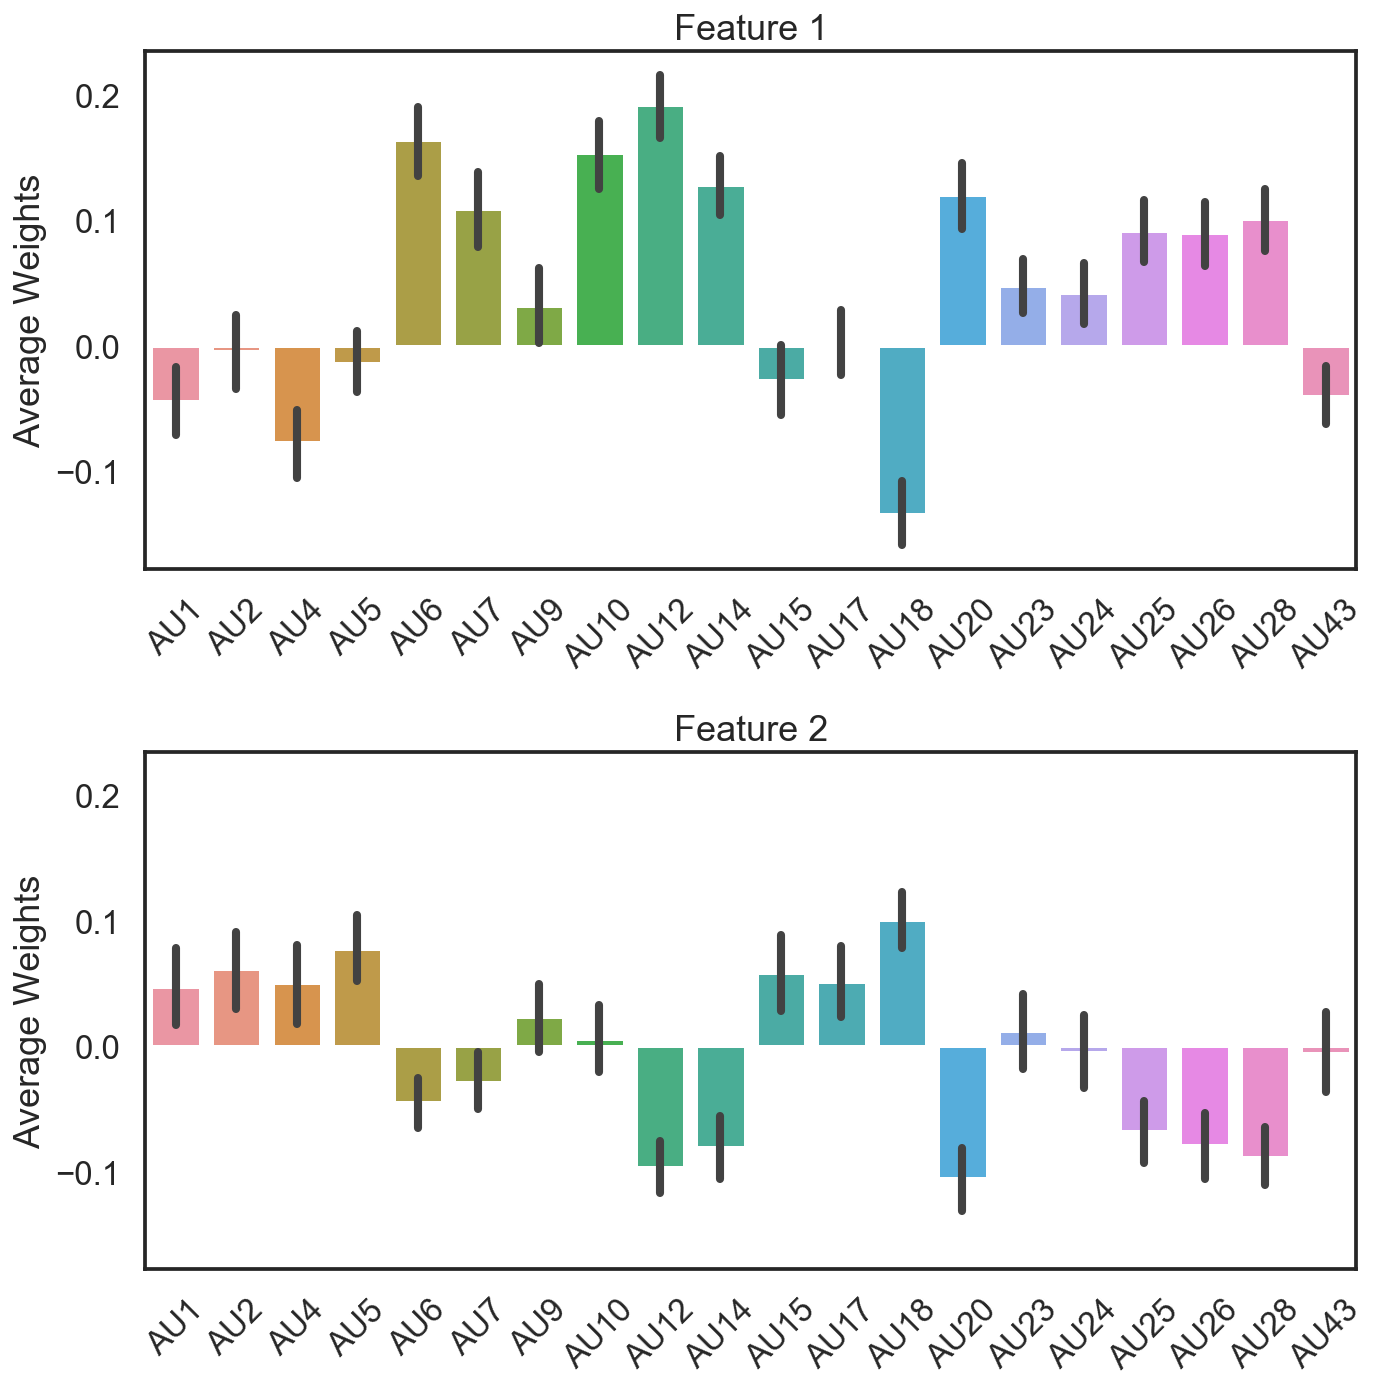

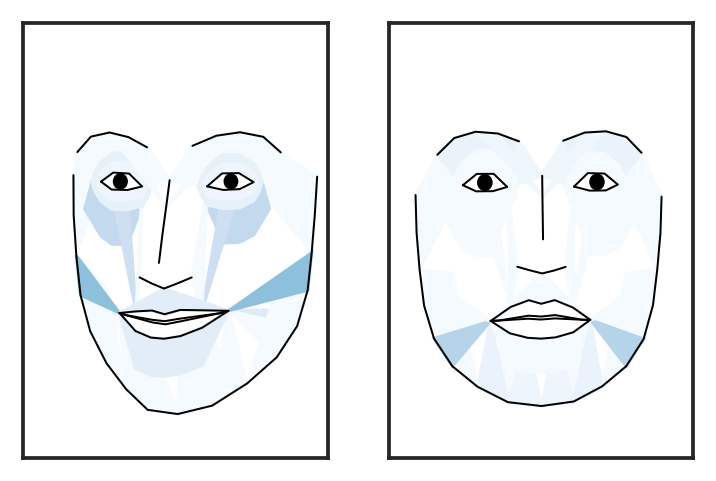

In [199]:
srm_both_average = np.mean(srm_both_ws,axis=0)

sns.set_context('talk')
au_list = [au.split(' ')[0] for au in aulist if 'AU' in au]
f, axes = plt.subplots(2,1,figsize=(10,10),sharey=True)
w1 = -1*np.array([w[:,0] for w in srm_both_average])
sns.barplot(data=w1,ci=95,ax=axes[0])
w2 = -1*np.array([w[:,1] for w in srm_both_average])
sns.barplot(data=w2, ci=95,ax=axes[1])
axes[0].set(xticklabels=au_list,ylabel='Average Weights', title='Feature 1')
axes[0].set_xticklabels(au_list,rotation=45)
axes[1].set(xticklabels=au_list,ylabel='Average Weights', title='Feature 2')
axes[1].set_xticklabels(au_list,rotation=45)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1,2,figsize=(6,4))
muscles = {'all': 'heatmap'}
wmean = 300*np.mean(w1,axis=0)**3
wmean[wmean<0] = 0
plot_face(model=None, ax= axes[0], au = wmean, muscles = muscles,color = 'k',linewidth=1,)
wmean = 1500*np.mean(w2,axis=0)**3
wmean[wmean<0] = 0
plot_face(model=None, ax= axes[1], au = wmean, muscles = muscles,color = 'k',linewidth=1)
plt.show()

## Figure 4B

<function matplotlib.pyplot.tight_layout>

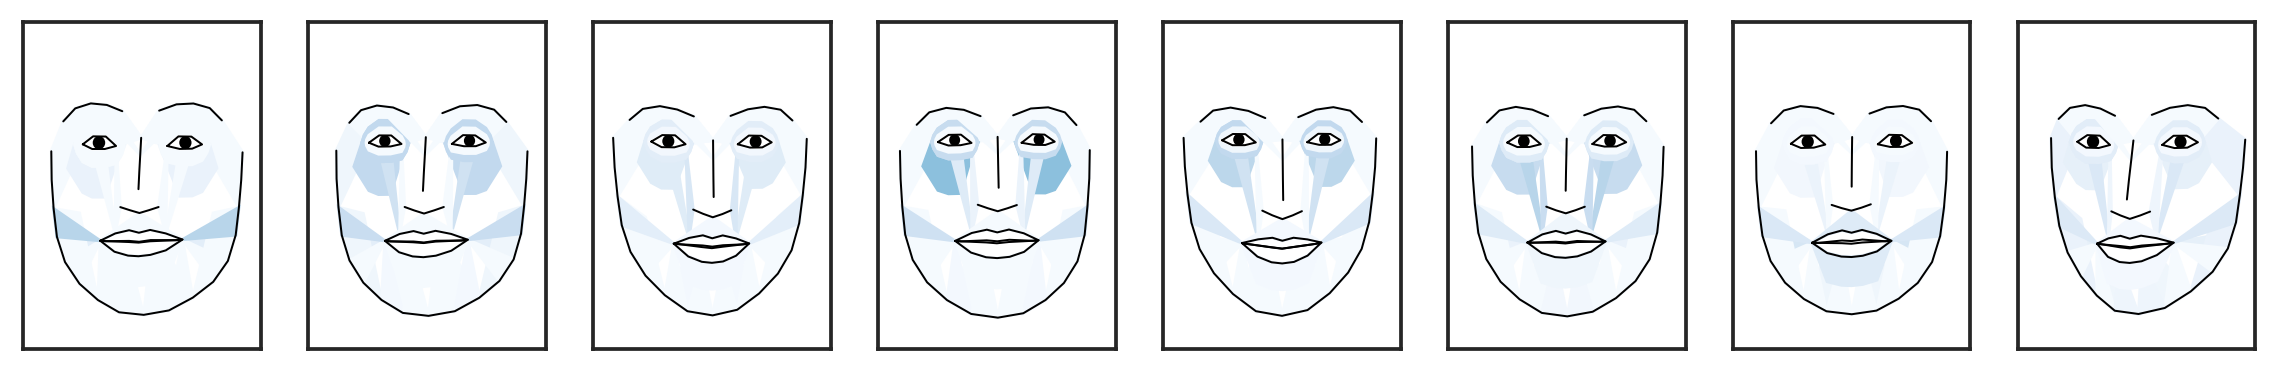

In [132]:
fig, axes = plt.subplots(1,8,figsize=(20,3))
muscles = {'all': 'heatmap'}
wmean = 30*(w1**3)
wmean[wmean<0] = 0
plot_face(model=None, ax= axes[0], au = wmean[28,:], muscles = muscles,color = 'k',linewidth=1,)
plot_face(model=None, ax= axes[1], au = wmean[37,:], muscles = muscles,color = 'k',linewidth=1,)
plot_face(model=None, ax= axes[2], au = wmean[48,:], muscles = muscles,color = 'k',linewidth=1,)
plot_face(model=None, ax= axes[3], au = wmean[58,:], muscles = muscles,color = 'k',linewidth=1,)
plot_face(model=None, ax= axes[4], au = wmean[34,:], muscles = muscles,color = 'k',linewidth=1,)
plot_face(model=None, ax= axes[5], au = wmean[41,:], muscles = muscles,color = 'k',linewidth=1,)
plot_face(model=None, ax= axes[6], au = wmean[54,:], muscles = muscles,color = 'k',linewidth=1,)
plot_face(model=None, ax= axes[7], au = wmean[75,:], muscles = muscles,color = 'k',linewidth=1,)
# wmean = 1500*(w2)**3
# wmean[wmean<0] = 0
# plot_face(model=None, ax= axes[1], au = wmean, muscles = muscles,color = 'k',linewidth=1)
# plt.show()

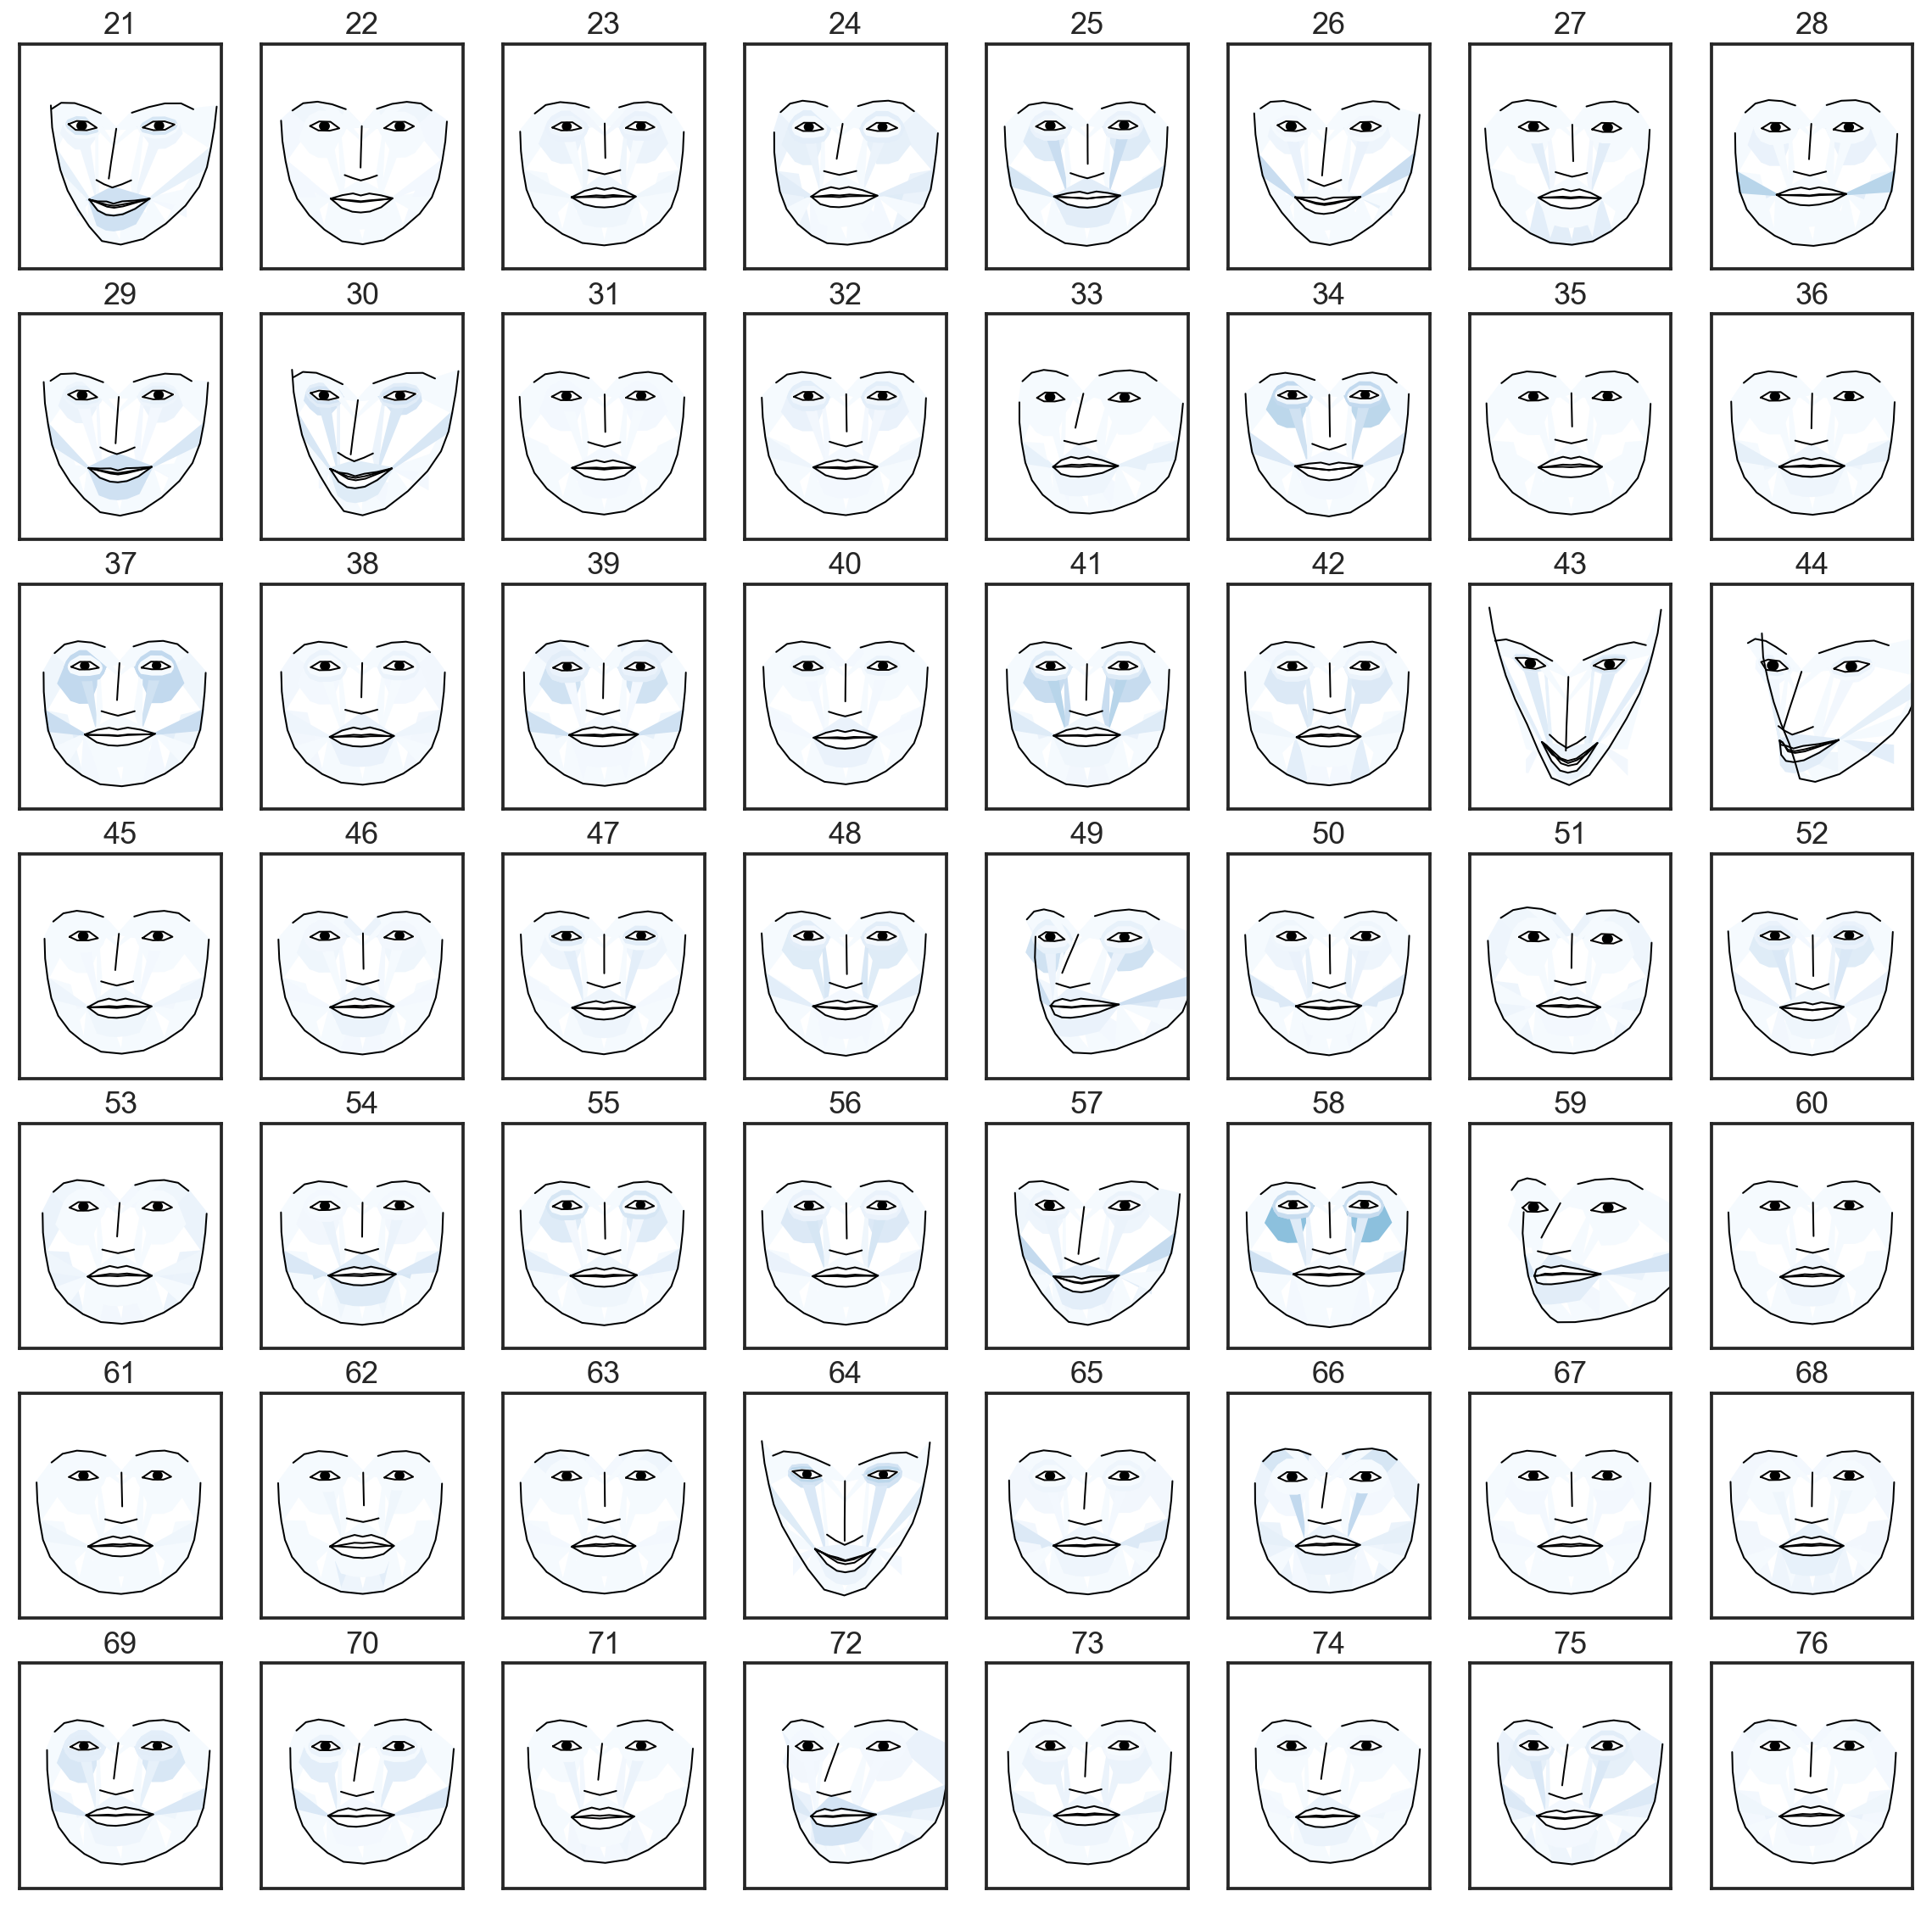

In [129]:
# Plot all positive subject faces
wmean = 30*(w1**3)
wmean[wmean<0] = 0
f,axes = plt.subplots(7,8, figsize=(20,20))
axes = axes.flatten()
for ix,i in enumerate(range(21,77)):
    plot_face(model=None, ax= axes[ix], au = wmean[i,:], muscles = muscles,color = 'k',linewidth=1)
    axes[ix].set(title=f"{i}")

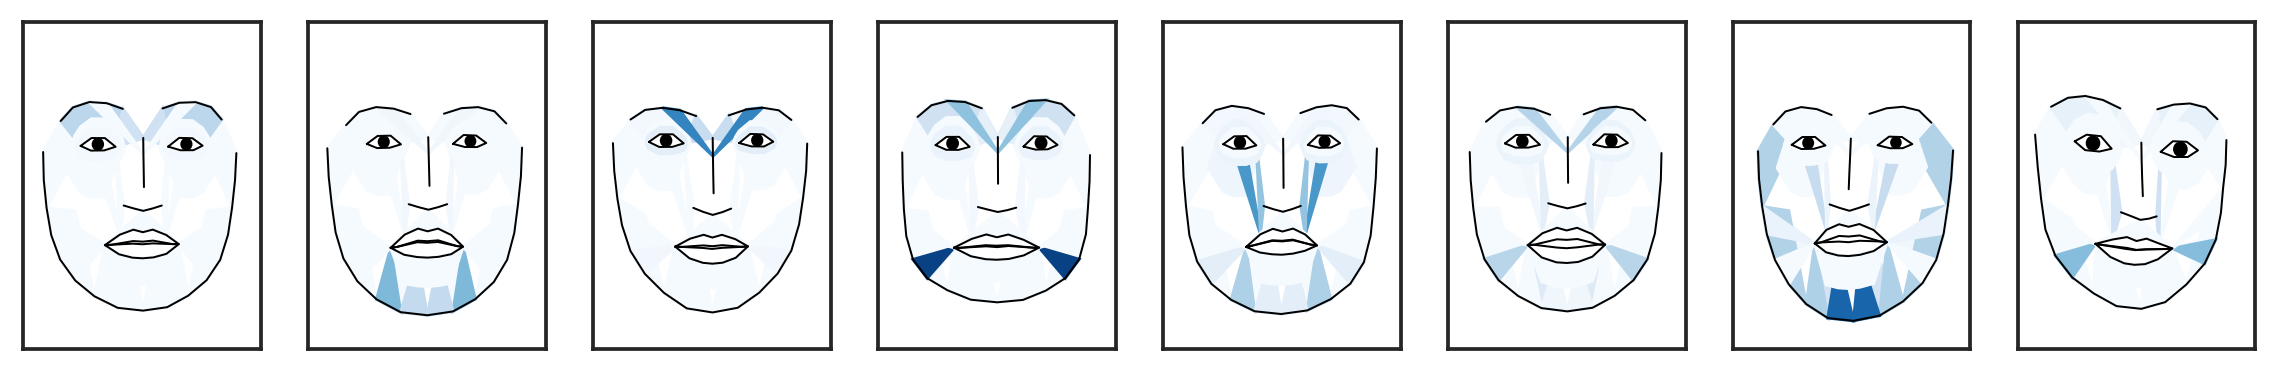

In [137]:
fig, axes = plt.subplots(1,8,figsize=(20,3))
muscles = {'all': 'heatmap'}
wmean = 100*(w2)**3
wmean[wmean<0] = 0
plot_face(model=None, ax= axes[0], au = wmean[26,:], muscles = muscles,color = 'k',linewidth=1,)
plot_face(model=None, ax= axes[1], au = wmean[49,:], muscles = muscles,color = 'k',linewidth=1,)
plot_face(model=None, ax= axes[2], au = wmean[64,:], muscles = muscles,color = 'k',linewidth=1,)
plot_face(model=None, ax= axes[3], au = wmean[75,:], muscles = muscles,color = 'k',linewidth=1,)
plot_face(model=None, ax= axes[4], au = wmean[54,:], muscles = muscles,color = 'k',linewidth=1,)
plot_face(model=None, ax= axes[5], au = wmean[57,:], muscles = muscles,color = 'k',linewidth=1,)
plot_face(model=None, ax= axes[6], au = wmean[63,:], muscles = muscles,color = 'k',linewidth=1,)
plot_face(model=None, ax= axes[7], au = wmean[68,:], muscles = muscles,color = 'k',linewidth=1,)
plt.show()

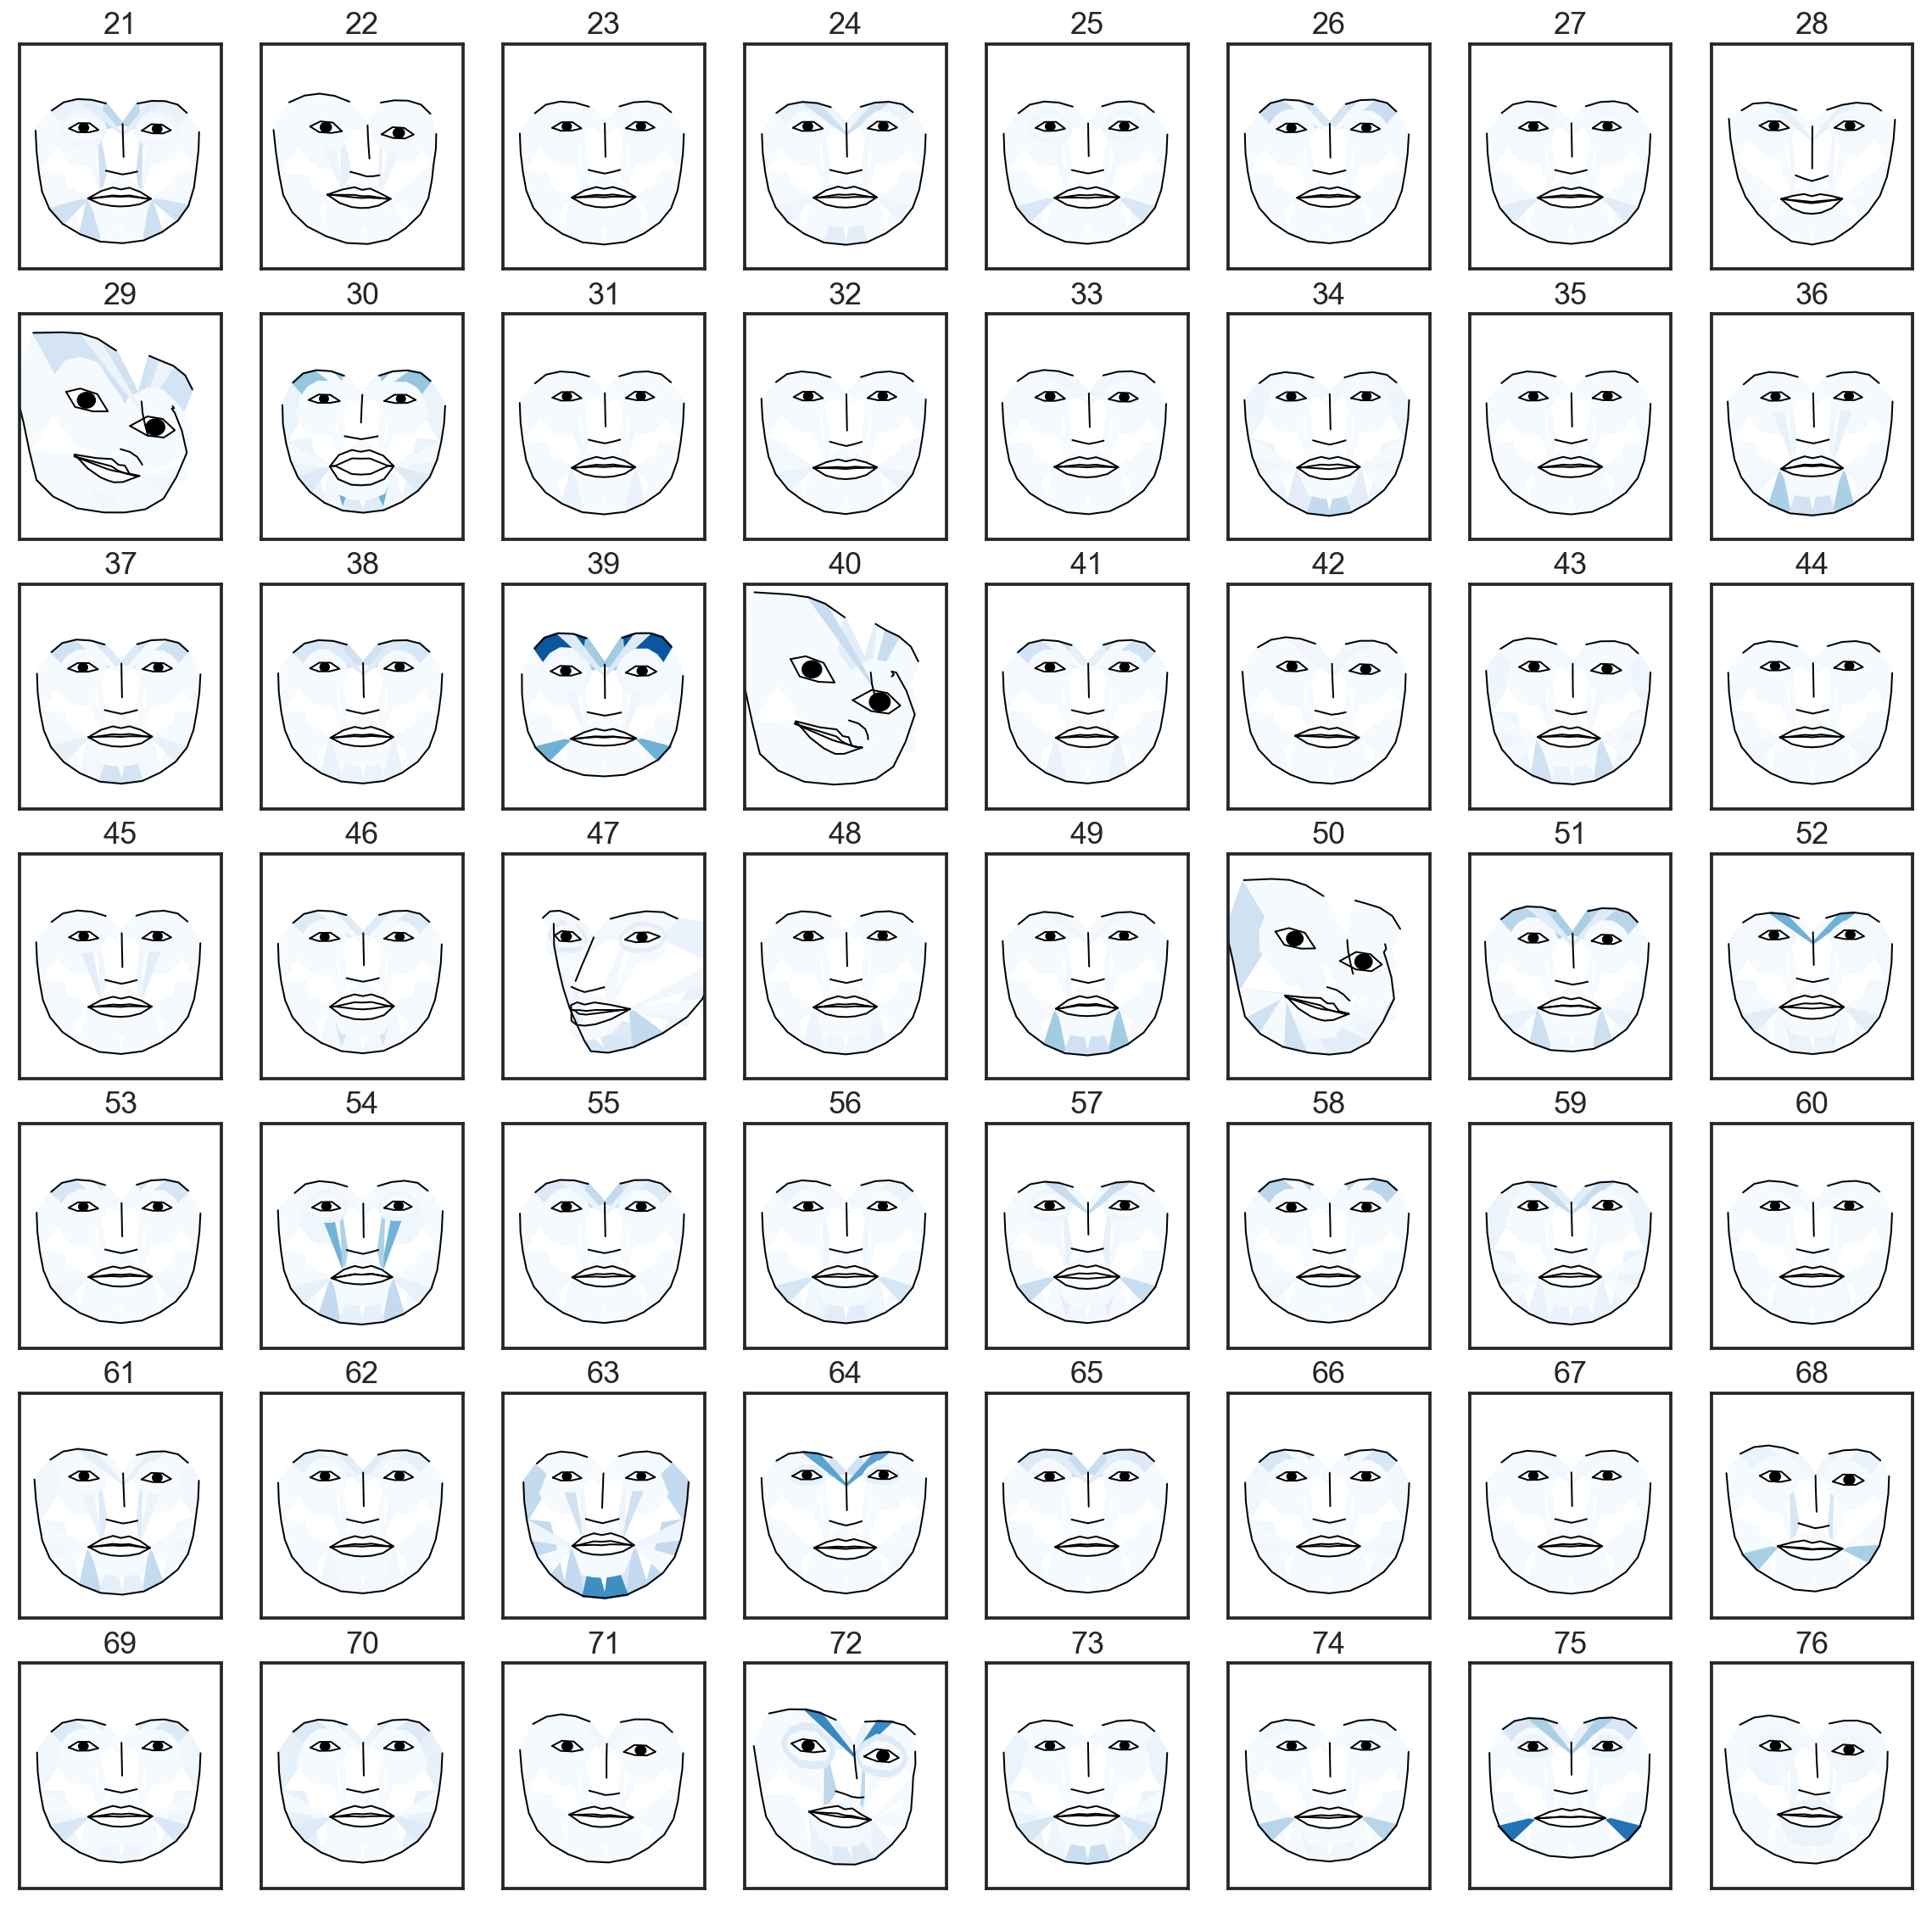

In [136]:
# Plot all negative subject faces
wmean = 80*(w2**3)
wmean[wmean<0] = 0
f,axes = plt.subplots(7,8, figsize=(20,20))
axes = axes.flatten()
for ix,i in enumerate(range(21,77)):
    plot_face(model=None, ax= axes[ix], au = wmean[i,:], muscles = muscles,color = 'k',linewidth=1)
    axes[ix].set(title=f"{i}")
plt.show()

# Impression analysis results

In [200]:
from scipy.spatial.distance import squareform, pdist
# All characters
char_list = ['BillyRiggins', 'BuddyGarrity', 'CoachTaylor', 'GrandmaSaracen',
       'JasonStreet', 'JulieTaylor', 'LandryClarke', 'LylaGarrity',
       'MattSaracen', 'SmashWilliams', 'TamiTaylor', 'TimRiggins',
       'TyraCollette']
char=char_list
dims = [u'annoy', u'like',u'attractive',u'friends',u'be',u'remind',u'relate',u'care']
# dims = [u'like']
metric_beh = 'correlation' # sqeuclidean, correlation
emotion = 'Positive Evidence'
x,y,eps,sub_row,sub_col = [],[],[],[],[]
# Single: Liking rating corr vs fex corr
rank = False
rtoz = False
alljoys_solo, alljoys_dyad = {},{}
epns = ['ep01','ep02','ep03','ep04']
for epn in epns: 
    print(emotion)
    alljoys_solo[epn] = emdict_solo[epn][emotion]
    alljoys_dyad[epn] = emdict_dyad[epn][emotion]
    
for i,epn in enumerate(epns):
    _sublist = alone_sublist
    joys = alljoys_solo[epn][_sublist].corr()
#     joys = pd.DataFrame(squareform(pdist(alljoys_solo[epn][_sublist].T,metric='correlation')))
    behs = 1-grab_pairwise_dist(beh_dat,_sublist,epn, dim=dims, char=char, metric=metric_beh)
#     behs = 1/(1+grab_pairwise_dist(beh_dat,_sublist,epn, dim=dims, char=char, metric=metric_beh))
    behs.columns= _sublist
    behs.index = _sublist
    if rank:
        x.extend(stats.rankdata(parse_triangle(joys)))
        y.extend(stats.rankdata(parse_triangle(behs)))
    elif rtoz:
        x.extend(nlstats.fisher_r_to_z(parse_triangle(joys)))
        y.extend(nlstats.fisher_r_to_z(parse_triangle(behs)))
    else:
        x.extend(parse_triangle(joys))
        y.extend(parse_triangle(behs))     
    eps.extend(np.repeat([epn],len(parse_triangle(joys))))
    df_row,df_col = grab_subIDs(behs)
    sub_row.extend(df_row)
    sub_col.extend(df_col)
r_df_sing = pd.DataFrame({'Episode':eps,'JoySim':x,'ImpSim':y,'Cond':'Alone','sub1':sub_row,'sub2':sub_col})
x,y,eps,sub_row,sub_col = [],[],[],[],[]
# Dyad nonPair: Liking rating corr vs fex corr
for i,epn in enumerate(['ep01','ep02','ep03','ep04']):
    _sublist = alldyads
    joys = alljoys_dyad[epn][_sublist].corr()
#     joys = pd.DataFrame(squareform(pdist(alljoys_dyad[epn][_sublist].T,metric='correlation')))
    behs = 1-grab_pairwise_dist(beh_dat,_sublist,epn, dim=dims, char=char, metric=metric_beh)
#     behs = 1/(1+grab_pairwise_dist(beh_dat,_sublist,epn, dim=dims, char=char, metric=metric_beh))
    behs.columns= _sublist
    behs.index = _sublist
    if rank:
        x.extend(stats.rankdata(parse_triangle(joys,condition='nonpairs')))
        y.extend(stats.rankdata(parse_triangle(behs,condition='nonpairs')))
    elif rtoz:
        x.extend(nlstats.fisher_r_to_z(parse_triangle(joys,condition='nonpairs')))
        y.extend(nlstats.fisher_r_to_z(parse_triangle(behs,condition='nonpairs')))
    else:
        x.extend(parse_triangle(joys,condition='nonpairs'))
        y.extend(parse_triangle(behs,condition='nonpairs'))        
    eps.extend(np.repeat([epn],len(parse_triangle(joys,condition='nonpairs'))))
    sub_row.extend(parse_triangle(behs.apply(lambda x:x.index),condition='nonpairs'))
    sub_col.extend(parse_triangle(behs.apply(lambda x:x.index).T,condition='nonpairs'))
r_df_np = pd.DataFrame({'Episode':eps,'JoySim':x,'ImpSim':y,'Cond':'Dyad_NP','sub1':sub_row,'sub2':sub_col})
x,y,eps,sub_row,sub_col = [],[],[],[],[]
# Dyad Pair: Liking rating corr vs fex corr
for i,epn in enumerate(['ep01','ep02','ep03','ep04']):
    _sublist = alldyads
    joys = alljoys_dyad[epn][_sublist].corr()
#     joys = pd.DataFrame(squareform(pdist(alljoys_dyad[epn][_sublist].T,metric='correlation')))
    behs = 1-grab_pairwise_dist(beh_dat,_sublist,epn, dim=dims, char=char, metric=metric_beh)
#     behs = 1/(1+grab_pairwise_dist(beh_dat,_sublist,epn, dim=dims, char=char, metric=metric_beh))
    behs.columns= _sublist
    behs.index = _sublist
    if rank:
        x.extend(stats.rankdata(parse_triangle(joys,condition='pairs')))
        y.extend(stats.rankdata(parse_triangle(behs,condition='pairs')))
    elif rtoz:
        x.extend(nlstats.fisher_r_to_z(parse_triangle(joys,condition='pairs')))
        y.extend(nlstats.fisher_r_to_z(parse_triangle(behs,condition='pairs')))
    else:
        x.extend(parse_triangle(joys,condition='pairs'))
        y.extend(parse_triangle(behs,condition='pairs'))       
    eps.extend(np.repeat([epn],len(parse_triangle(joys,condition='pairs'))))
    sub_row.extend(parse_triangle(behs.apply(lambda x:x.index),condition='pairs'))
    sub_col.extend(parse_triangle(behs.apply(lambda x:x.index).T,condition='pairs'))
r_df_p = pd.DataFrame({'Episode':eps,'JoySim':x,'ImpSim':y,'Cond':'Dyad_P','sub1':sub_row,'sub2':sub_col})

# solos, pairs, nonpairs
allr_df = pd.DataFrame()
allr_df = pd.concat([r_df_sing,r_df_np,r_df_p])
allr_df = allr_df.reset_index(drop=True)
allr_df['ImpSim_st'] = (allr_df['ImpSim']-allr_df['ImpSim'].mean())/allr_df['ImpSim'].std()
allr_df['Episode_c'] = allr_df.Episode.apply(lambda x: int(x[-1])-2.5)

Positive Evidence
Positive Evidence
Positive Evidence
Positive Evidence


In [201]:
alonedyad_df = allr_df.query('Cond!="Dyad_NP"').reset_index(drop=True)
alonedyad_df['ImpSim_dm']=alonedyad_df.ImpSim-alonedyad_df.ImpSim.mean()
alonedyad_df['JoySim_dm']=alonedyad_df.JoySim-alonedyad_df.JoySim.mean()

## multivariate impression similarity predicting connection

### Figure 5A, 5B: Impression SImilarity in PCA space

In [203]:
dims =['annoy', 'like', 'attractive', 'friends', 'be', 'remind', 'relate', 'care']

[0.550911   0.12624535 0.09826864 0.07193914 0.05117009 0.0425748
 0.03496024 0.02393075]
[0.550911   0.67715635 0.77542499 0.84736412 0.89853421 0.94110901
 0.97606925 1.        ]


/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


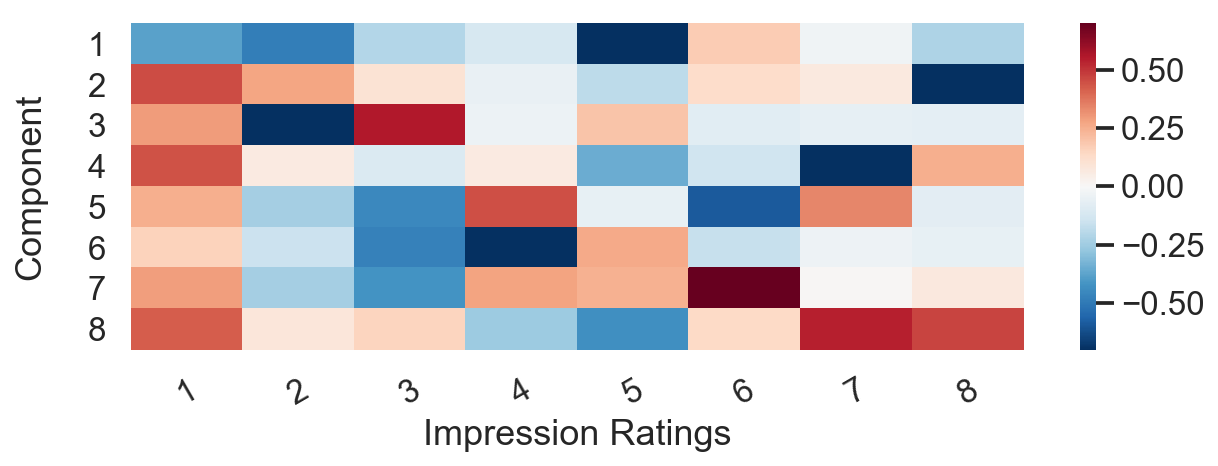

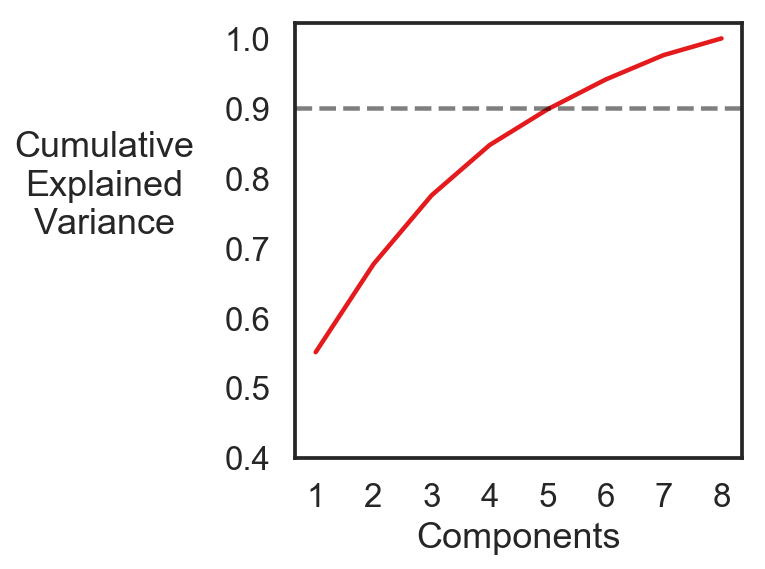

In [205]:
imp_long = pd.pivot_table(beh_dat, values=['rating'], columns=['dimension'], index=['subject_id','character','episode']).reset_index(drop=True)
# Get Dyads
X = beh_dat.pivot_table(
    index=['subject_id','character','episode'],
    columns=['dimension'],
    values='rating').loc[alldyads]

# demean per subject across episodes
X_demeaned = X - X.groupby('subject_id').mean() 
from sklearn.decomposition import PCA
n_components = 8
pca = PCA(n_components=n_components,random_state=0)
pca.fit(X_demeaned.loc[:,dims].as_matrix())
print(pca.explained_variance_ratio_)
print(np.cumsum(pca.explained_variance_ratio_))

f,ax = plt.subplots(figsize=(10,3))
sns.heatmap(-pca.components_.T, xticklabels=range(1,1+n_components), yticklabels= dims, 
            annot=False,ax=ax,fmt='.2f', cmap = 'RdBu_r', vmin=-.7, vmax=.7)
ax.set_yticklabels(range(1,1+n_components),rotation=0)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.ylabel('Component', rotation=90, labelpad=20)
plt.xlabel('Impression Ratings')
# plt.title('PCA loadings\n')
plt.show()

sns.set_style('white')
f,ax = plt.subplots(figsize=(4,4))
plt.plot(range(1,1+n_components),np.cumsum(pca.explained_variance_ratio_))
plt.axhline(.9, linestyle='--',alpha=.5, color='k')
plt.ylabel('Cumulative\nExplained\nVariance', rotation=0, labelpad=60)
ax.set(xlabel='Components',
       yticks=np.arange(.4,1.1,.1),xticks=np.arange(1,n_components+1,1))
# plt.title('Explained variance for each component\n', pad=1.08)
plt.show()

/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


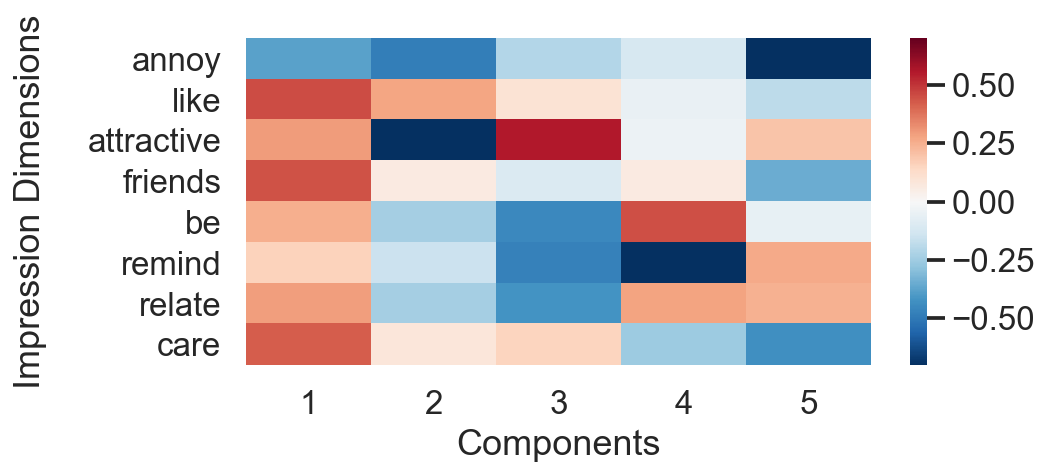

In [207]:
f,ax = plt.subplots(figsize=(7,3))
sns.heatmap(-pca.components_.T[:,:5], xticklabels=range(1,1+5), yticklabels= dims, 
            annot=False,ax=ax,fmt='.2f', cmap = 'RdBu_r', vmin=-.7, vmax=.7)
ax.set_xticklabels(range(1,1+5),rotation=0)
ax.set_yticklabels(ax.get_yticklabels(),rotation=0)
plt.ylabel('Impression Dimensions', rotation=90, labelpad=20)
plt.xlabel('Components')
# plt.title('PCA loadings\n')
plt.show()

In [208]:
'''
Calculate similarity between members of a dyad per PC dimension
'''
pca = PCA(n_components=n_components,random_state=0)
pca.fit(X_demeaned.loc[:,dims].as_matrix())
pca.components_ = -pca.components_
pcaX = pd.DataFrame(pca.transform(X_demeaned.loc[:,dims].as_matrix()))
pcaX.index = X_demeaned.index
pcaX = pcaX.reset_index()

pcadf = pd.DataFrame()
for episode in [1,2,3,4]:
    _pcadf = pd.DataFrame()
    for pc in range(n_components):
        pc_pairs = parse_triangle(pd.pivot_table(pcaX.query('episode==@episode'), values=pc, index=['subject_id'], columns='character').T.corr(), condition='pairs')
        _pcadf = pd.concat([_pcadf, pd.DataFrame(pc_pairs, columns=[pc])], axis=1)
#     _pcadf['Episode'] = f'ep0{episode}'
    pcadf = pd.concat([pcadf, _pcadf]).reset_index(drop=True)
pcadf.columns = [f"PC{i}" for i in range(n_components)]
# Attach to existing dataframe. 
# combined_r_df = pd.concat([combined_r_df, pcadf],axis=1)
# for pci in range(5):
#     combined_r_df[f'PC{pci}_dm']=combined_r_df[f'PC{pci}']-combined_r_df[f'PC{pci}'].mean()
#     combined_r_df[f'PC{pci}_st']=(combined_r_df[f'PC{pci}']-combined_r_df[f'PC{pci}'].mean())/combined_r_df[f'PC{pci}'].std()

In [ ]:
# plot correlation between connection~ and PC for every PCC 
f,ax = plt.subplots(5,4, figsize=(15,15))
ax = ax.flatten()
i=0
for pci in range(5):
    for epn in epns:
        x = combined_r_df.query('Episode==@epn')[f'PC{pci}']
        y = combined_r_df.query('Episode==@epn').mean_Connection
        r, p = stats.spearmanr(x, y)
        sns.regplot(x,y,ax=ax[i])
        ax[i].set(title=f"{epn} r:{r:.2f} p:{p:.3f}")
        i+=1
plt.tight_layout()

In [ ]:
%%R -i combined_r_df
m <- lmer('mean_Connection~PC0+PC1+PC2+PC3+PC4+(1|dyadID)', data=combined_r_df)
coef(summary(m))

m <- lmer('mean_Connection~PC0+PC1+PC2+PC3+PC4+Episode_c+(1|dyadID)', data=combined_r_df)
coef(summary(m))

In [211]:
'''
LJCHANG request: Calculate similarity between members of a dyad per character ACROSS 5PC. 
Then average into single score.
'''
num_pc_for_estimation = 5
pcadf = pd.DataFrame()
for episode in [1,2,3,4]:
    _pcadf = pd.DataFrame()
    for char in char_list:
        char_sim_pairs = parse_triangle(pd.pivot_table(pcaX.query('episode==@episode and character==@char'), 
                                                       values=range(0,num_pc_for_estimation), index=['subject_id'], 
                                                       columns='character').T.corr(), condition='pairs')
        _pcadf = pd.concat([_pcadf, pd.DataFrame(char_sim_pairs, columns=[char])], axis=1)
    pcadf = pd.concat([pcadf, pd.DataFrame(_pcadf.mean(axis=1),columns=['AvgCharSim'])]).reset_index(drop=True)
pcadf['AvgCharSim_dm'] = pcadf['AvgCharSim'] -pcadf['AvgCharSim'].mean()
pcadf['AvgCharSim_st'] = (pcadf['AvgCharSim'] -pcadf['AvgCharSim'].mean())/pcadf['AvgCharSim'].std()
combined_r_df['AvgCharSim'] = pcadf['AvgCharSim']
combined_r_df['AvgCharSim_dm'] = pcadf['AvgCharSim_dm']
combined_r_df['AvgCharSim_st'] = pcadf['AvgCharSim_st']


In [402]:
'''For ALONE subjects for comparison.
Dyad ~ Alone impression similarity not different. 
'''
# get alone data
X = beh_dat.pivot_table(
    index=['subject_id','character','episode'],
    columns=['dimension'],
    values='rating').loc[alone_sublist]
# demean per subject across episodes
X_demeaned = X - X.groupby('subject_id').mean() 

pcaX = pd.DataFrame(pca.transform(X_demeaned.loc[:,dims].as_matrix()))
pcaX.index = X_demeaned.index
pcaX = pcaX.reset_index()

pcadf = pd.DataFrame()
for episode in [1,2,3,4]:
    _pcadf = pd.DataFrame()
    for char in char_list:
        char_sim_pairs = parse_triangle(pd.pivot_table(pcaX.query('episode==@episode and character==@char'), 
                                                       values=range(0,num_pc_for_estimation), index=['subject_id'], 
                                                       columns='character').T.corr(), condition='upper')
        _pcadf = pd.concat([_pcadf, pd.DataFrame(char_sim_pairs, columns=[char])], axis=1)
    # get subID index for lmer
    forsubid = squareform(_pcadf.iloc[:,0])
    forsubid[np.diag_indices(len(forsubid))] = 1
    sub1 = parse_triangle(pd.DataFrame(forsubid).apply(lambda x: x.index),condition='upper')
    sub2 = parse_triangle(pd.DataFrame(forsubid).apply(lambda x: x.index).T,condition='upper')
    pcadf = pd.concat([pcadf, 
                       pd.concat([pd.DataFrame(_pcadf.mean(axis=1), columns=['AvgCharSim']), 
                                  pd.DataFrame({'Episode':np.repeat(f"ep0{episode}",210),
                                               'Sub1':sub1, 'Sub2':sub2 })], axis=1) ,
                       ]).reset_index(drop=True)
pcadf['AvgCharSim_dm'] = pcadf['AvgCharSim'] - pcadf['AvgCharSim'].mean()
pcadf['AvgCharSim_st'] = (pcadf['AvgCharSim'] - pcadf['AvgCharSim'].mean())/pcadf['AvgCharSim'].std()

for epn in epns:
    a = pcadf.query('Episode==@epn').AvgCharSim # alone average charsim
    b = combined_r_df.query('Episode==@epn').AvgCharSim
    t,p = stats.ttest_ind(b,a, equal_var=False)
    print(epn, t, p)

/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
/Users/jinhyuncheong/Dropbox/Packages/fnl_tools/fnl_tools/utils.py:117: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  df = df.as_matrix()


ep01 -0.345989143737158 0.7316572402929564
ep02 2.5428228316109824 0.01587470076689153
ep03 -0.4623831267474885 0.6465558373890925
ep04 1.9474710668898174 0.05963338819818861


In [ ]:
# Test if alone subjects impression similarity is also increasing
pcadf['Episode_c'] = pcadf['Episode'].apply(lambda x: int(x[-1])-2.5)
_pcadf = pcadf.copy()
_pcadf['Sub1'] = pcadf['Sub2']
_pcadf['Sub2'] = pcadf['Sub1']
pcadf = pd.concat([pcadf,_pcadf],axis=0).reset_index(drop=True)

In [404]:
%%R -i pcadf
# Test if alone subjects impression similarity is also increasing
library(lmerTest)
pcadf$Sub1 <- as.factor(pcadf$Sub1)
pcadf$Sub2 <- as.factor(pcadf$Sub2)

m <- lmer('AvgCharSim ~  Episode_c + (1+Episode_c |Sub1) + (1+Episode_c |Sub2)', data = pcadf, 
          control = lmerControl(optimizer ="Nelder_Mead"))
summary(m)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: "AvgCharSim ~  Episode_c + (1+Episode_c |Sub1) + (1+Episode_c |Sub2)"
   Data: pcadf
Control: lmerControl(optimizer = "Nelder_Mead")

REML criterion at convergence: -2214.7

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-3.075 -0.698  0.028  0.679  3.786 

Random effects:
 Groups   Name        Variance Std.Dev. Corr
 Sub1     (Intercept) 0.002645 0.0514       
          Episode_c   0.000521 0.0228   0.04
 Sub2     (Intercept) 0.002645 0.0514       
          Episode_c   0.000521 0.0228   0.04
 Residual             0.013982 0.1182       
Number of obs: 1680, groups:  Sub1, 21; Sub2, 21

Fixed effects:
            Estimate Std. Error      df t value            Pr(>|t|)    
(Intercept)   0.2876     0.0161 37.3132   17.83 <0.0000000000000002 ***
Episode_c     0.0182     0.0075 31.2691    2.43               0.021 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Corr

In [405]:
tt = 2.43
n = 31.2691/2
pval = stats.t.sf(np.abs(tt), n-1)*2 
print(pval, n)

0.028479003525015992 15.63455


### Figure 5C

/Users/jinhyuncheong/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


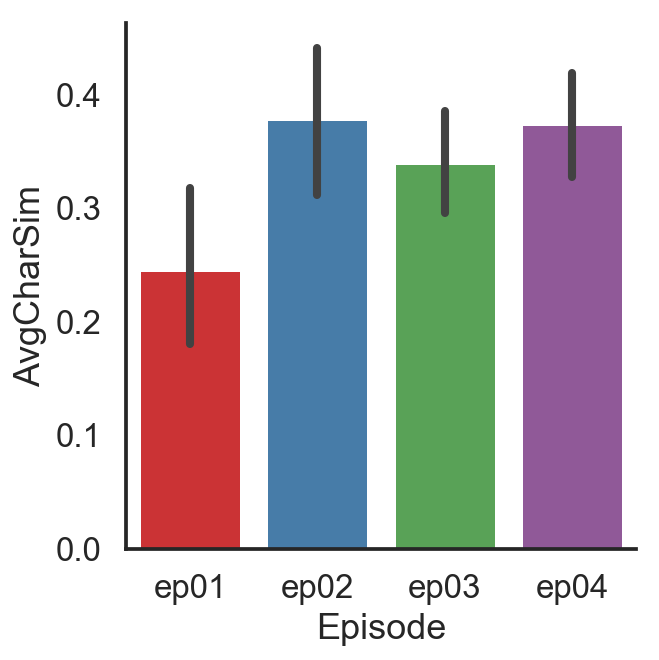

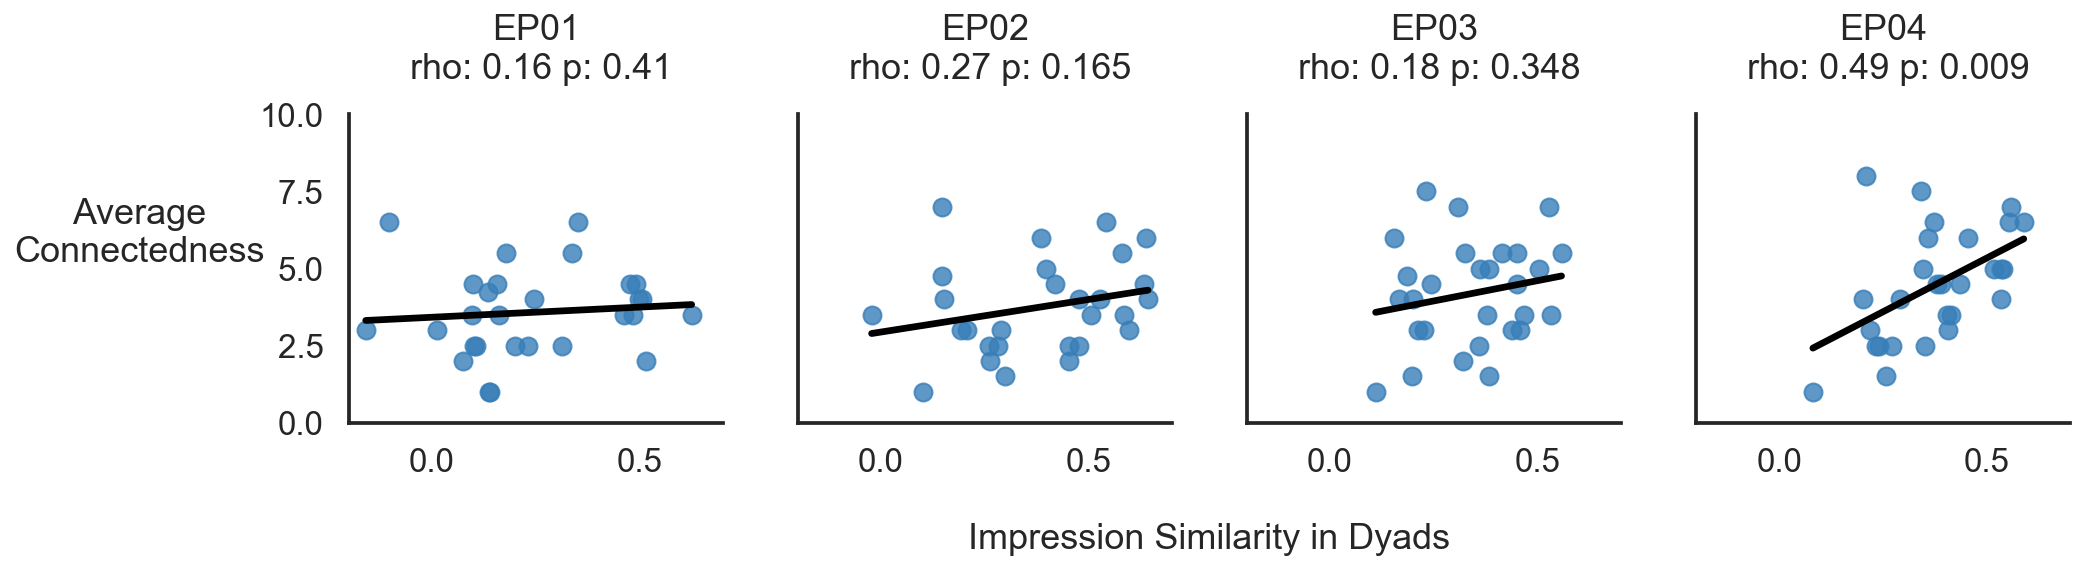

<Figure size 360x360 with 0 Axes>

In [212]:
sns.catplot(x='Episode',y='AvgCharSim',data=combined_r_df, kind='bar')
exclude_friends=False
f,ax = plt.subplots(1,len(epns),figsize=(15,5),sharex=True,sharey=True)
ax[0].set_ylim([0,10])
ax[0].set_xlim([-.2,.7])
for epi, epn in enumerate(epns):
    dyadcorr = combined_r_df.query('Episode==@epn').AvgCharSim
    dyadconn = combined_r_df.query('Episode==@epn').mean_Connection
    if exclude_friends:
        # Results similar for both episode 1&2
        dyadcorr = dyadcorr[dyads_friends_bool]
        dyadconn = dyadconn[dyads_friends_bool]
    r,p = stats.spearmanr(dyadcorr,dyadconn)
    ax[epi].set(title = f"{epn} {r:.2f} p:{p:.3f}")
    ax[epi].set_title(epn.upper()+'\n rho: '+ str(np.round(r,2))  +' p: ' + str(np.round(p,3)),y=1.08)
    sns.regplot(y = dyadconn,x = dyadcorr,ax=ax[epi],color='k',ci=False,truncate=True,scatter_kws={'color':colors[1]})
    ax[epi].set_ylabel('')
    ax[epi].set_xlabel('')

ax[0].set_ylabel('Average\nConnectedness',rotation=0,labelpad=60)
# for common label
f.add_subplot(111, frameon=False)
# plt.tick_params(which='both',labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.grid(False)
plt.xlabel(f'Impression Similarity in Dyads',rotation=0,labelpad=50)
sns.despine()
plt.tight_layout()
# f.savefig('Figures/Synchrony_corr_connectedness.pdf',dpi=300)
plt.show()    
    
plt.tight_layout()

In [426]:
%%R -i combined_r_df
# CHARSIM EFFECT
m<- lmer(' mean_Connection ~ AvgCharSim * Episode_c + (1|dyadID) ', data=combined_r_df )
print(summary(m))
# # print(coef(summary(m)))
# m<- lmer(' AvgCharSim ~ Episode_c + (1|dyadID) ', data=combined_r_df )
# print(summary(m))

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: " mean_Connection ~ AvgCharSim * Episode_c + (1|dyadID) "
   Data: combined_r_df

REML criterion at convergence: 253.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.0224 -0.6062 -0.0359  0.5610  2.2822 

Random effects:
 Groups   Name        Variance Std.Dev.
 dyadID   (Intercept) 2.301    1.517   
 Residual             0.214    0.463   
Number of obs: 112, groups:  dyadID, 28

Fixed effects:
                     Estimate Std. Error     df t value          Pr(>|t|)    
(Intercept)             3.641      0.325 41.037   11.20 0.000000000000047 ***
AvgCharSim              1.010      0.421 85.385    2.40             0.018 *  
Episode_c               0.168      0.105 82.696    1.59             0.115    
AvgCharSim:Episode_c    0.339      0.286 82.581    1.18             0.240    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
   

In [460]:
%%R -i combined_r_df
# CHARSIM EFFECT
m<- lmer(' mean_Connection ~ AvgCharSim_dm * Episode_c + (1|dyadID) ', data=combined_r_df )
print(coef(summary(m)))
m<- lmer(' mean_Connection ~ Positive_dm * Episode_c + (1|dyadID) ', data=combined_r_df )
print(coef(summary(m)))
m<- lmer(' mean_Connection ~ Spatial_SRM0_dm * Episode_c  + (1|dyadID) ', data=combined_r_df )
print(coef(summary(m)))
# TIME EFFECT
m<- lmer(' AvgCharSim ~ Episode_c + (1|dyadID) ', data=combined_r_df )
print(coef(summary(m)))
# WITH OTHERS
m<- lmer(' mean_Connection ~ mean_Enjoy_st +Positive_st*Episode_c + Spatial_SRM0_st + AvgCharSim_st + Episode_c + (1|dyadID) ', data=combined_r_df )
print(summary(m))
# Predict Enjoyment
m<- lmer(' mean_Enjoy_st ~  Positive_st*Episode_c + Spatial_SRM0_st + AvgCharSim_st + Episode_c + (1|dyadID) ', data=combined_r_df )
print(summary(m))

                        Estimate Std. Error     df t value           Pr(>|t|)
(Intercept)              3.97854   0.290227 26.959 13.7084 0.0000000000001143
AvgCharSim_dm            1.01001   0.420542 85.385  2.4017 0.0184886081330489
Episode_c                0.28145   0.041208 81.324  6.8300 0.0000000014111992
AvgCharSim_dm:Episode_c  0.33934   0.286452 82.581  1.1846 0.2395579131528732
                      Estimate Std. Error     df t value             Pr(>|t|)
(Intercept)            3.97107   0.270539 26.076 14.6783 0.000000000000040574
Positive_dm            1.04450   0.310792 87.760  3.3608 0.001152378142336323
Episode_c              0.24891   0.041095 81.062  6.0571 0.000000041363738694
Positive_dm:Episode_c  0.38441   0.178216 80.689  2.1570 0.033983627814916102
                          Estimate Std. Error     df  t value
(Intercept)               3.991875   0.291337 26.915 13.70192
Spatial_SRM0_dm           0.277276   0.150010 82.570  1.84838
Episode_c                 0.285975

In [796]:
for epn in epns: 
    r,p = stats.spearmanr(combined_r_df.query('Episode==@epn').Positive,
                          combined_r_df.query('Episode==@epn').Spatial_SRM0)
    print(r,p)

0.15489874110563767 0.43125528483288955
0.3711001642036125 0.05186959634466521
0.5062944718117133 0.005976865646059848
0.43459222769567596 0.02083313035682829


### Figure 6.  Structural Equation modeling

R[write to console]: This is lavaan 0.6-4

R[write to console]: lavaan is BETA software! Please report any bugs.



lavaan 0.6-4 ended normally after 92 iterations

  Optimization method                           NLMINB
  Number of free parameters                         14

  Number of observations                           112

  Estimator                                         ML
  Model Fit Test Statistic                       3.330
  Degrees of freedom                                 1
  P-value (Chi-square)                           0.068

Model test baseline model:

  Minimum Function Test Statistic              104.758
  Degrees of freedom                                10
  P-value                                        0.000

User model versus baseline model:

  Comparative Fit Index (CFI)                    0.975
  Tucker-Lewis Index (TLI)                       0.754

Loglikelihood and Information Criteria:

  Loglikelihood user model (H0)               -339.390
  Loglikelihood unrestricted model (H1)       -337.725

  Number of free parameters                         14
  Akaike (AIC)  

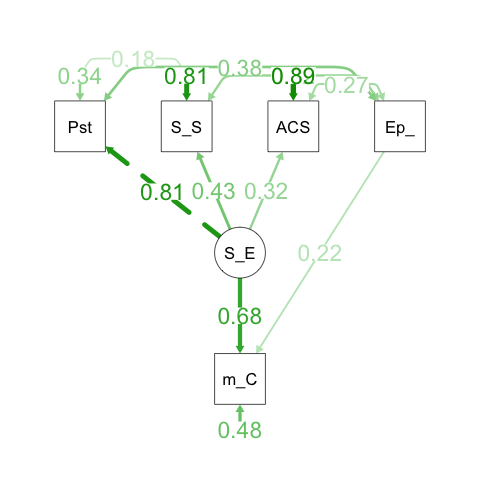

In [213]:
%%R -i combined_r_df
library(lavaan)
library(semPlot)
model <-'
          # measurement model 
          Sh_Exp =~  Positive + Spatial_SRM0 + AvgCharSim 
          # Regression part
          mean_Connection ~ Sh_Exp + Episode_c
          # Covariance residual correlations
          Positive ~~ Spatial_SRM0 
          Episode_c ~~ Positive + Spatial_SRM0 + AvgCharSim 
        '
fit <- sem(model, data=combined_r_df)
summary(fit, standardized=TRUE, fit.measure=TRUE)
semPaths(fit,"std", style='lisrel',layout='tree',edge.label.cex=2.0, curvePivot = TRUE, residuals=TRUE, title=TRUE,sizeMan = 10, sizeLat = 10, sizeInt = 4)
standardizedSolution(fit)
print(fitMeasures(fit,c('chisq','df','pvalue','rfi','cfi','ifi','gfi','nfi','nnfi','rmsea','rmsea.ci.lower','rmsea.ci.upper','rmsea.pvalue','srmr')))
print(inspect(fit, "sample"))
print(inspect(fit, "fitted"))
print(residuals(fit, type="cor"))


# put tempsync, spatialsync, impsync together

In [28]:
combined_r_df = pd.read_csv('../../Data/ratings/Combined/r_df.csv', index_col=0)
# Demeaned
combined_r_df['Positive_dm']=combined_r_df.Positive-combined_r_df.Positive.mean()
combined_r_df['Negative_dm']=combined_r_df.Negative-combined_r_df.Negative.mean()
combined_r_df['mean_Enjoy_dm']=combined_r_df.mean_Enjoy-combined_r_df.mean_Enjoy.mean()
combined_r_df['ImpSim_dm']=combined_r_df.ImpSim-combined_r_df.ImpSim.mean()
combined_r_df['AverageAUSim_dm']=combined_r_df.AverageAUSim-combined_r_df.AverageAUSim.mean()
combined_r_df['Spatial_SRM0_dm']=combined_r_df.Spatial_SRM0-combined_r_df.Spatial_SRM0.mean()
combined_r_df['Spatial_SRM1_dm']=combined_r_df.Spatial_SRM1-combined_r_df.Spatial_SRM1.mean()
combined_r_df['Temporal_SRM0_dm']=combined_r_df.Temporal_SRM0-combined_r_df.Temporal_SRM0.mean()
combined_r_df['Temporal_SRM1_dm']=combined_r_df.Temporal_SRM1-combined_r_df.Temporal_SRM1.mean()
# # Standardized
combined_r_df['Positive_st']=(combined_r_df.Positive-combined_r_df.Positive.mean() )/ combined_r_df.Positive.std()
combined_r_df['Negative_st']=(combined_r_df.Negative-combined_r_df.Negative.mean()) /combined_r_df.Negative.std() 
combined_r_df['mean_Enjoy_st']=(combined_r_df.mean_Enjoy-combined_r_df.mean_Enjoy.mean()) /combined_r_df.mean_Enjoy.std() 
combined_r_df['ImpSim_st']=(combined_r_df.ImpSim-combined_r_df.ImpSim.mean() )/ combined_r_df.ImpSim.std()
combined_r_df['AverageAUSim_st']=(combined_r_df.AverageAUSim-combined_r_df.AverageAUSim.mean()) /combined_r_df.AverageAUSim.std()
combined_r_df['Spatial_SRM0_st']=(combined_r_df.Spatial_SRM0-combined_r_df.Spatial_SRM0.mean())/combined_r_df.Spatial_SRM0.std()
combined_r_df['Spatial_SRM1_st']=(combined_r_df.Spatial_SRM1-combined_r_df.Spatial_SRM1.mean())/combined_r_df.Spatial_SRM1.std()
combined_r_df['Temporal_SRM0_st']=(combined_r_df.Temporal_SRM0-combined_r_df.Temporal_SRM0.mean())/combined_r_df.Temporal_SRM0.std()
combined_r_df['Temporal_SRM1_st']=(combined_r_df.Temporal_SRM1-combined_r_df.Temporal_SRM1.mean())/combined_r_df.Temporal_SRM1.std()
# Center episode
combined_r_df['Episode_c'] = combined_r_df.Episode.apply(lambda x: int(x[-1])-2.5)
combined_r_df['Episode_st'] = (combined_r_df.Episode_c-combined_r_df.Episode_c.mean()) /combined_r_df.Episode_c.std()

In [33]:
%%R -i combined_r_df
m <- lmer('mean_Connection ~ Positive_dm * Episode_c + (1|dyadID)', data=combined_r_df)
print(coef(summary(m)))
m <- lmer('mean_Connection ~ Spatial_SRM0_dm * Episode_c  +(1|dyadID)', data=combined_r_df)
print(coef(summary(m)))
m <- lmer('mean_Connection ~ ImpSim_dm * Episode_c  +(1|dyadID)', data=combined_r_df)
print(coef(summary(m)))
m <- lmer('mean_Connection ~ mean_Enjoy_dm * Episode_c  +(1|dyadID)', data=combined_r_df)
print(coef(summary(m)))

                      Estimate Std. Error     df t value             Pr(>|t|)
(Intercept)            3.97107   0.270539 26.076 14.6783 0.000000000000040574
Positive_dm            1.04450   0.310792 87.760  3.3608 0.001152378142336323
Episode_c              0.24891   0.041095 81.062  6.0571 0.000000041363738694
Positive_dm:Episode_c  0.38441   0.178216 80.689  2.1570 0.033983627814916102
                          Estimate Std. Error     df  t value
(Intercept)               3.991875   0.291337 26.915 13.70192
Spatial_SRM0_dm           0.277276   0.150010 82.570  1.84838
Episode_c                 0.285975   0.042718 80.987  6.69444
Spatial_SRM0_dm:Episode_c 0.014031   0.116060 81.448  0.12089
                                     Pr(>|t|)
(Intercept)               0.00000000000011874
Spatial_SRM0_dm           0.06812718816818175
Episode_c                 0.00000000260708096
Spatial_SRM0_dm:Episode_c 0.90407455610824394
                    Estimate Std. Error     df  t value            Pr(